# Predicting house prices with Machine Learning, AI
## Using SKLearn, LightGBM and XGBoost
### By Nasrudin Bin Salim

## Objectives and Goals of this project

### 1. Estimating the value of homes from fixed characteristics.
#### a. Train on pre 2010 and test on post 2010
### 2.  Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.
### 3. What property characteristics predict an "abnormal" sale?


### Basic Imports

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

### Import Machine Learning

In [3]:
import sklearn as sk
import lightgbm as lgb
import xgboost as xgb


/home/nasdin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Files

In [4]:
datafile = "./housing.csv"
descfile= "./data_description.txt"

#### Read the Description file

In [5]:
with open(descfile) as file:
    for line in file:
        print line

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES

        80	SPLIT OR MULTI-LEVEL

        85	SPLIT FOYER

        90	DUPLEX - ALL STYLES AND AGES

       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER

       150	1-1/2 STORY PUD - ALL AGES

       160	2-STORY PUD - 1946 & NEWER

       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER

       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential 

#### If there's none of something, it would be called NA

##### Load into df

In [6]:
df =pd.read_csv(datafile)
untouched = pd.read_csv(datafile)

## Estimating the value of homes from fixed characteristics.
1. Perform any cleaning, feature engineering, and EDA deem necessary.
2. Be sure to remove any houses that are not residential from the dataset.
3. Identify fixed features that can predict price.
4. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
5. Characterize the model. How well does it perform? What are the best estimates of price?

## EDA and data cleaning

### Observe the Datatypes of each column
    They seem to be okay.

In [7]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [8]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

#### Data is "Clean", the NA values refers to houses which just does not have those features

In [9]:
ID=df['Id']

### Drop non residential

In [10]:
CannotRelakOneCorner =["A","C","I"]
for NoVoidDeck in CannotRelakOneCorner:
    df.drop(df.loc[df['MSZoning']==NoVoidDeck,'MSZoning'].index,axis=0,inplace=True)

### Also observe the % of missing Data

In [11]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000

### Creating a Data Dictionary to categorize the columns from fixed characteristics to renovatable characteristics

In [12]:
housedict = {"fixed": ['TotalSF','MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley','LotShape','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle', 'YearBuilt','YearRemodAdd','RoofMatl','MasVnrArea','Foundation','BsmtQual','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF', 'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscFeature','MiscVal','MoSold', 'YrSold','SaleType','SaleCondition']}
housedict.update ({'renovatable':[renovatable for renovatable in df.columns if renovatable not in housedict['fixed'] ] })
housedict['renovatable'].remove('SalePrice')

### Dealing with empty data ( not that they're "missing", the house just doesn't have them)

In [13]:
for column in df.columns:
    if df[column].dtypes == object:
        df[column] = df[column].replace(np.nan,"None")
    else:
        df[column] = df[column].replace(np.nan,0)

In [14]:
pd.options.display.max_columns =999

In [15]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

### Add one new feature

In [16]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

### Defining Categorical Data

In [17]:
categorical = [ column for column in df.columns if df[column].dtypes == object]

In [18]:
categorical.extend(['MSSubClass'])
df['MSSubClass']=df['MSSubClass'].astype(object)

## The target: SalesPrice

In [19]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

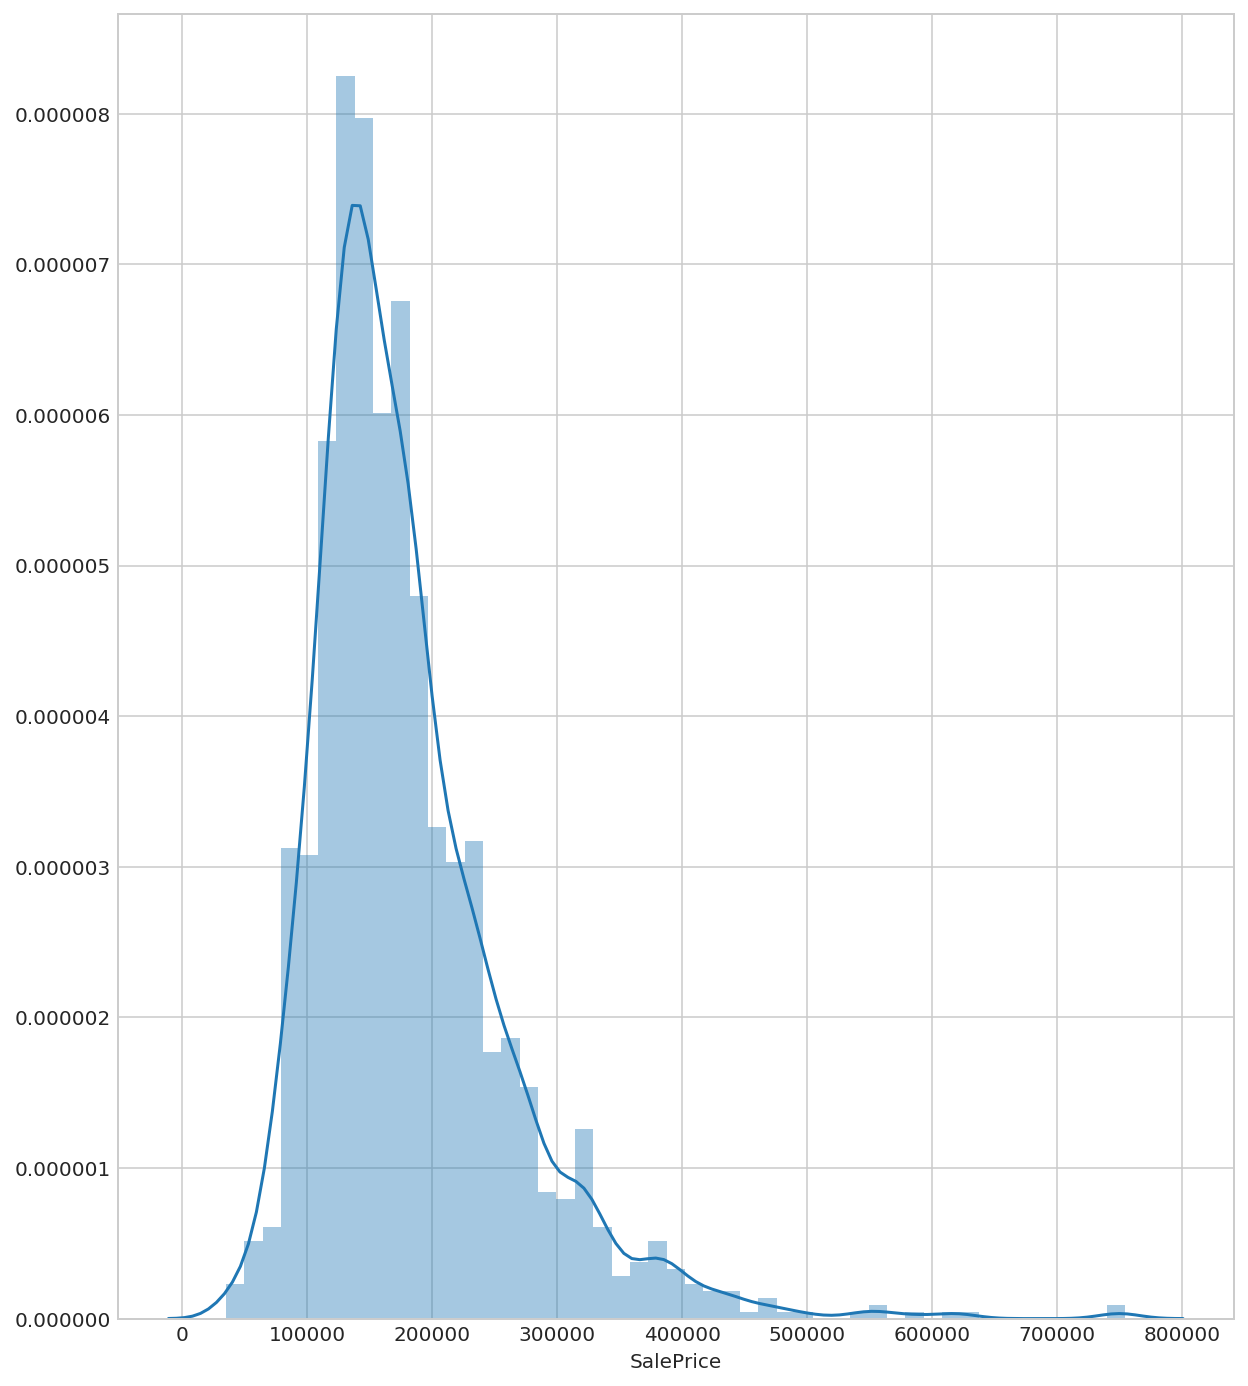

In [20]:
plt.subplots(figsize=[10,12])
sns.distplot(df['SalePrice'])


In [21]:
df.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [22]:
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


/home/nasdin/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


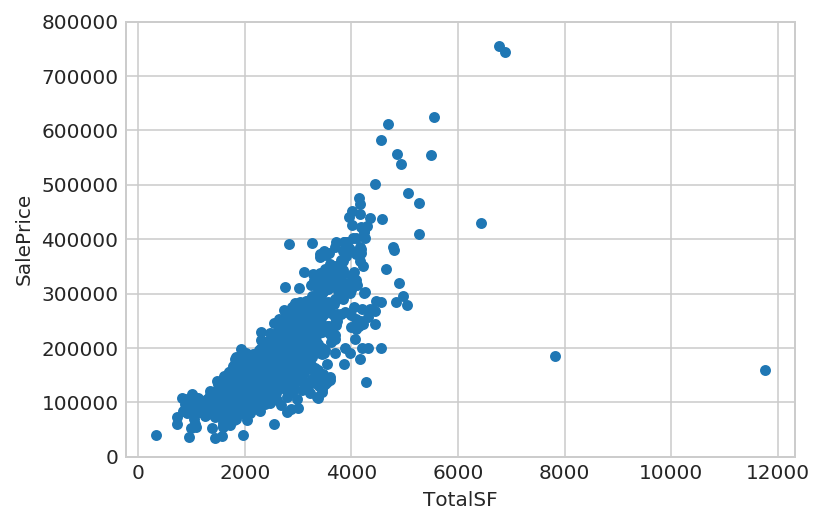

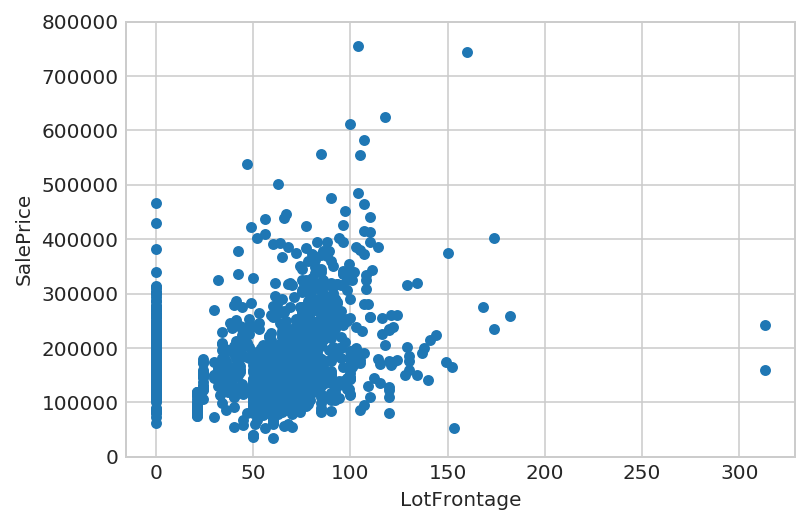

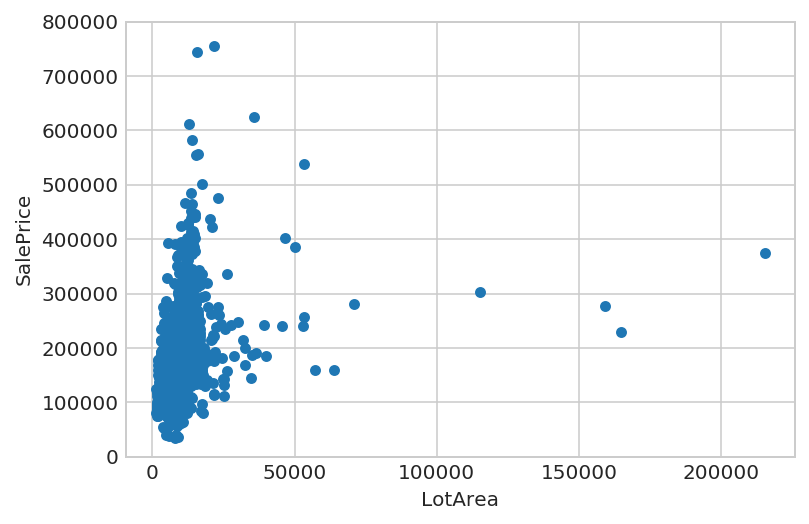

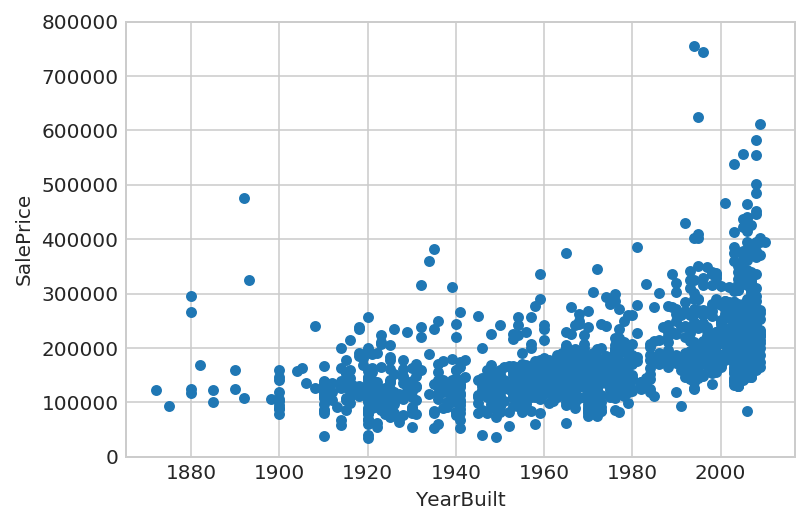

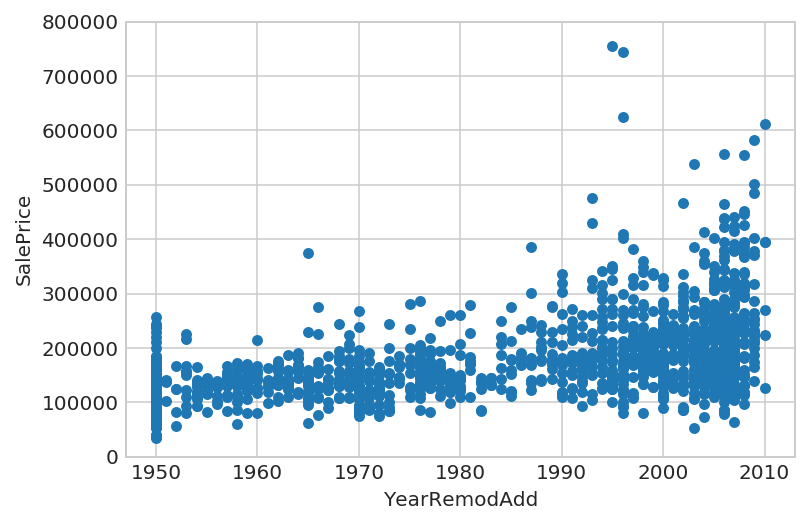

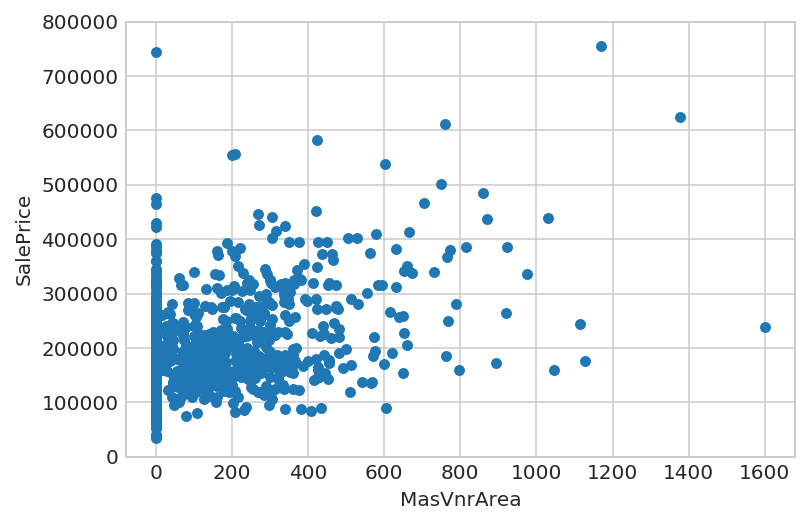

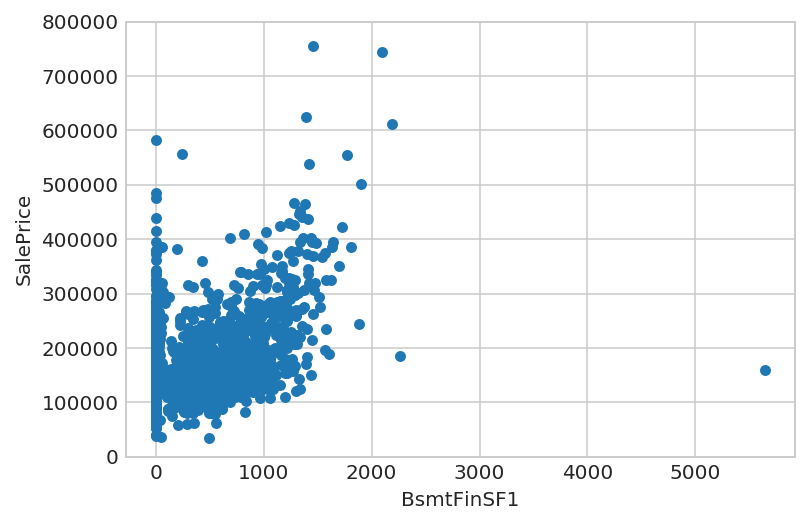

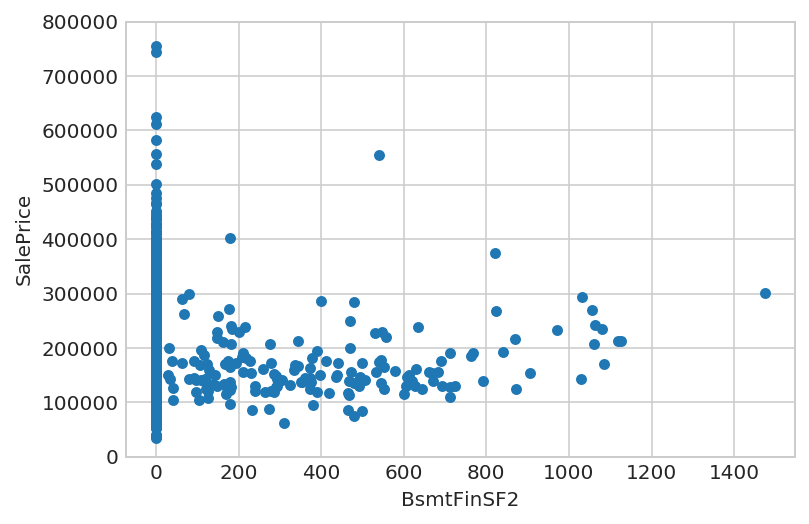

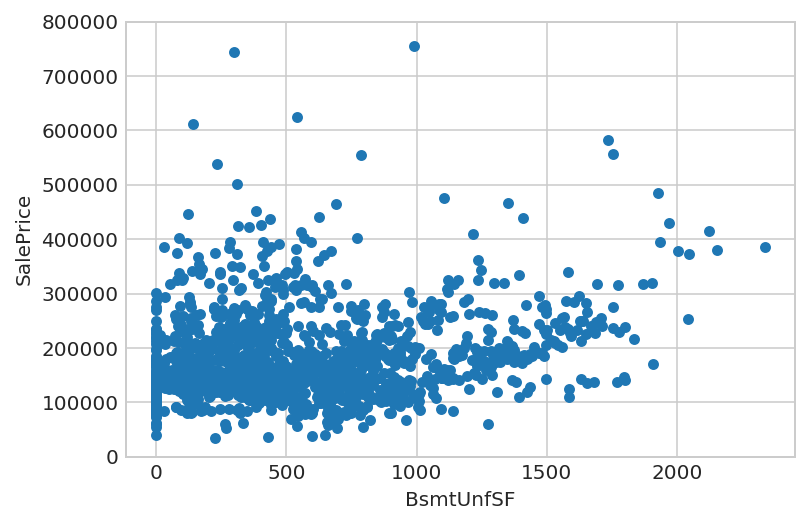

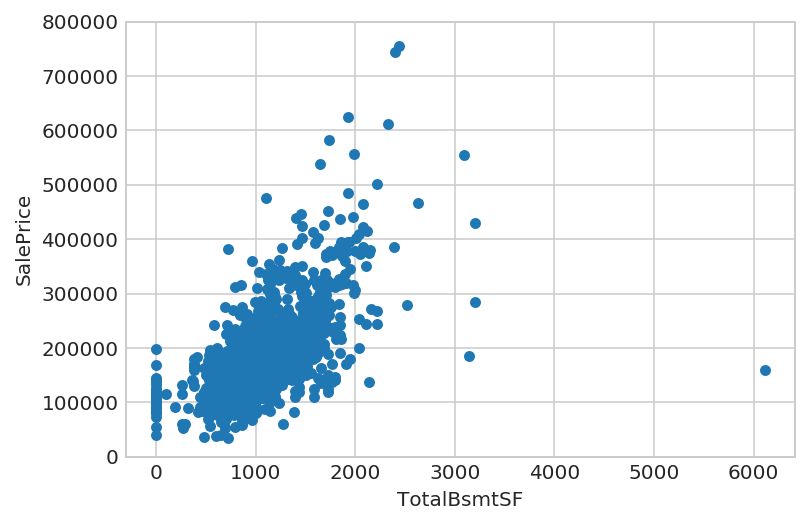

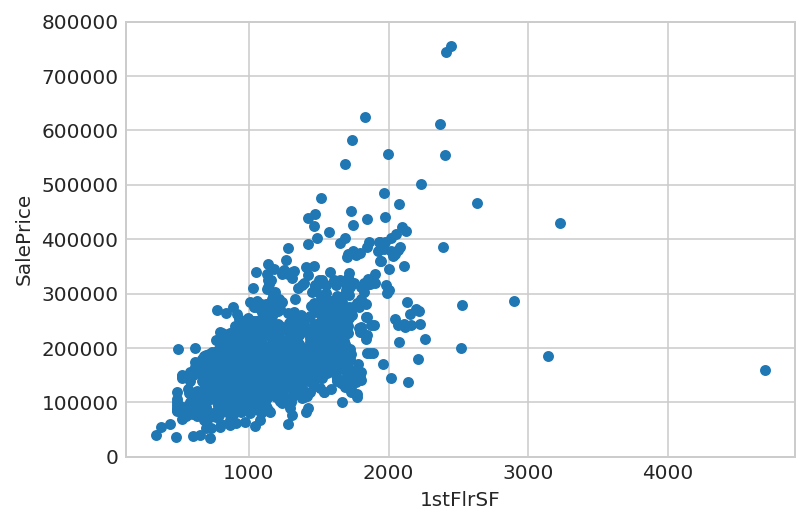

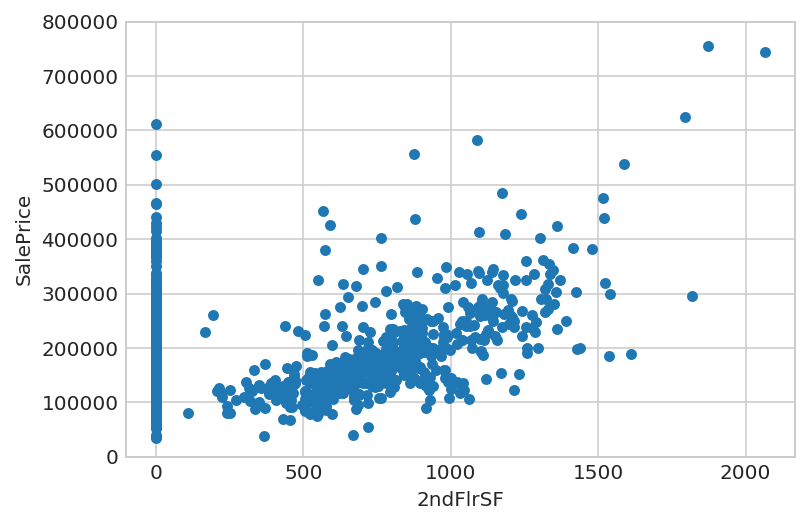

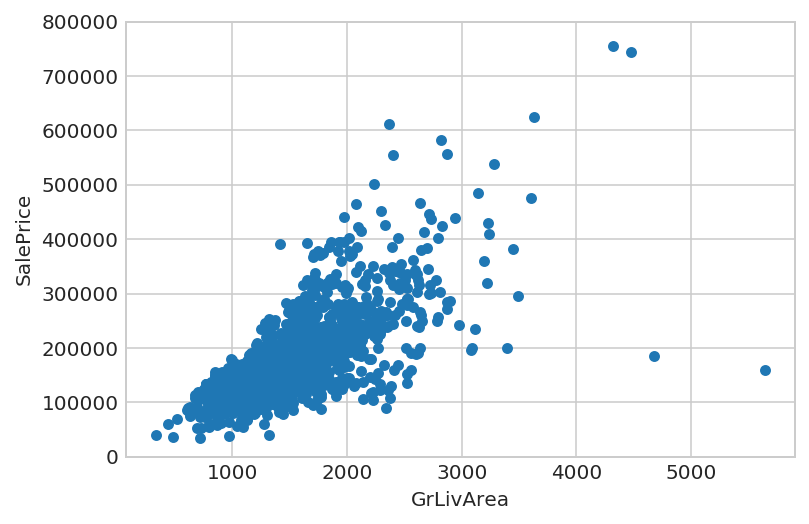

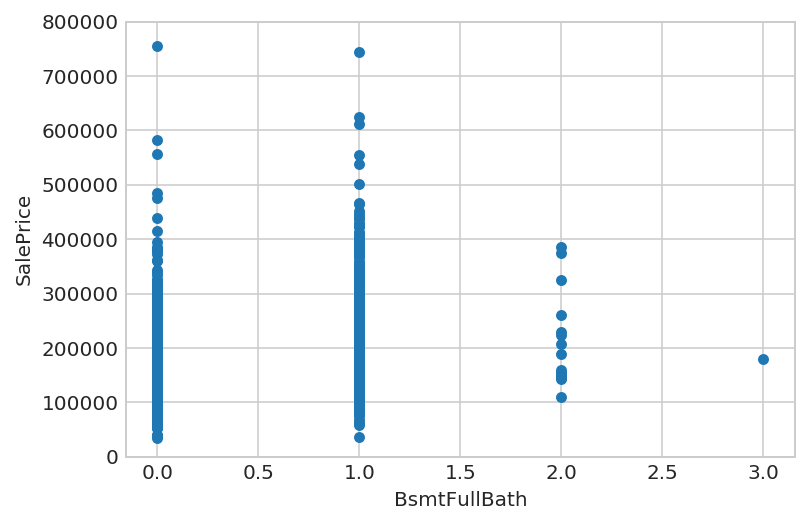

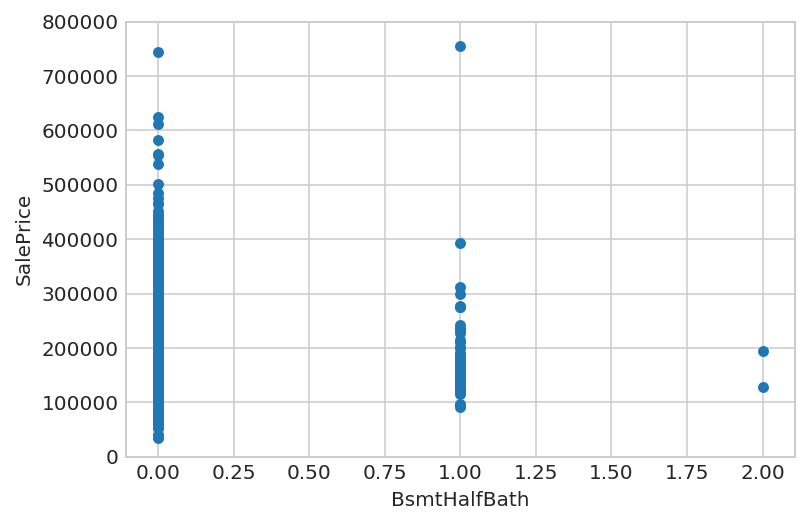

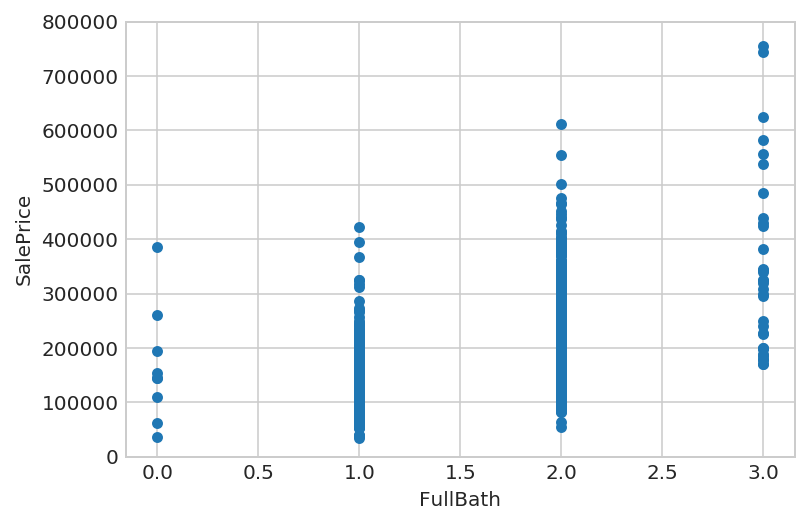

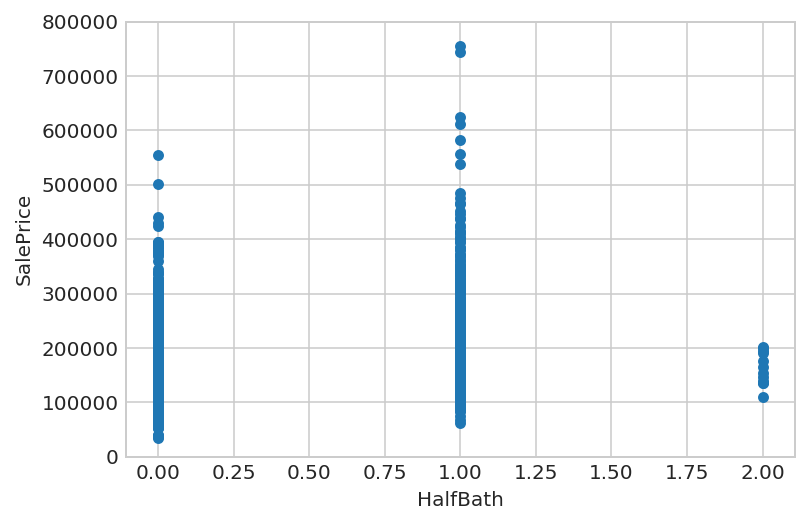

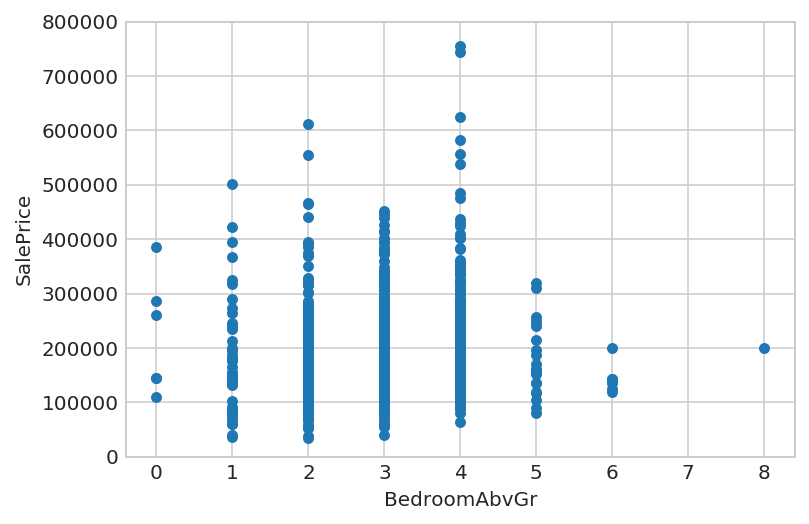

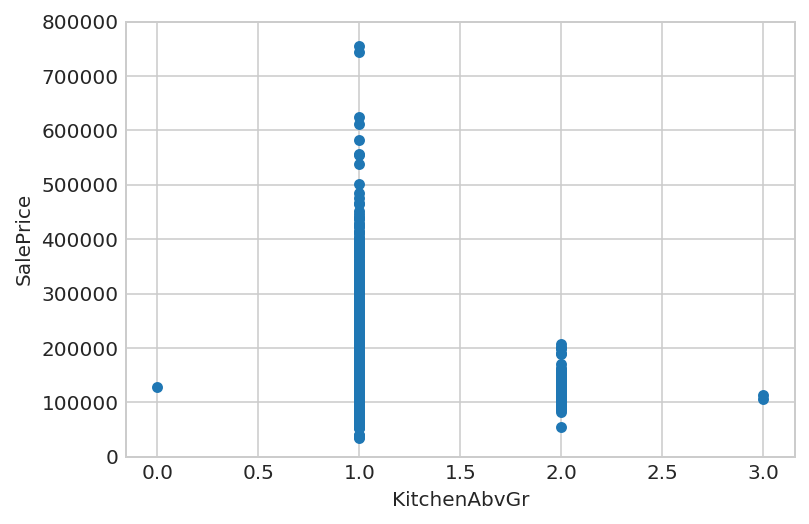

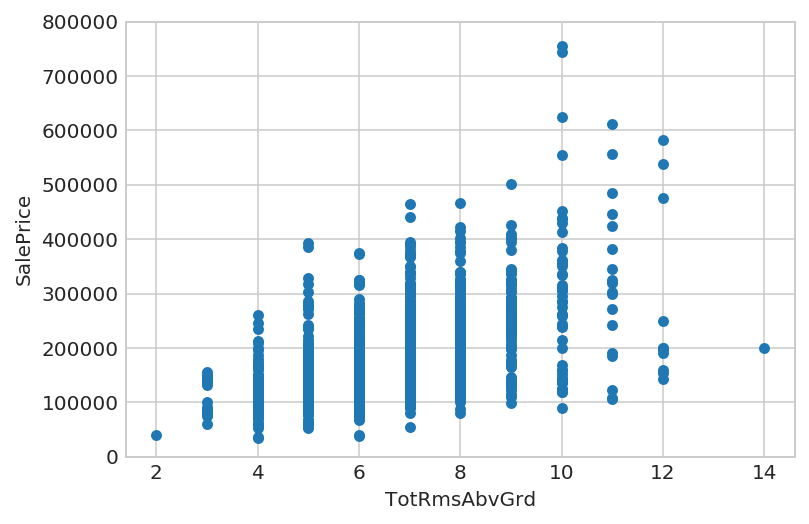

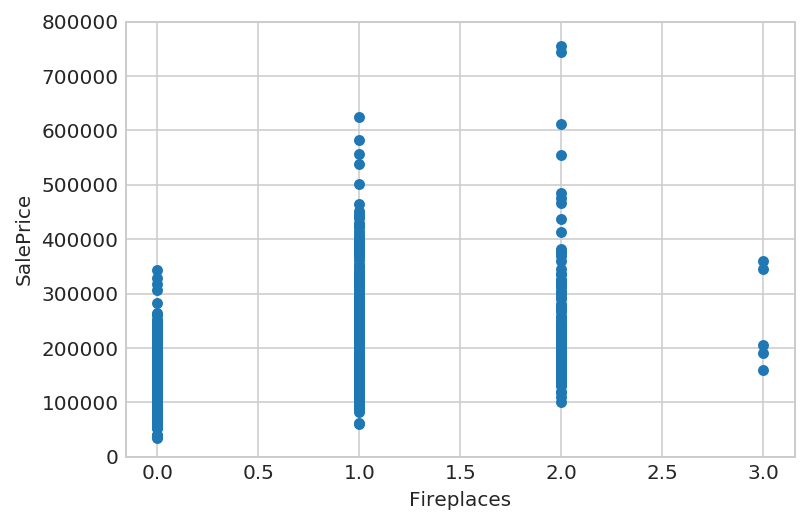

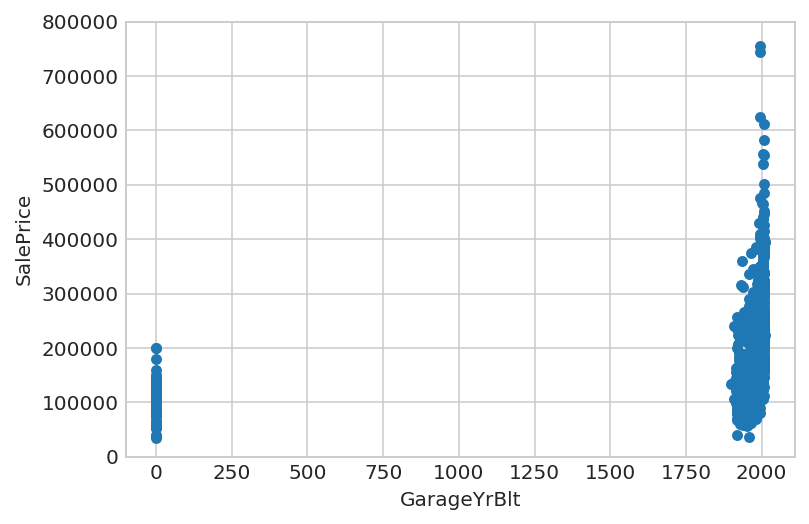

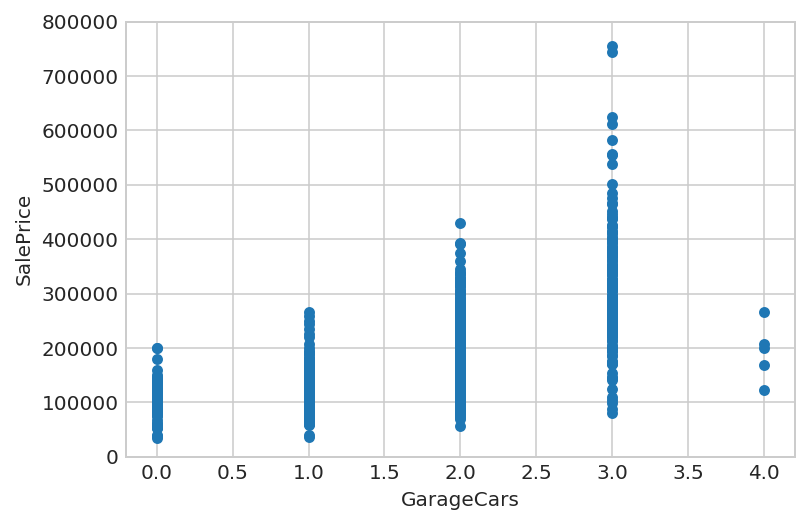

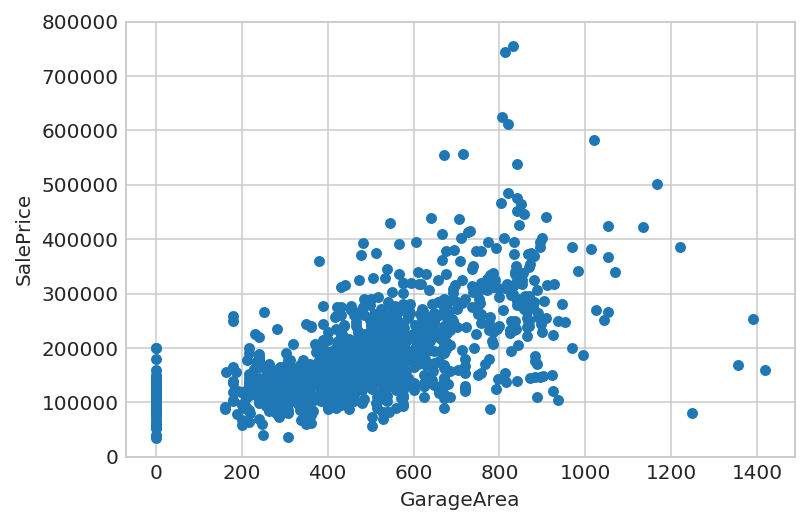

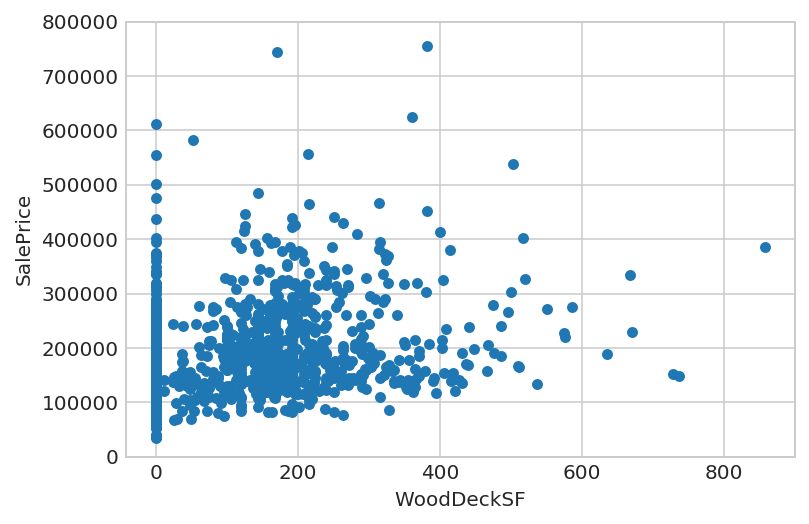

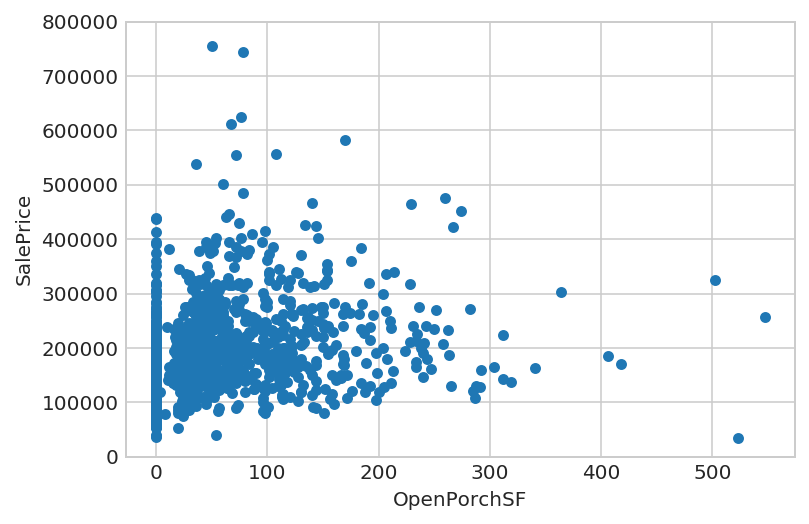

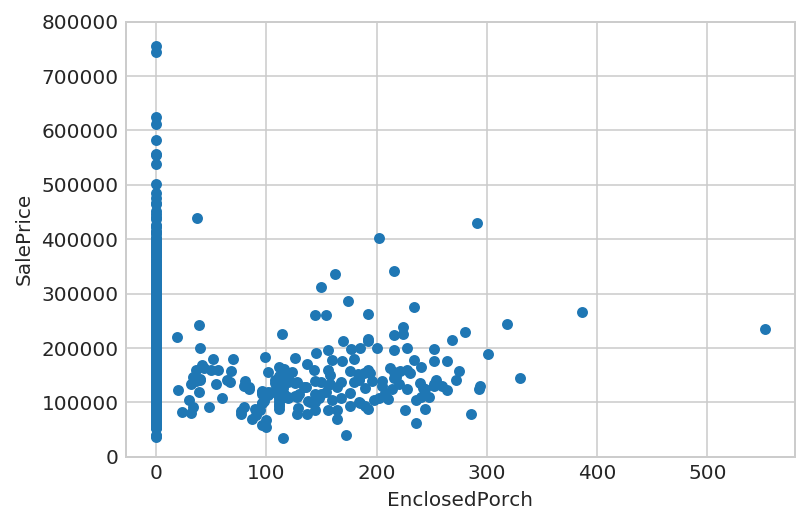

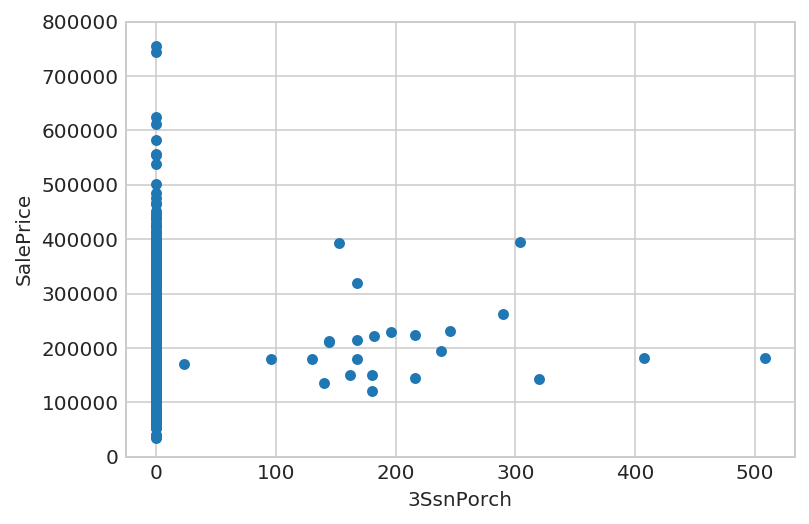

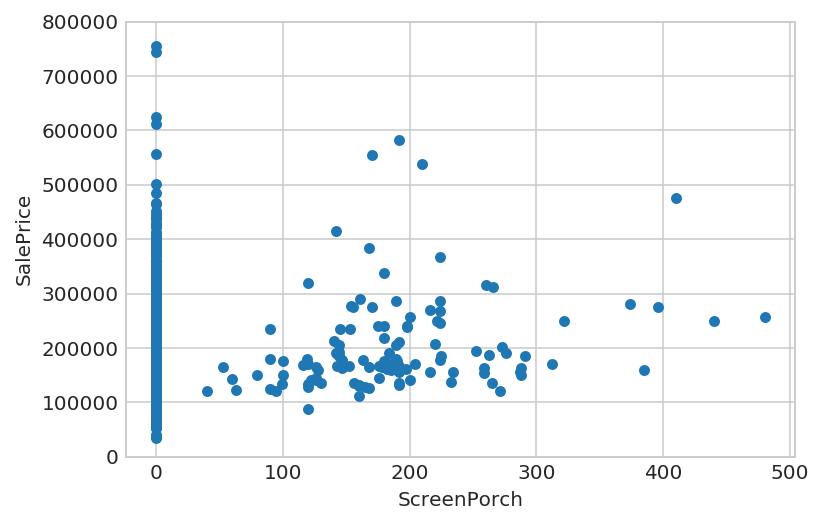

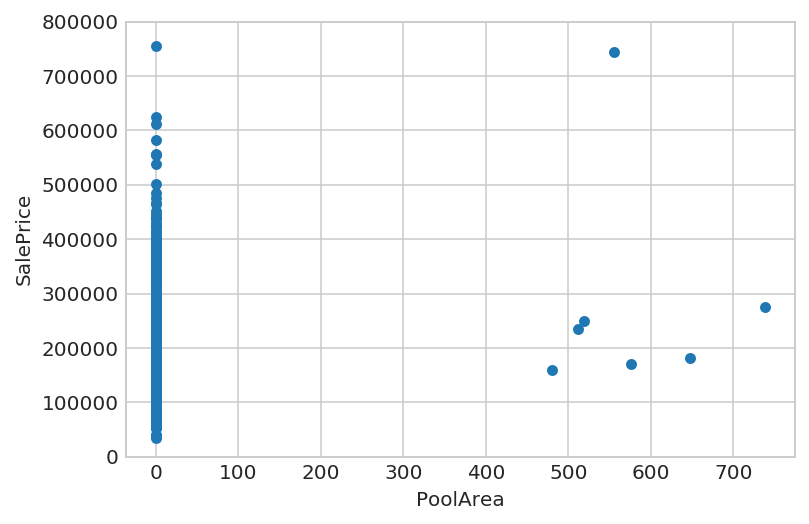

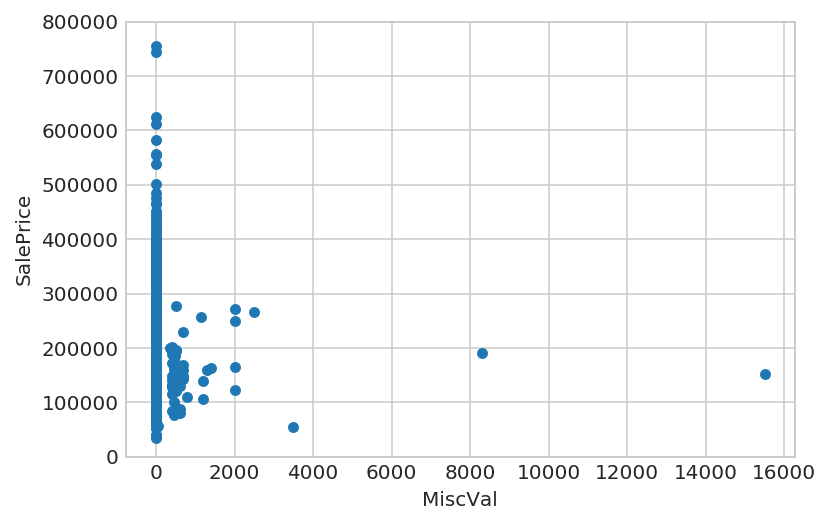

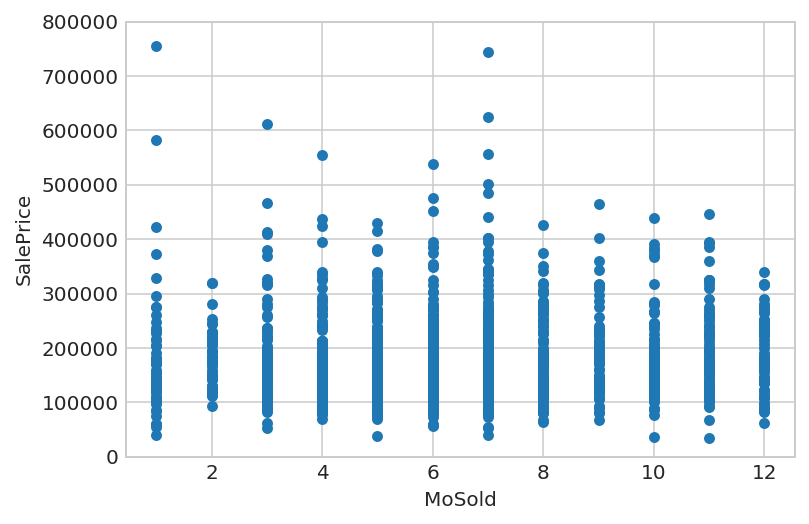

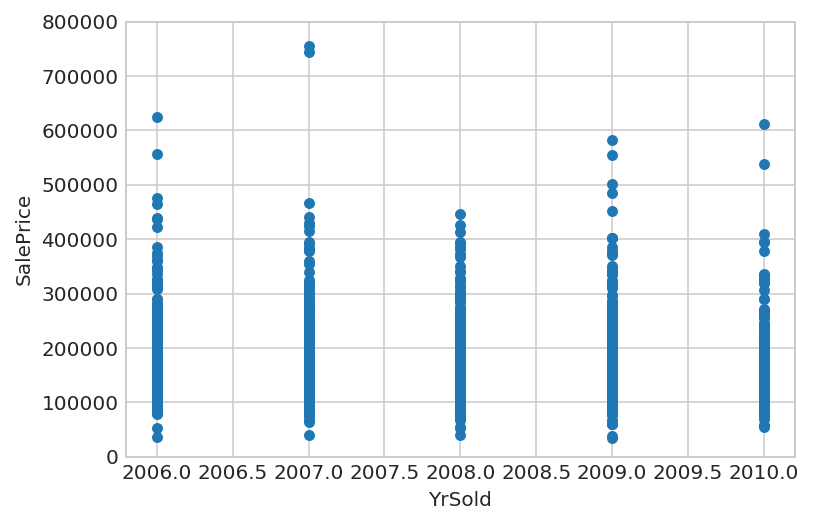

In [23]:
for fixed in housedict['fixed']:
    if df[fixed].dtypes != object:
        data = pd.concat([df['SalePrice'], df[fixed]], axis=1)
        data.plot.scatter(x=fixed, y='SalePrice', ylim=(0,800000))

In [24]:
Corrlist = df.corr()[['SalePrice']].sort_values('SalePrice',axis=0, ascending=False)
Corrlist['Correlation'] = Corrlist.index

In [25]:
Corrlist.head()

SalePrice  Correlation
SalePrice     1.000000    SalePrice
OverallQual   0.790982  OverallQual
TotalSF       0.782260      TotalSF
GrLivArea     0.708624    GrLivArea
GarageCars    0.640409   GarageCars

### Continuous and integer correlations

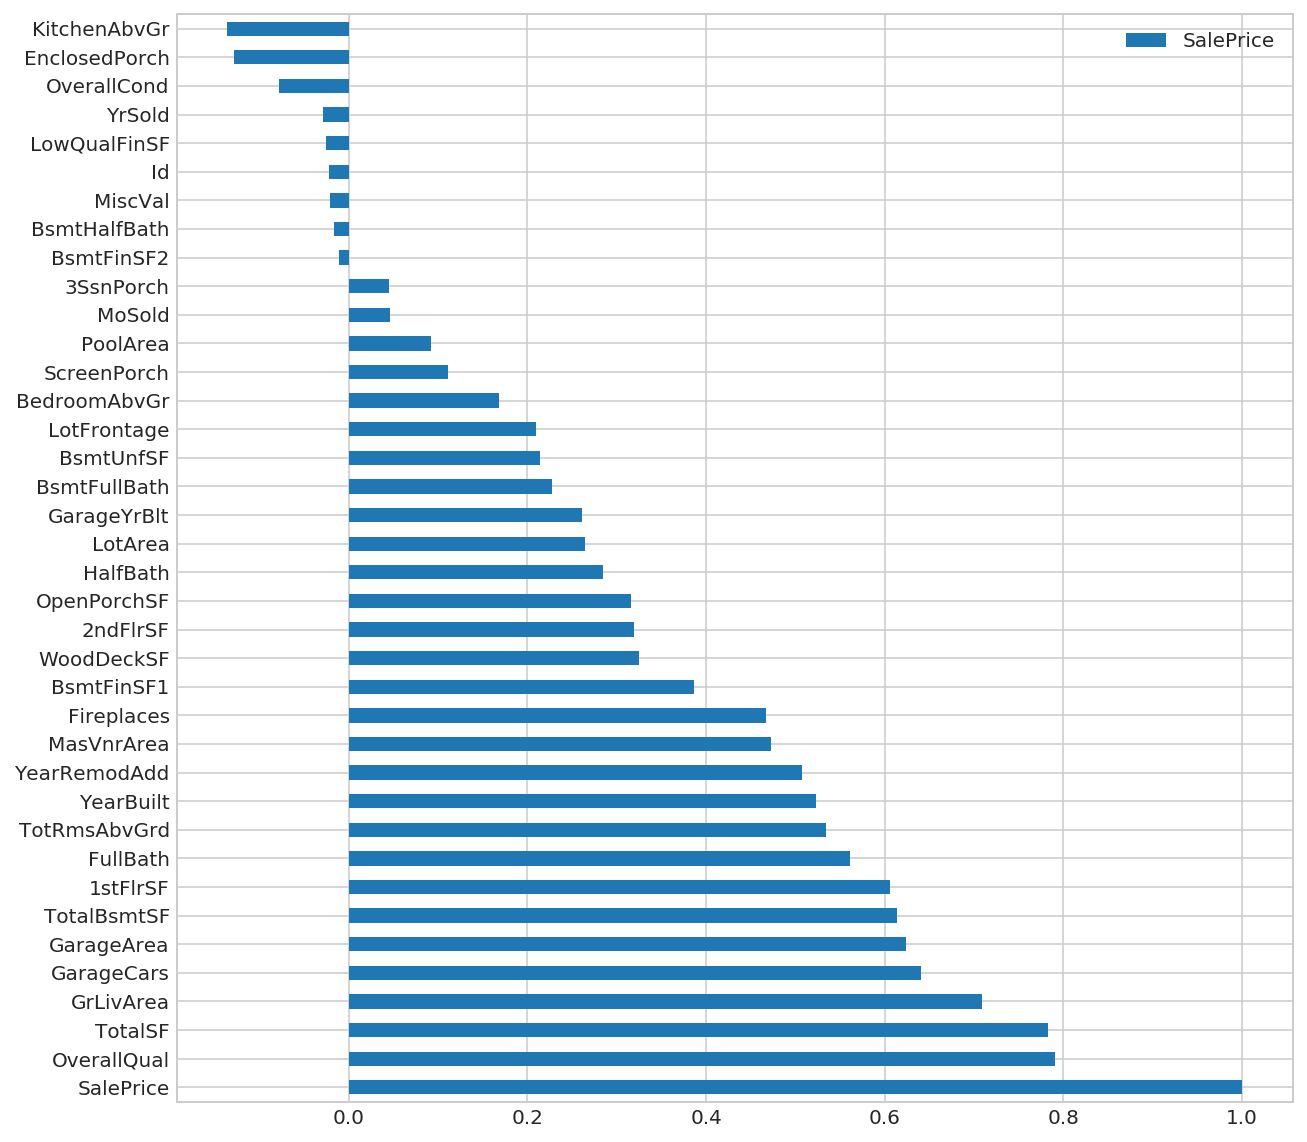

In [26]:
Corrlist.plot.barh(figsize=[10,10])

### Categorical relationships

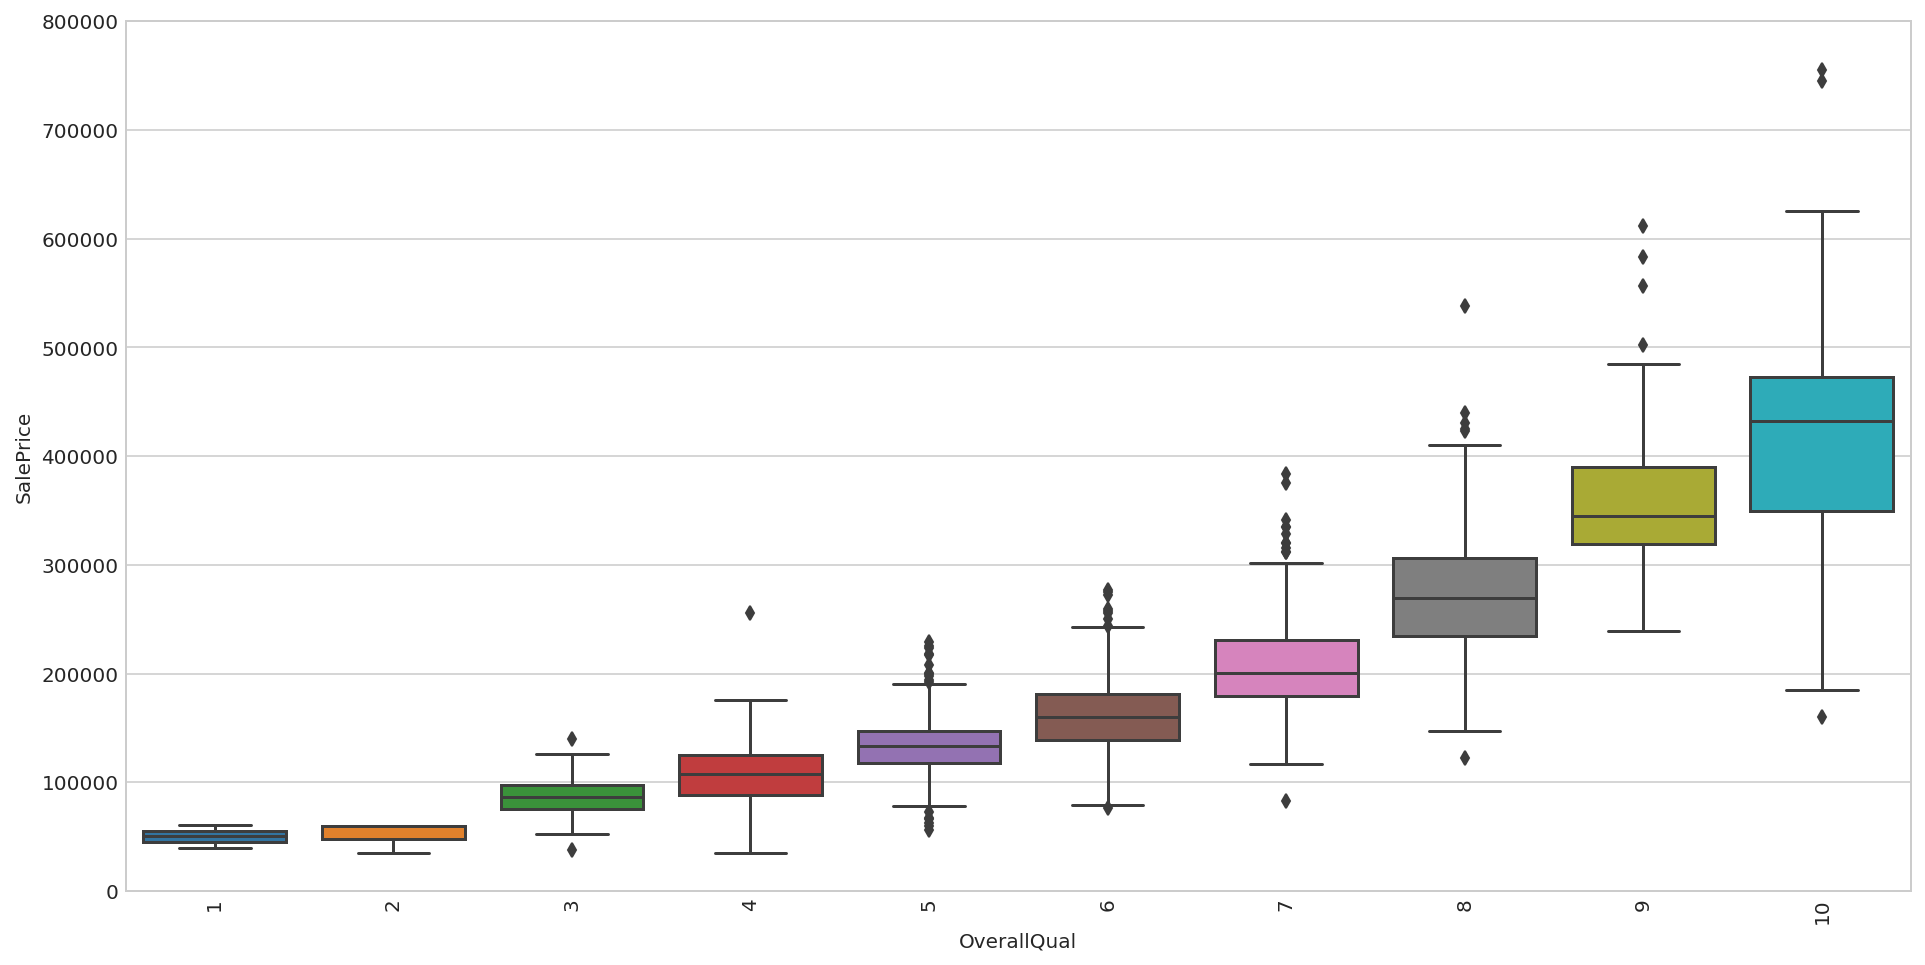

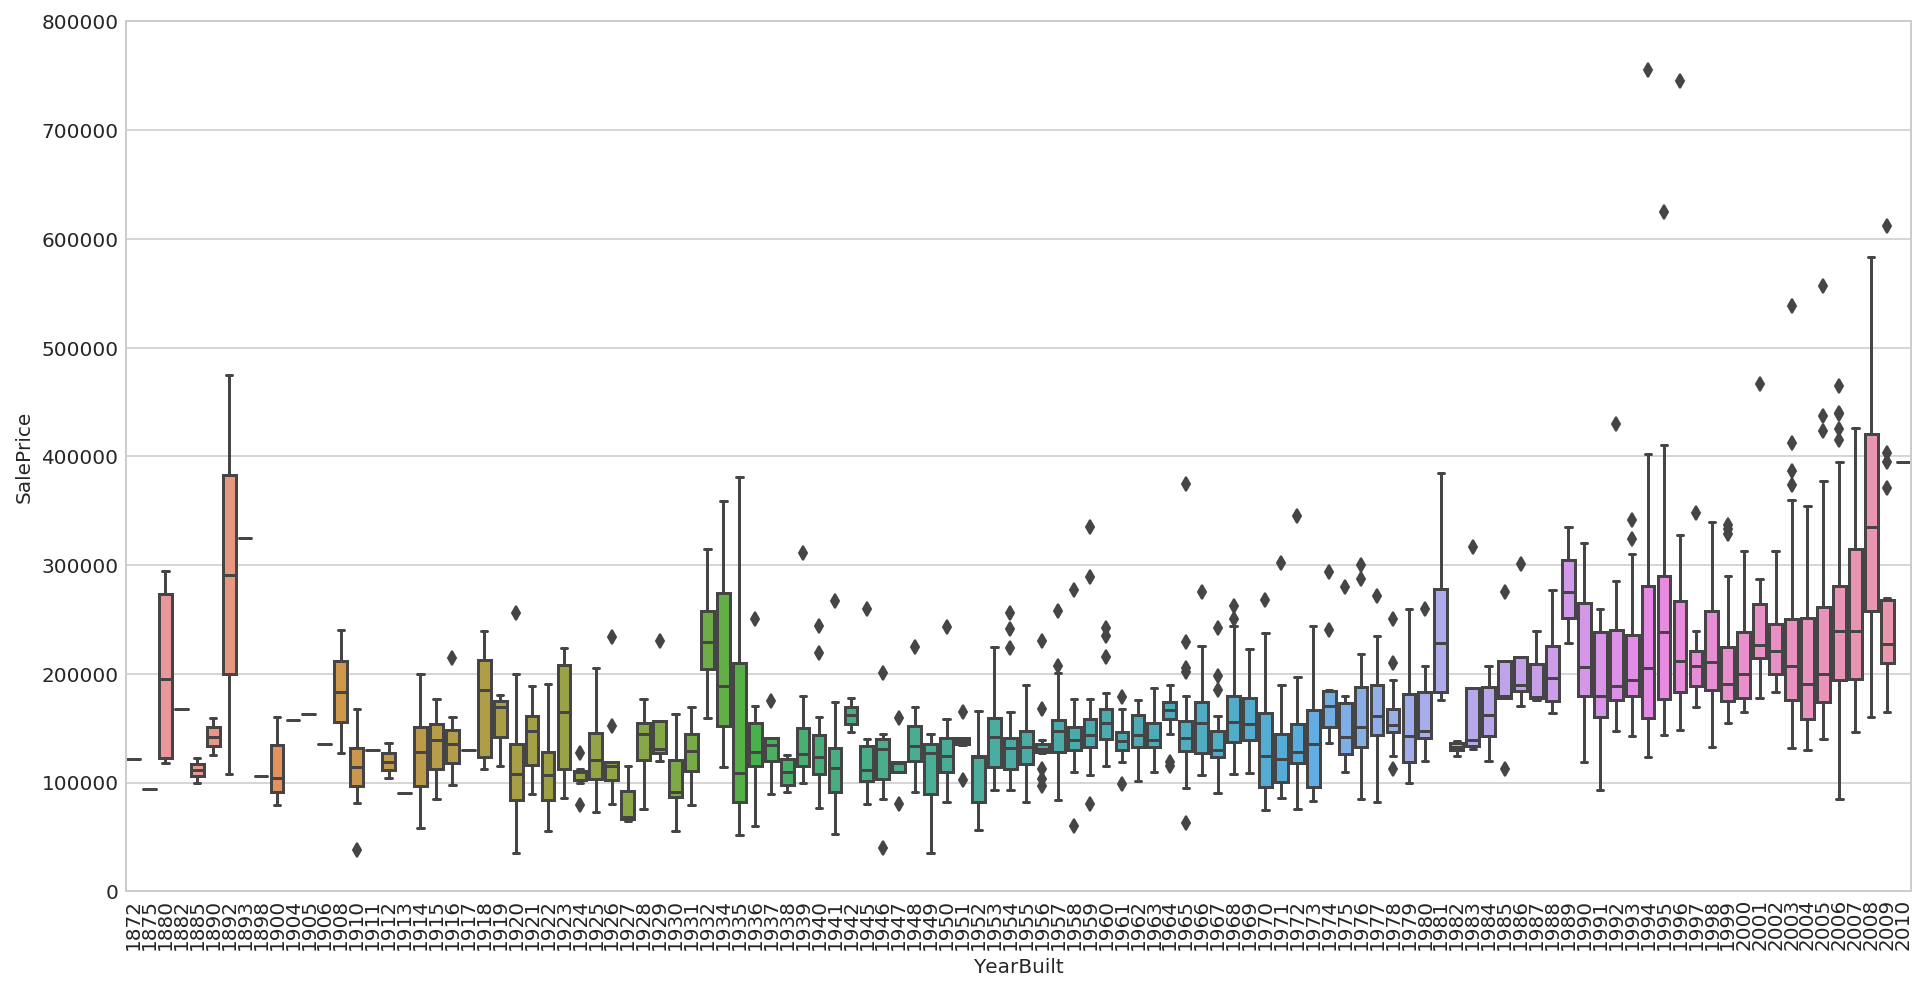

In [27]:
categories =['OverallQual','YearBuilt']
for var in categories:
   
    data = pd.concat([df['SalePrice'], df[var]], axis=1)
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);
    plt.xticks(rotation=90);

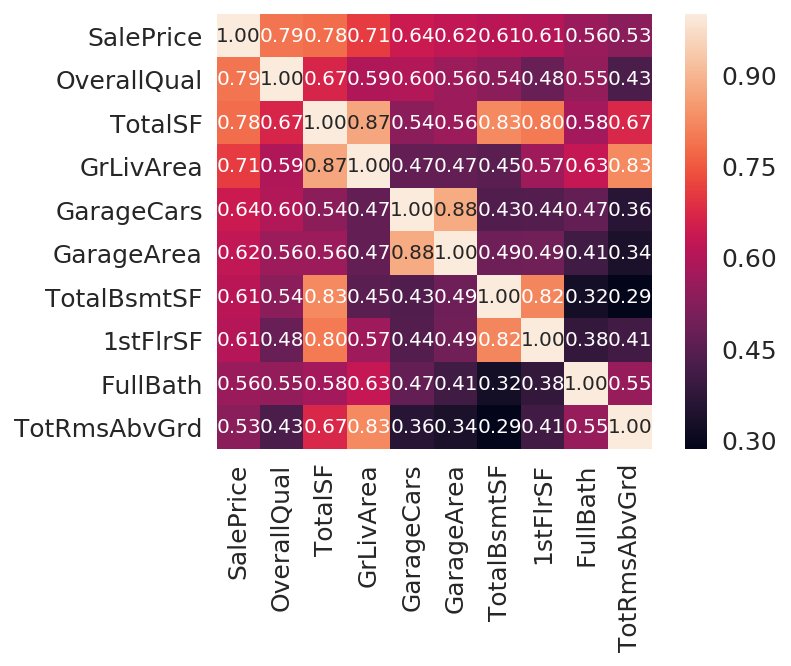

In [28]:
k = 10 #number of variables for heatmap
cols = df.corr().nlargest(k, 'SalePrice')['SalePrice'].index # Basically just show the K-largest correlations
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

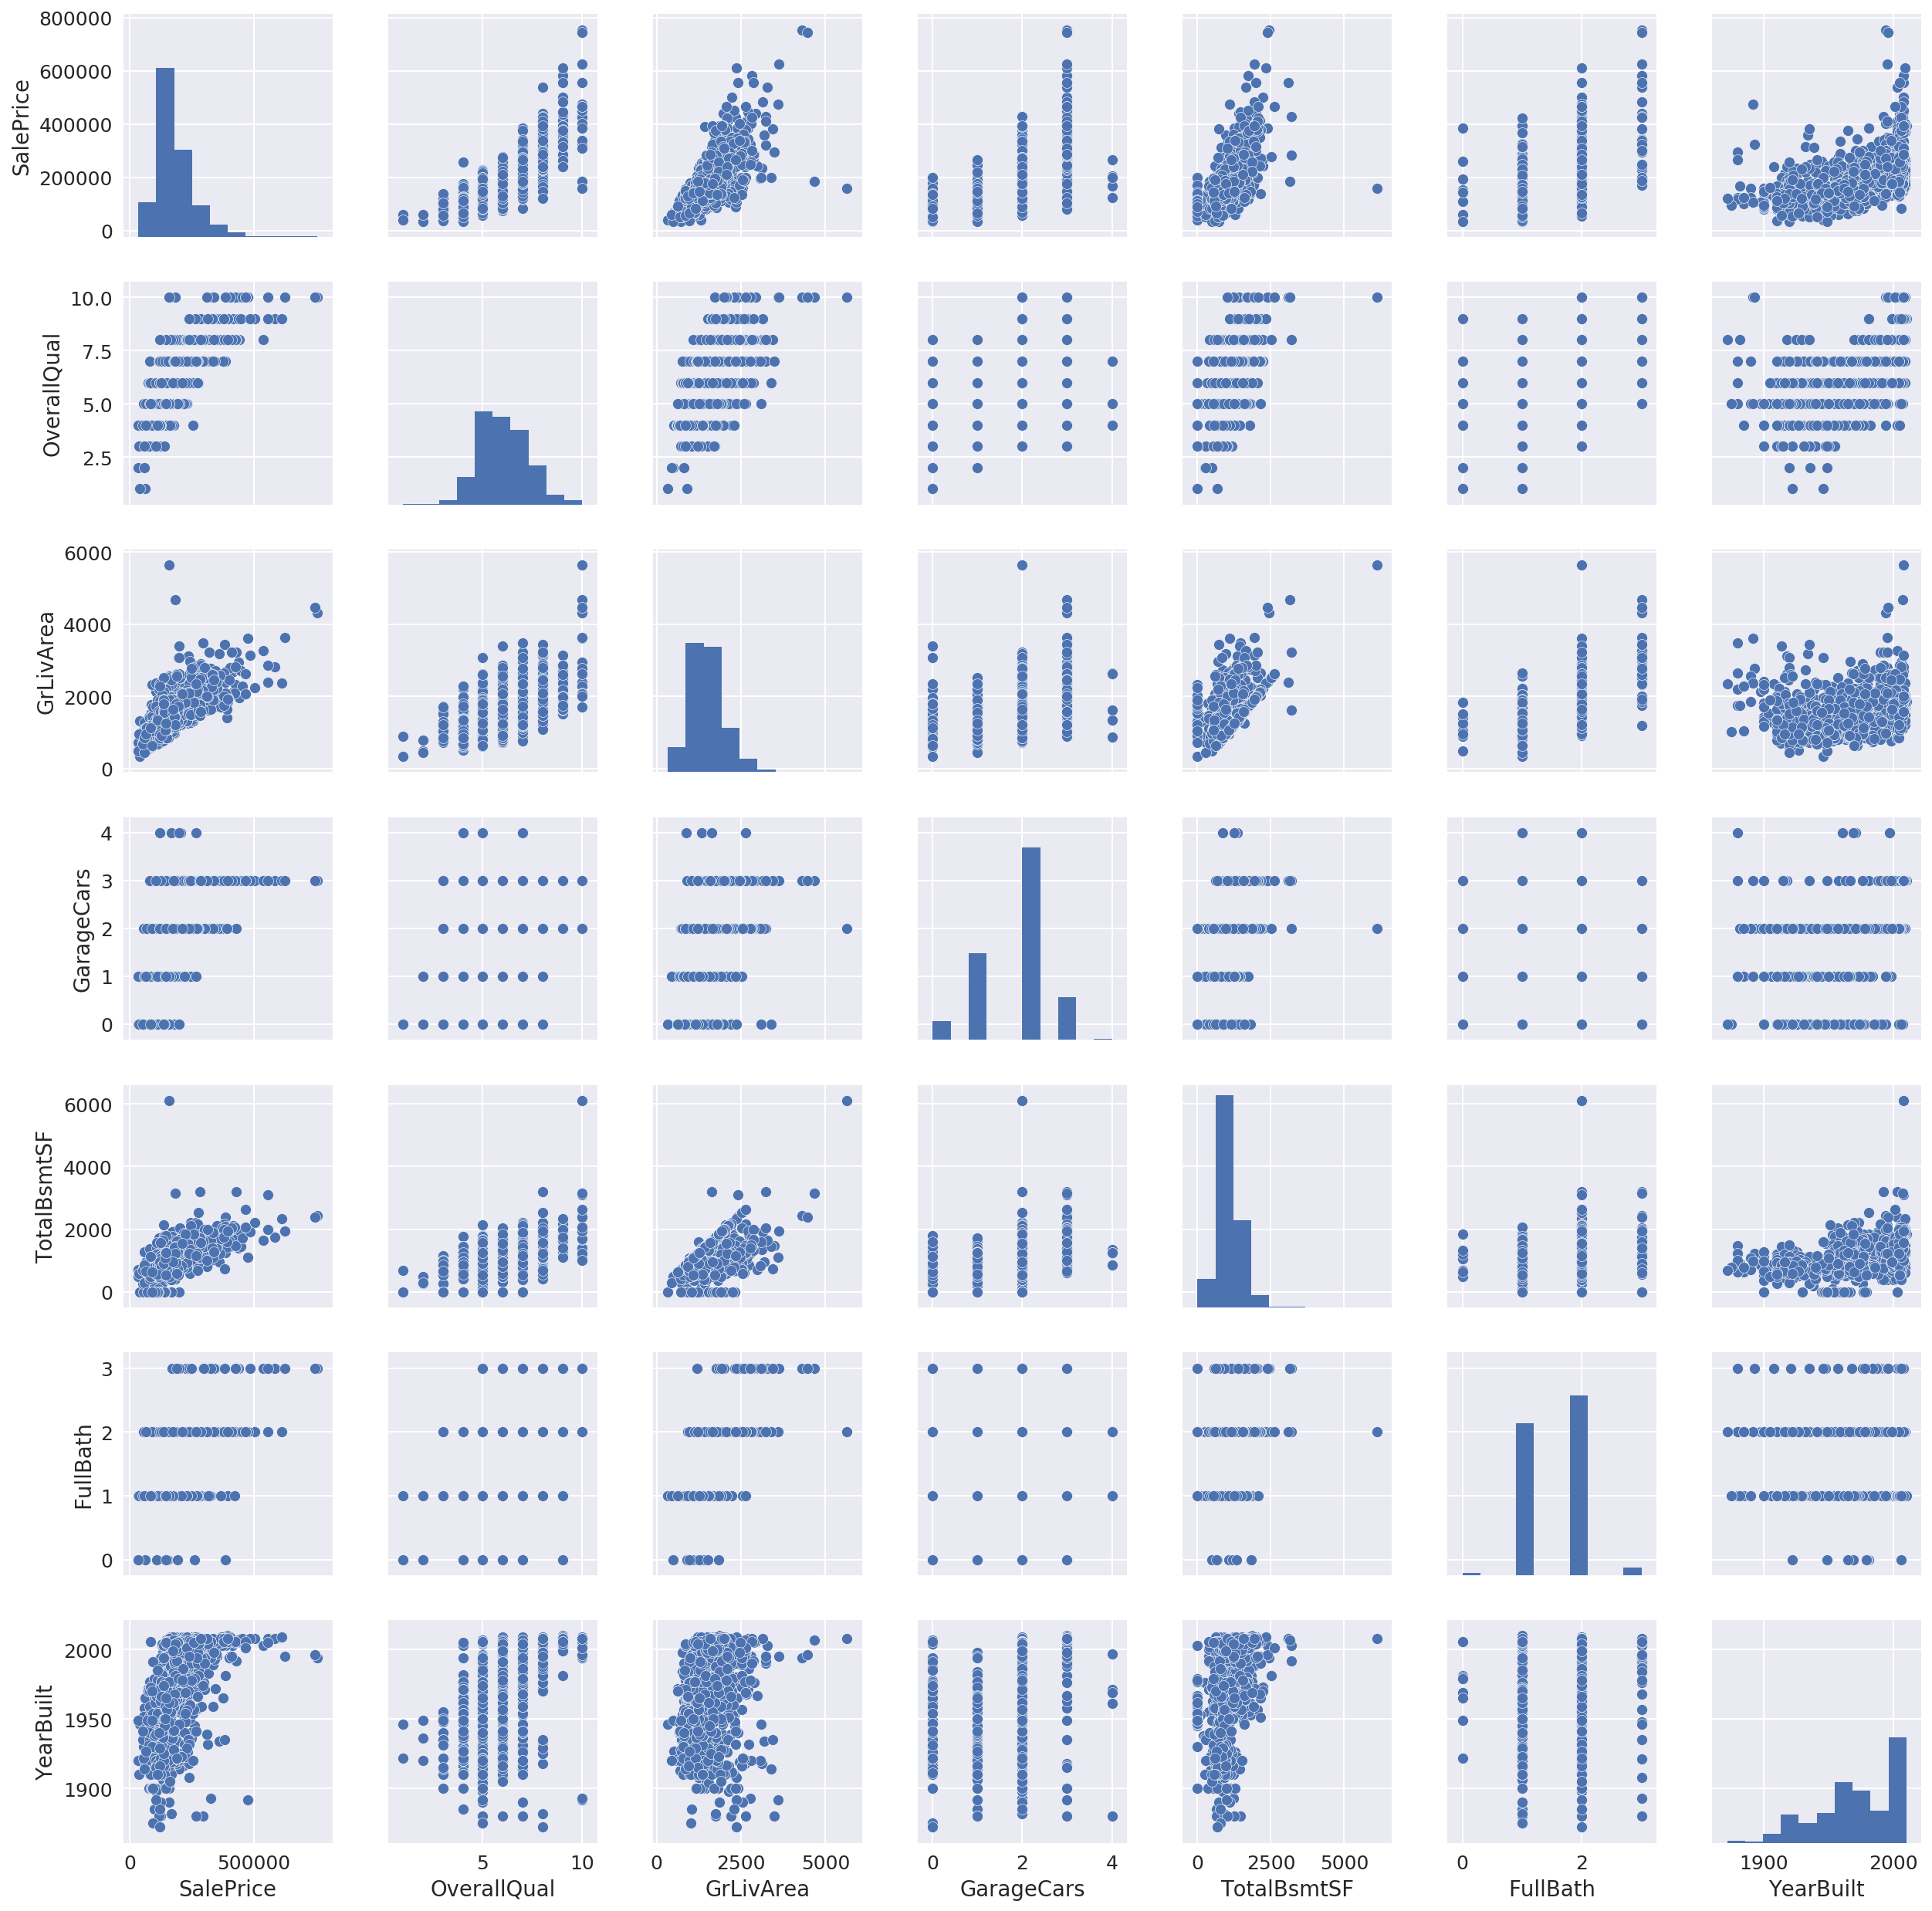

In [29]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [30]:
df.isnull().sum().sum()

0L

## Dealing with outliers

#### I'll use some machine learning for cluster analysis.
    Instead of removing using univariate analysis which I feel doesn't make sense. Outliers should be removed if the relationships that they have with other data do not correlate as much as the norm should be

In [31]:
floatcolumns = [column for column in df.columns if df[column].dtype != object]
floatcolumns.remove('YrSold')
floatcolumns.remove('MoSold')

In [32]:
from sklearn.neighbors import LocalOutlierFactor

In [33]:
Scale = sk.preprocessing.StandardScaler()


## Local Outlier Factor

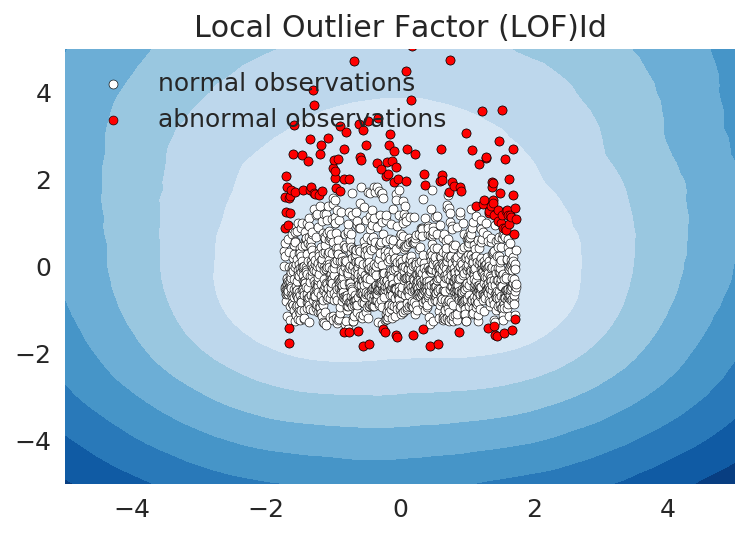

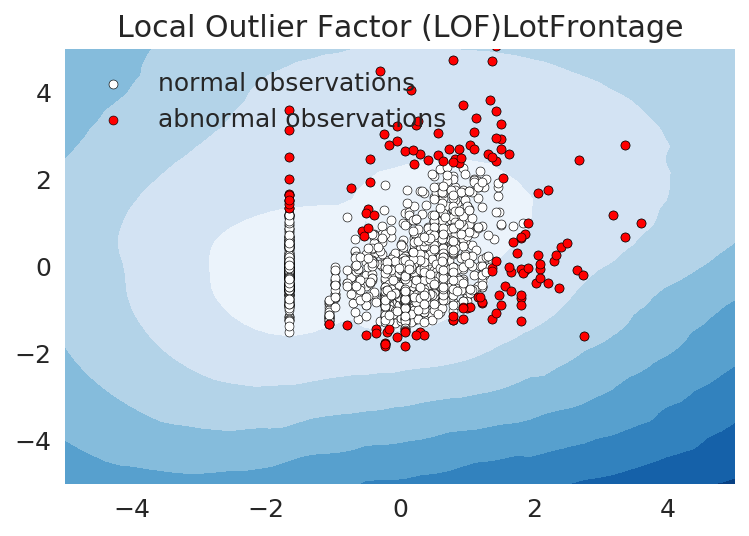

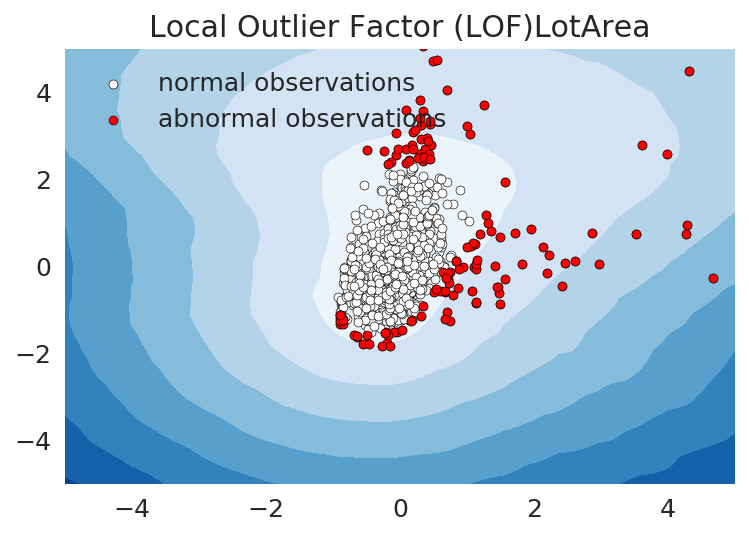

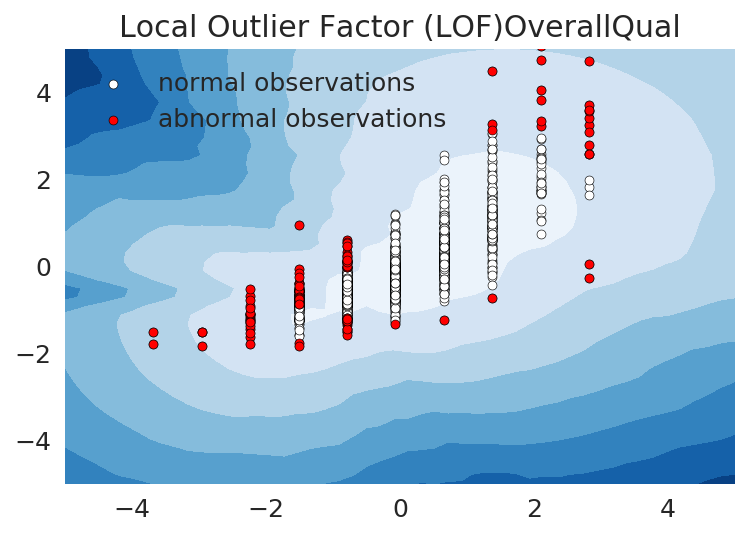

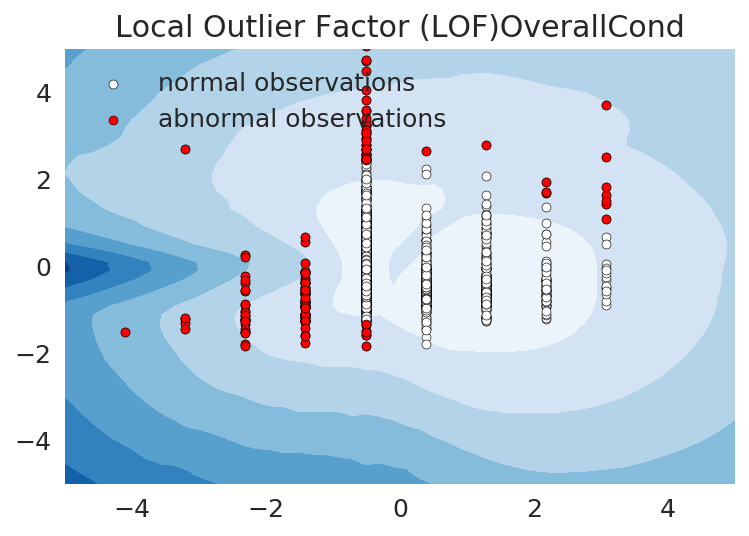

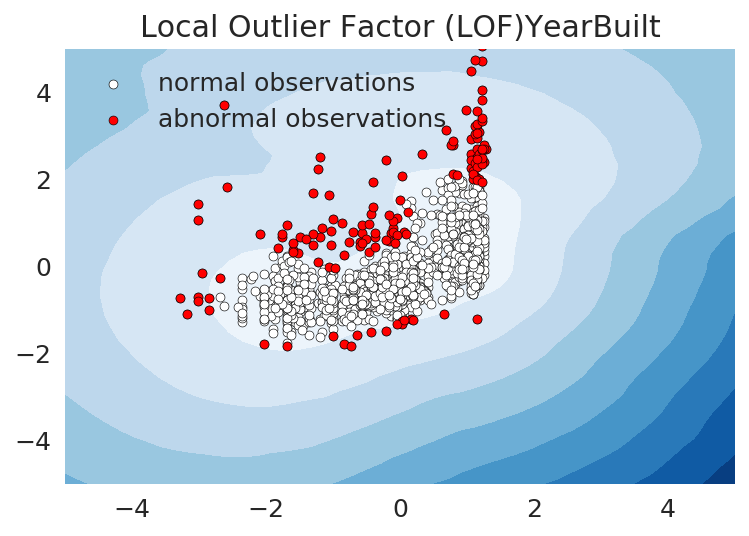

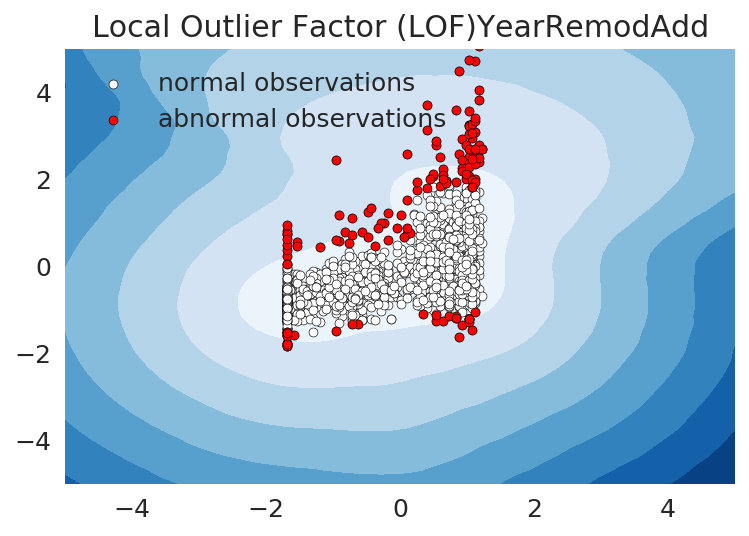

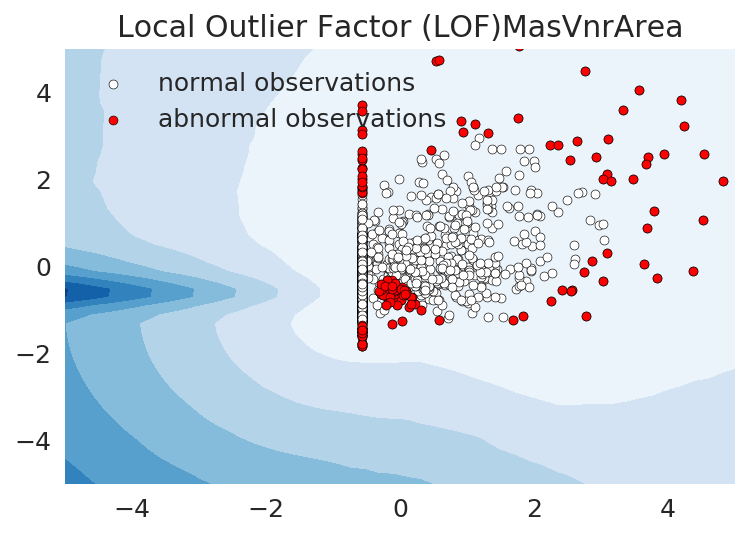

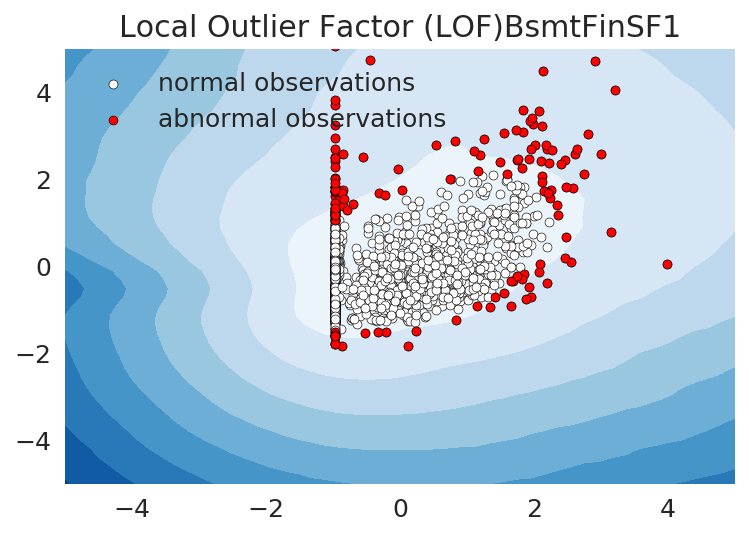

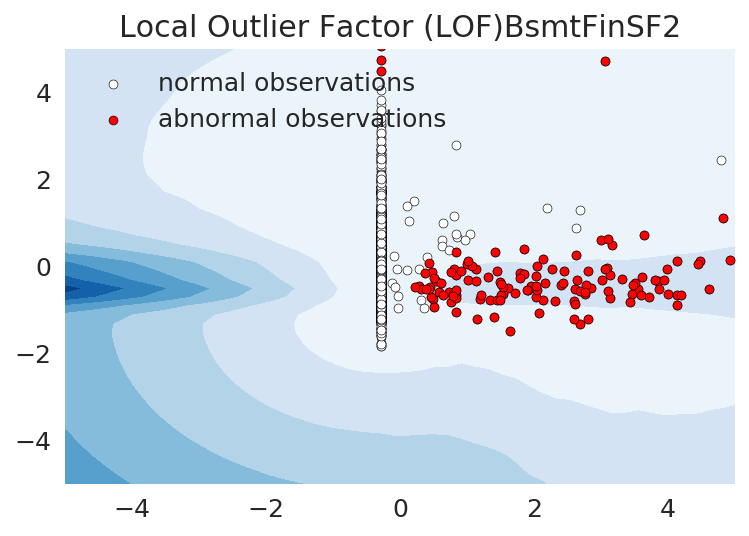

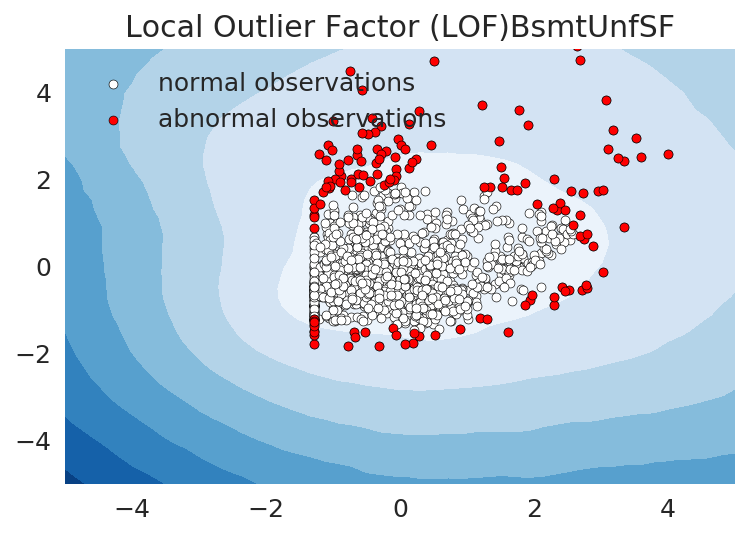

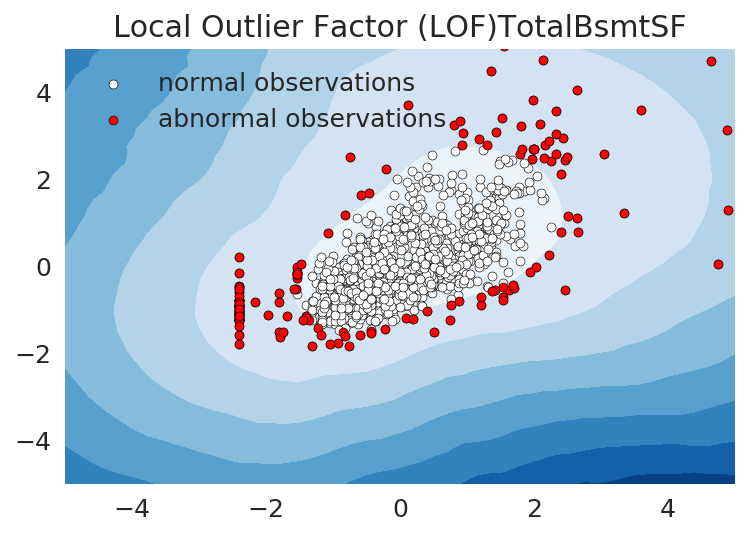

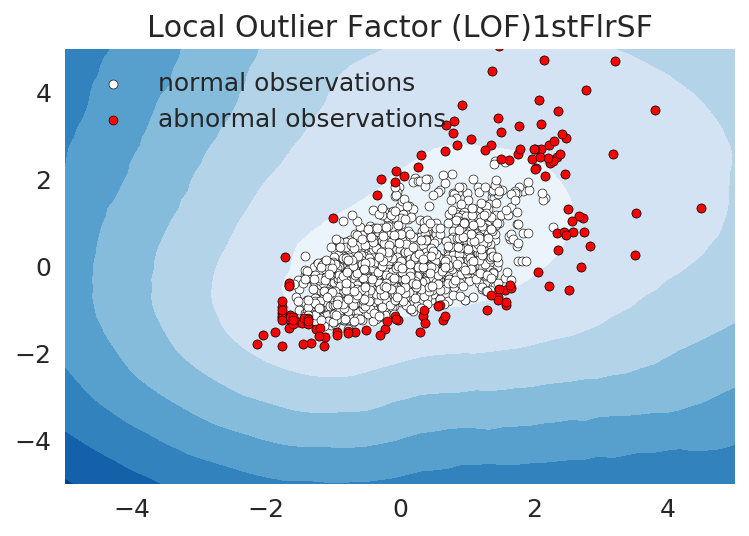

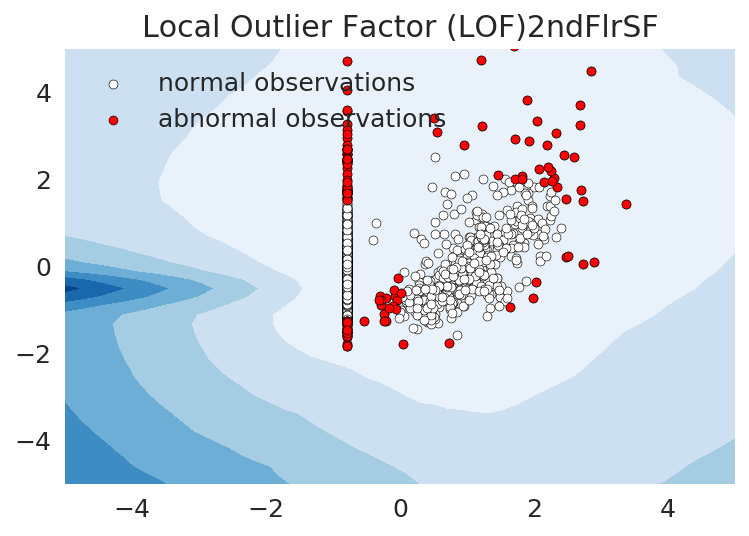

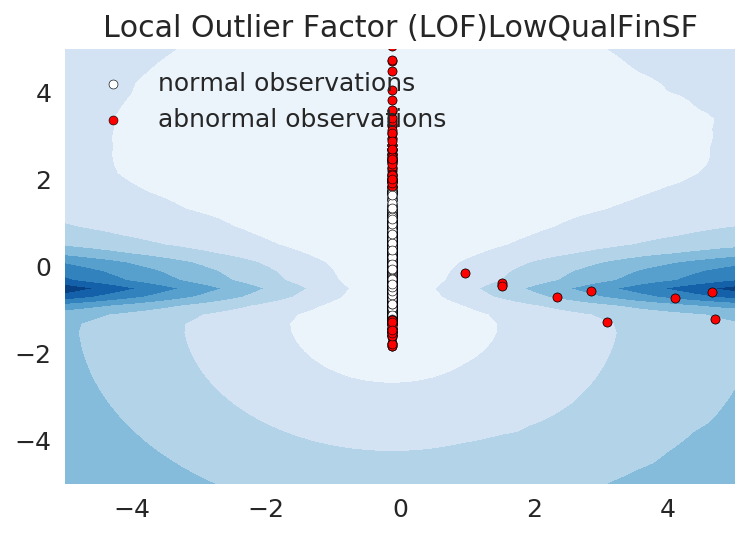

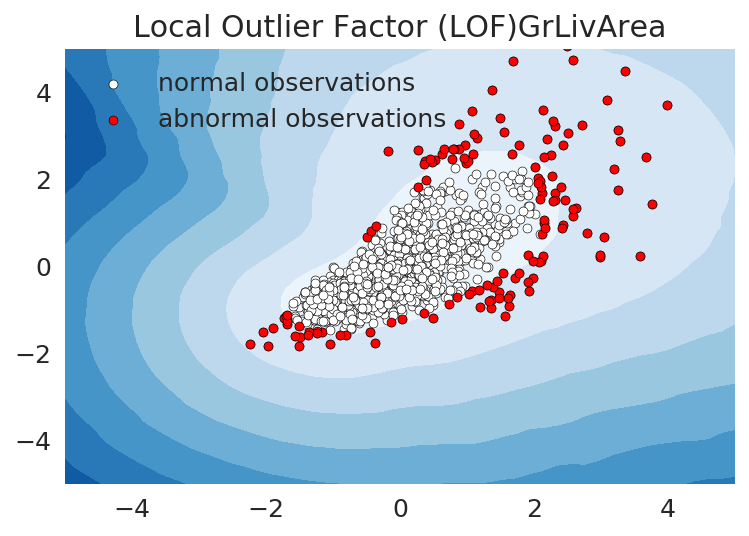

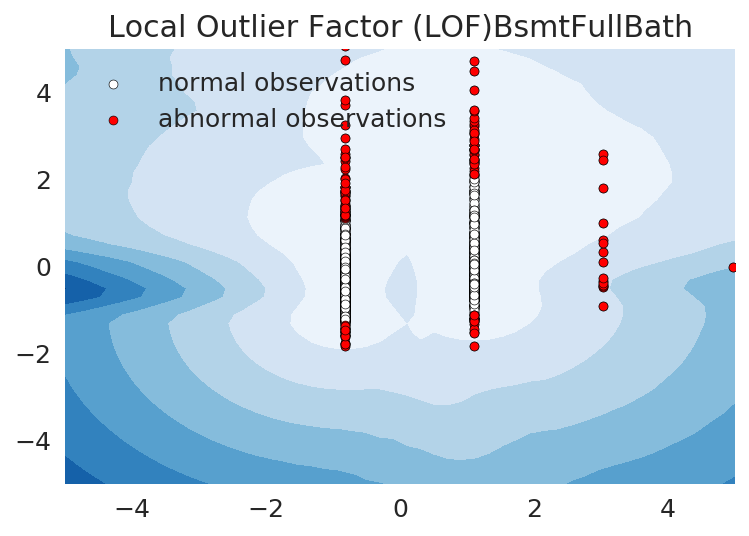

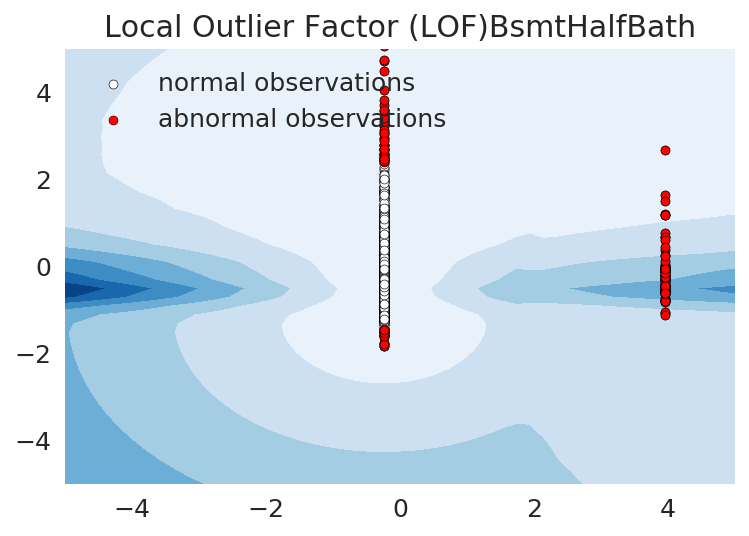

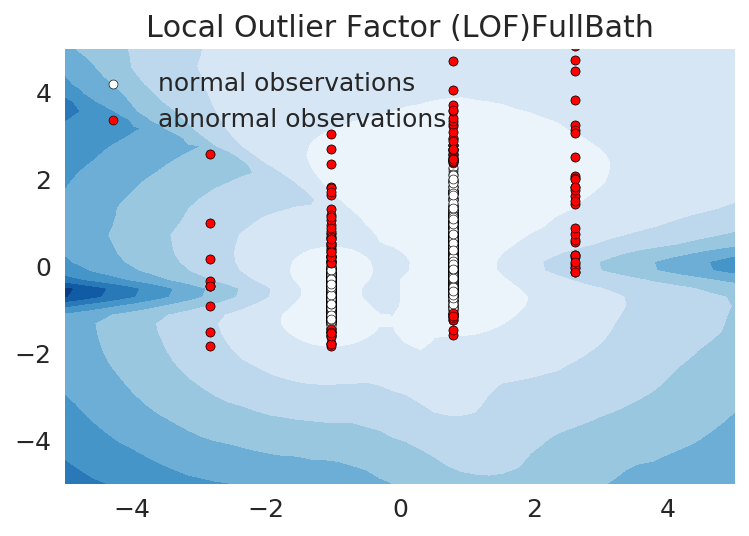

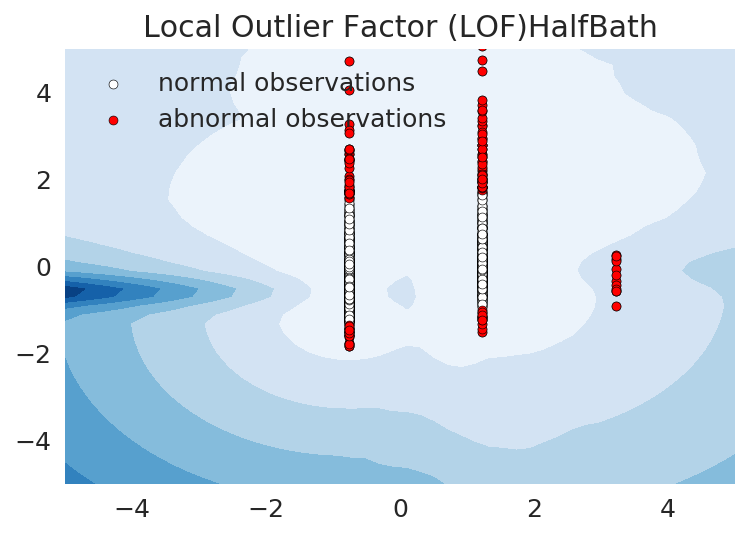

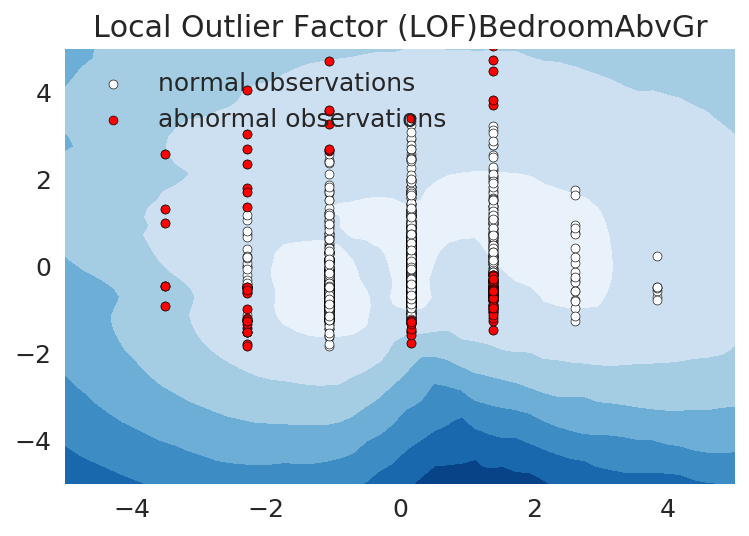

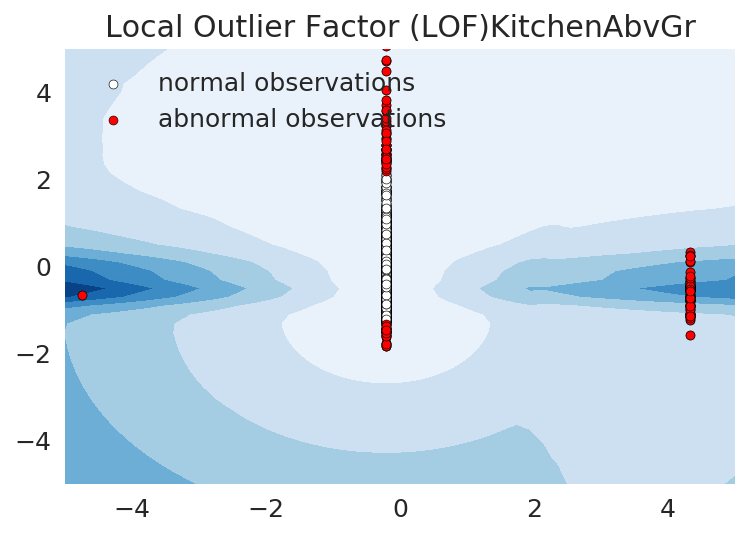

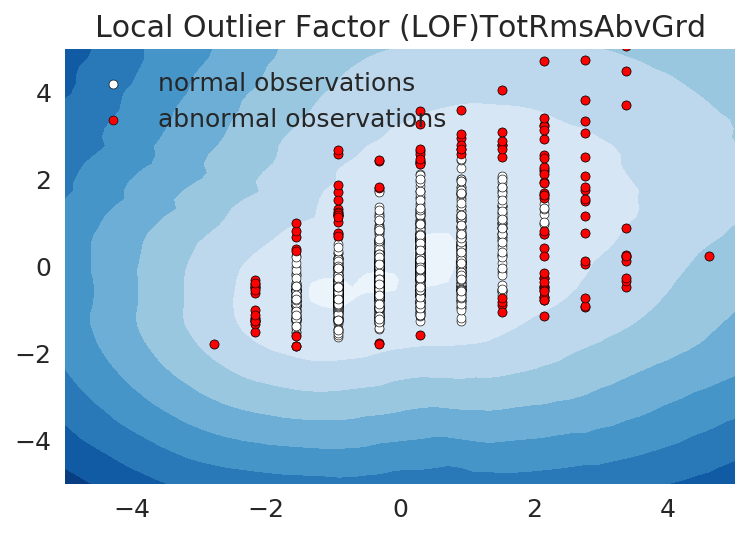

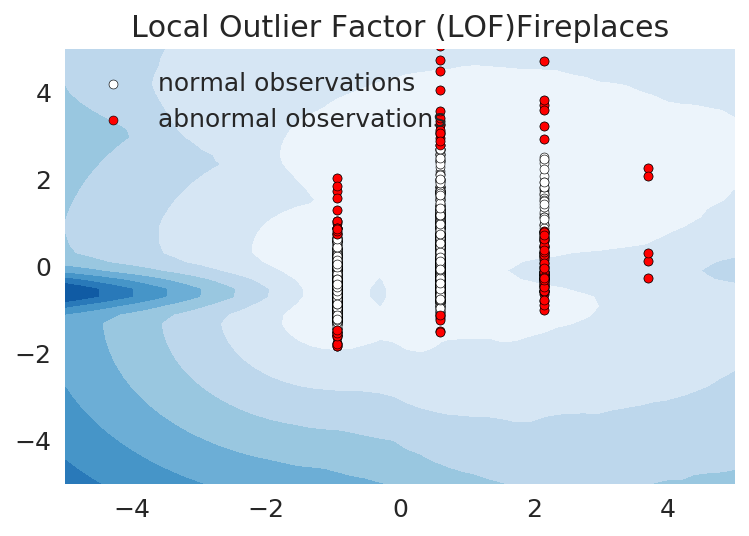

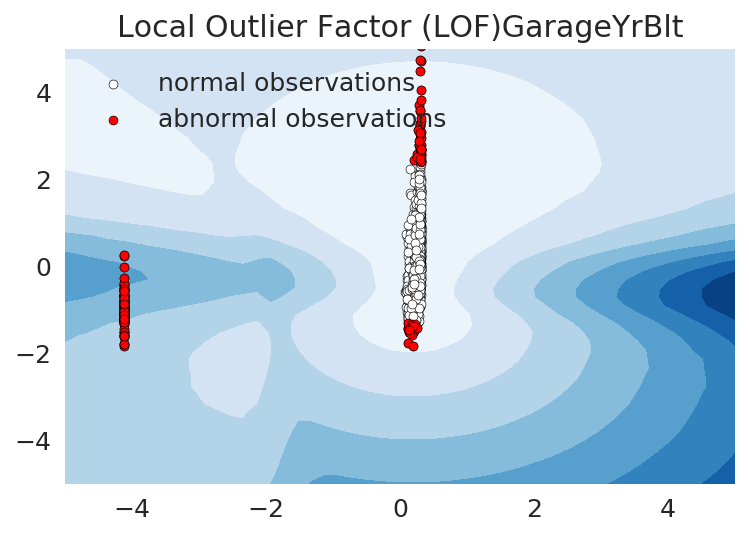

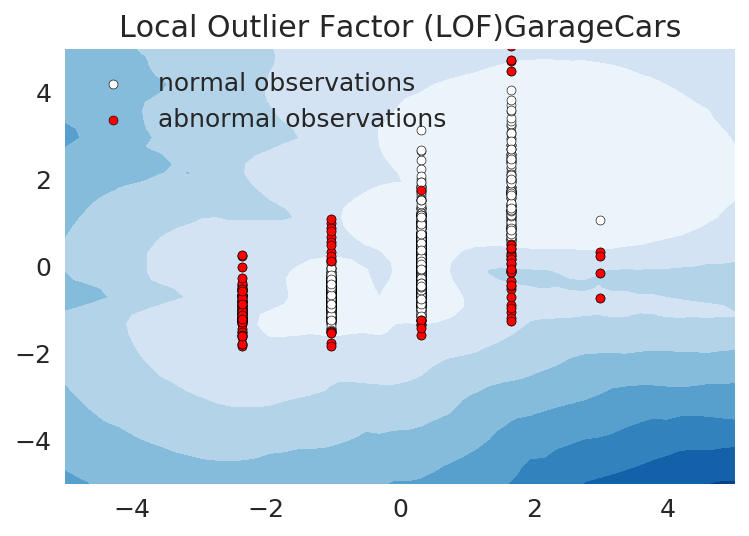

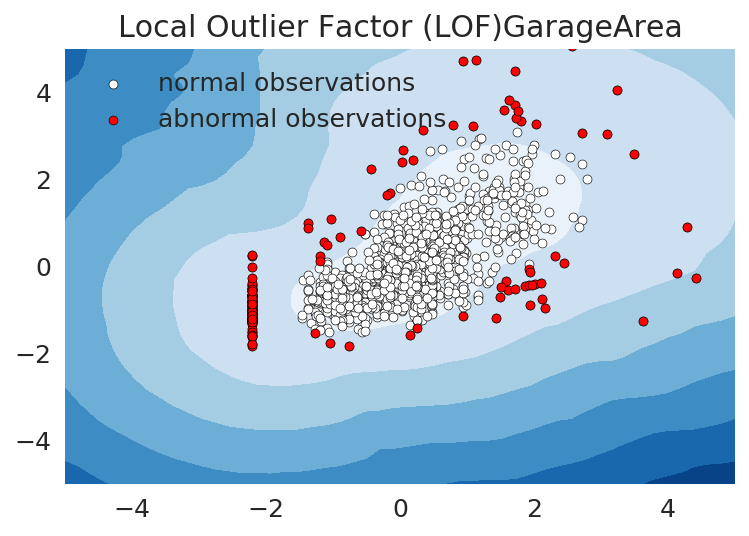

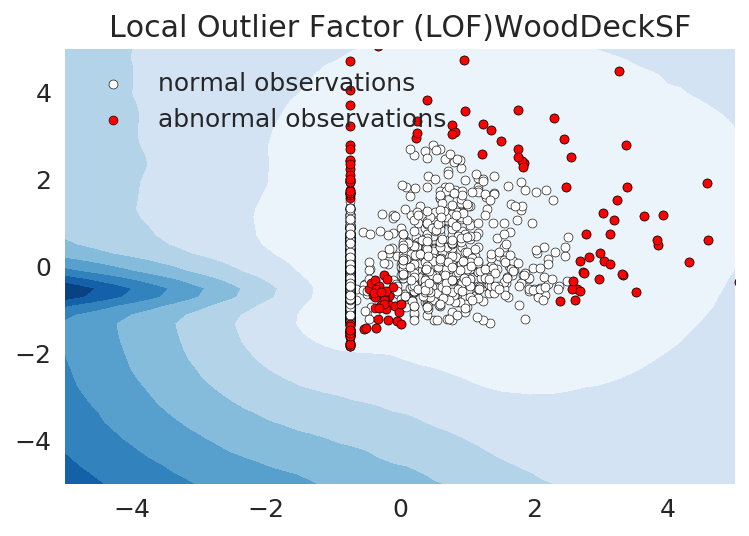

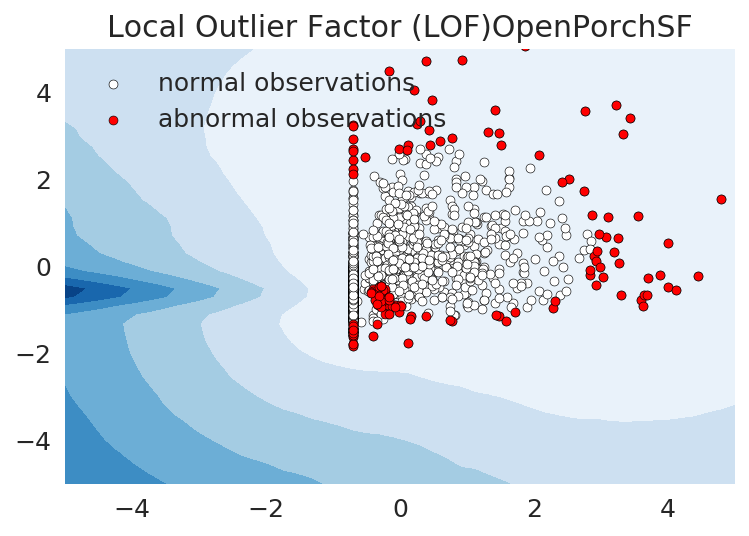

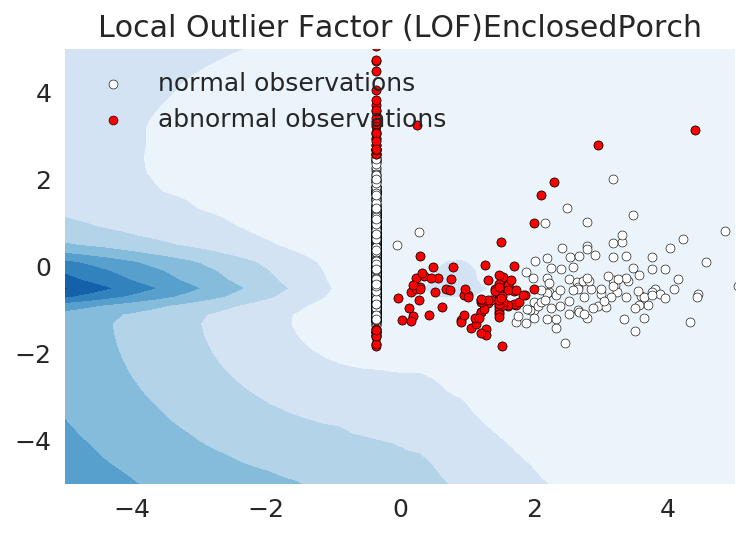

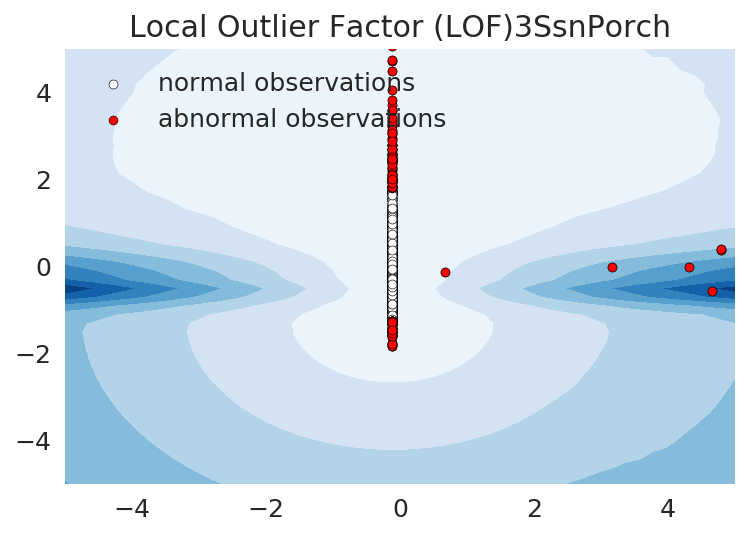

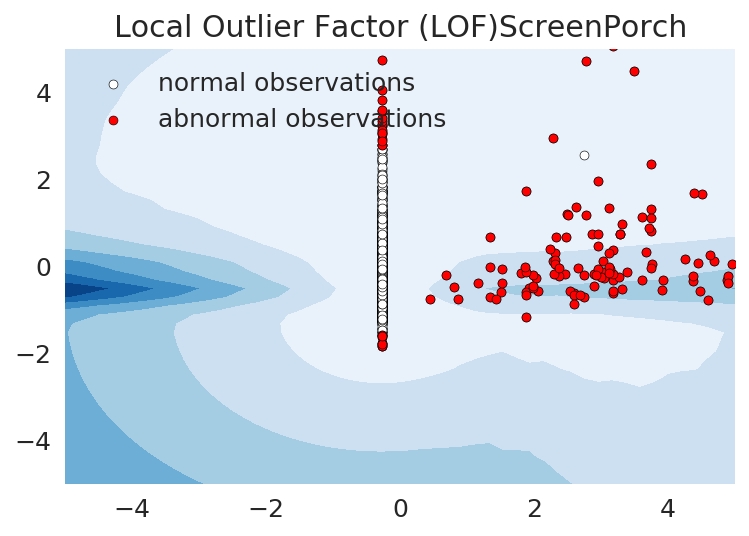

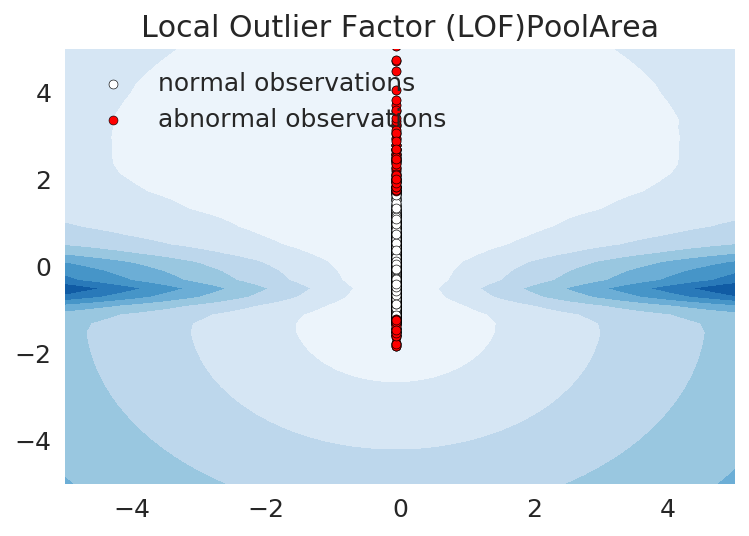

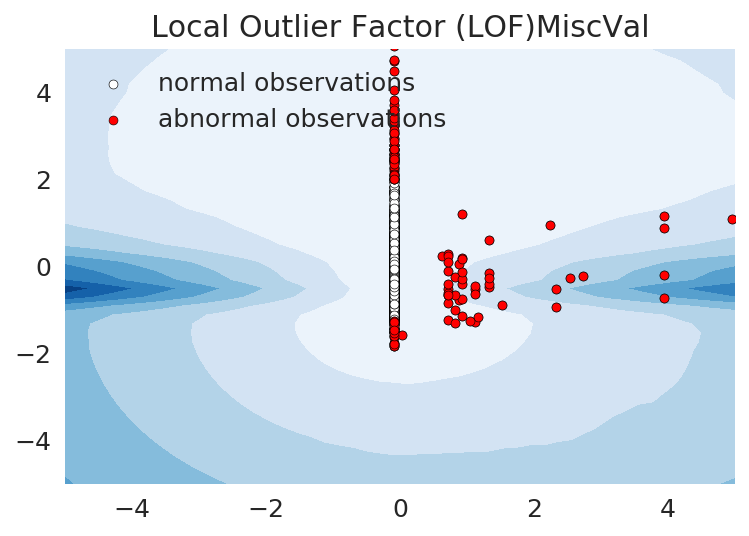

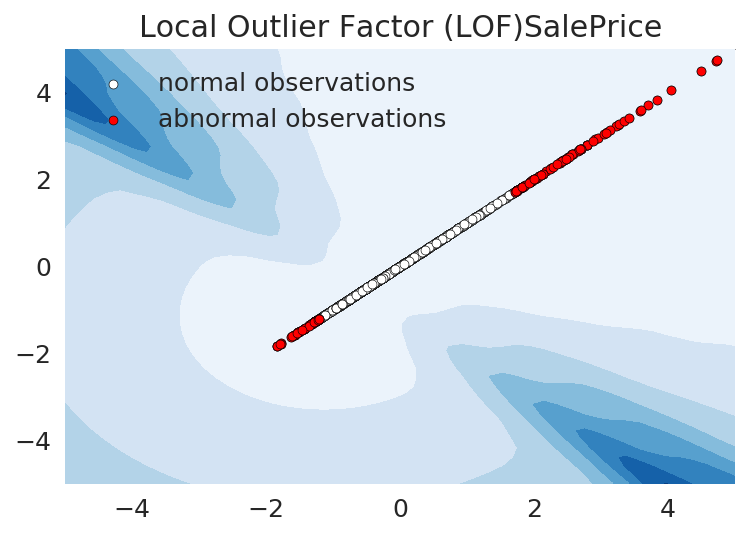

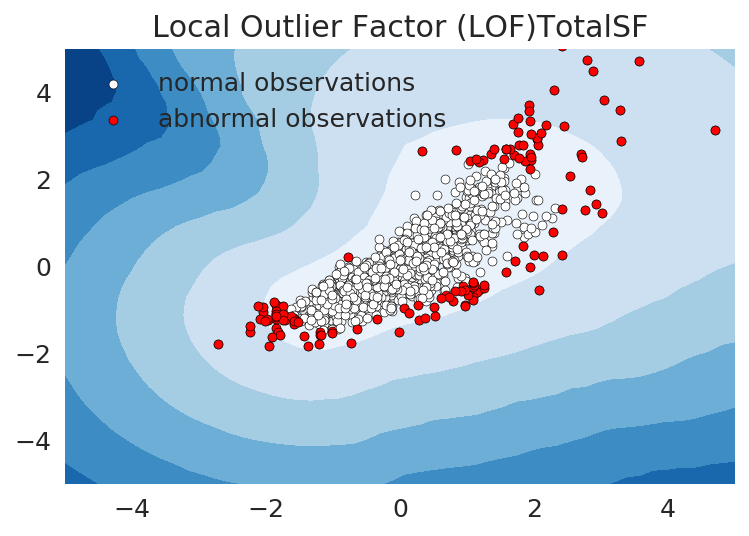

In [34]:
for numeric in floatcolumns:
    Test = df[[numeric,'SalePrice']]
    #Remember to Scale it first
    Scale.fit(Test)
    X = Scale.transform(Test)

   


    clf = LocalOutlierFactor(n_neighbors=200)
    y_pred = clf.fit_predict(X)
    y_pred_outliers = y_pred ==-1
    X_outliers = X[y_pred_outliers]
    # plot the level sets of the decision function
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.title("Local Outlier Factor (LOF)" + str(numeric))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    a = plt.scatter(X[:, 0], X[:, 1], c='white',
                    edgecolor='k', s=20)
    b = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                    edgecolor='k', s=20)
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a, b],
               ["normal observations",
                "abnormal observations"],
               loc="upper left")
    plt.show()

# I tried

## Isolation Forest

In [35]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

Test = df[floatcolumns]
#Remember to Scale it first
Scale.fit(Test)
X = Scale.transform(Test)

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X)
y_pred_train = clf.predict(X)



In [36]:
y_pred_train
Notoutliers = y_pred_train == 1
outliers = y_pred_train == -1

In [37]:
y_pred_train[Notoutliers] = 0

y_pred_train[outliers] =1

In [38]:
df['Outlier'] = y_pred_train

In [39]:
df['Outlier'].value_counts()

0    1314
1     146
Name: Outlier, dtype: int64

In [40]:
df.loc[df['Outlier'] ==1].index

Int64Index([   7,   39,   48,   53,   58,   70,   78,   88,   93,   99,
            ...
            1350, 1353, 1373, 1386, 1387, 1417, 1437, 1449, 1450, 1457],
           dtype='int64', length=146)

### To remove or not to remove?

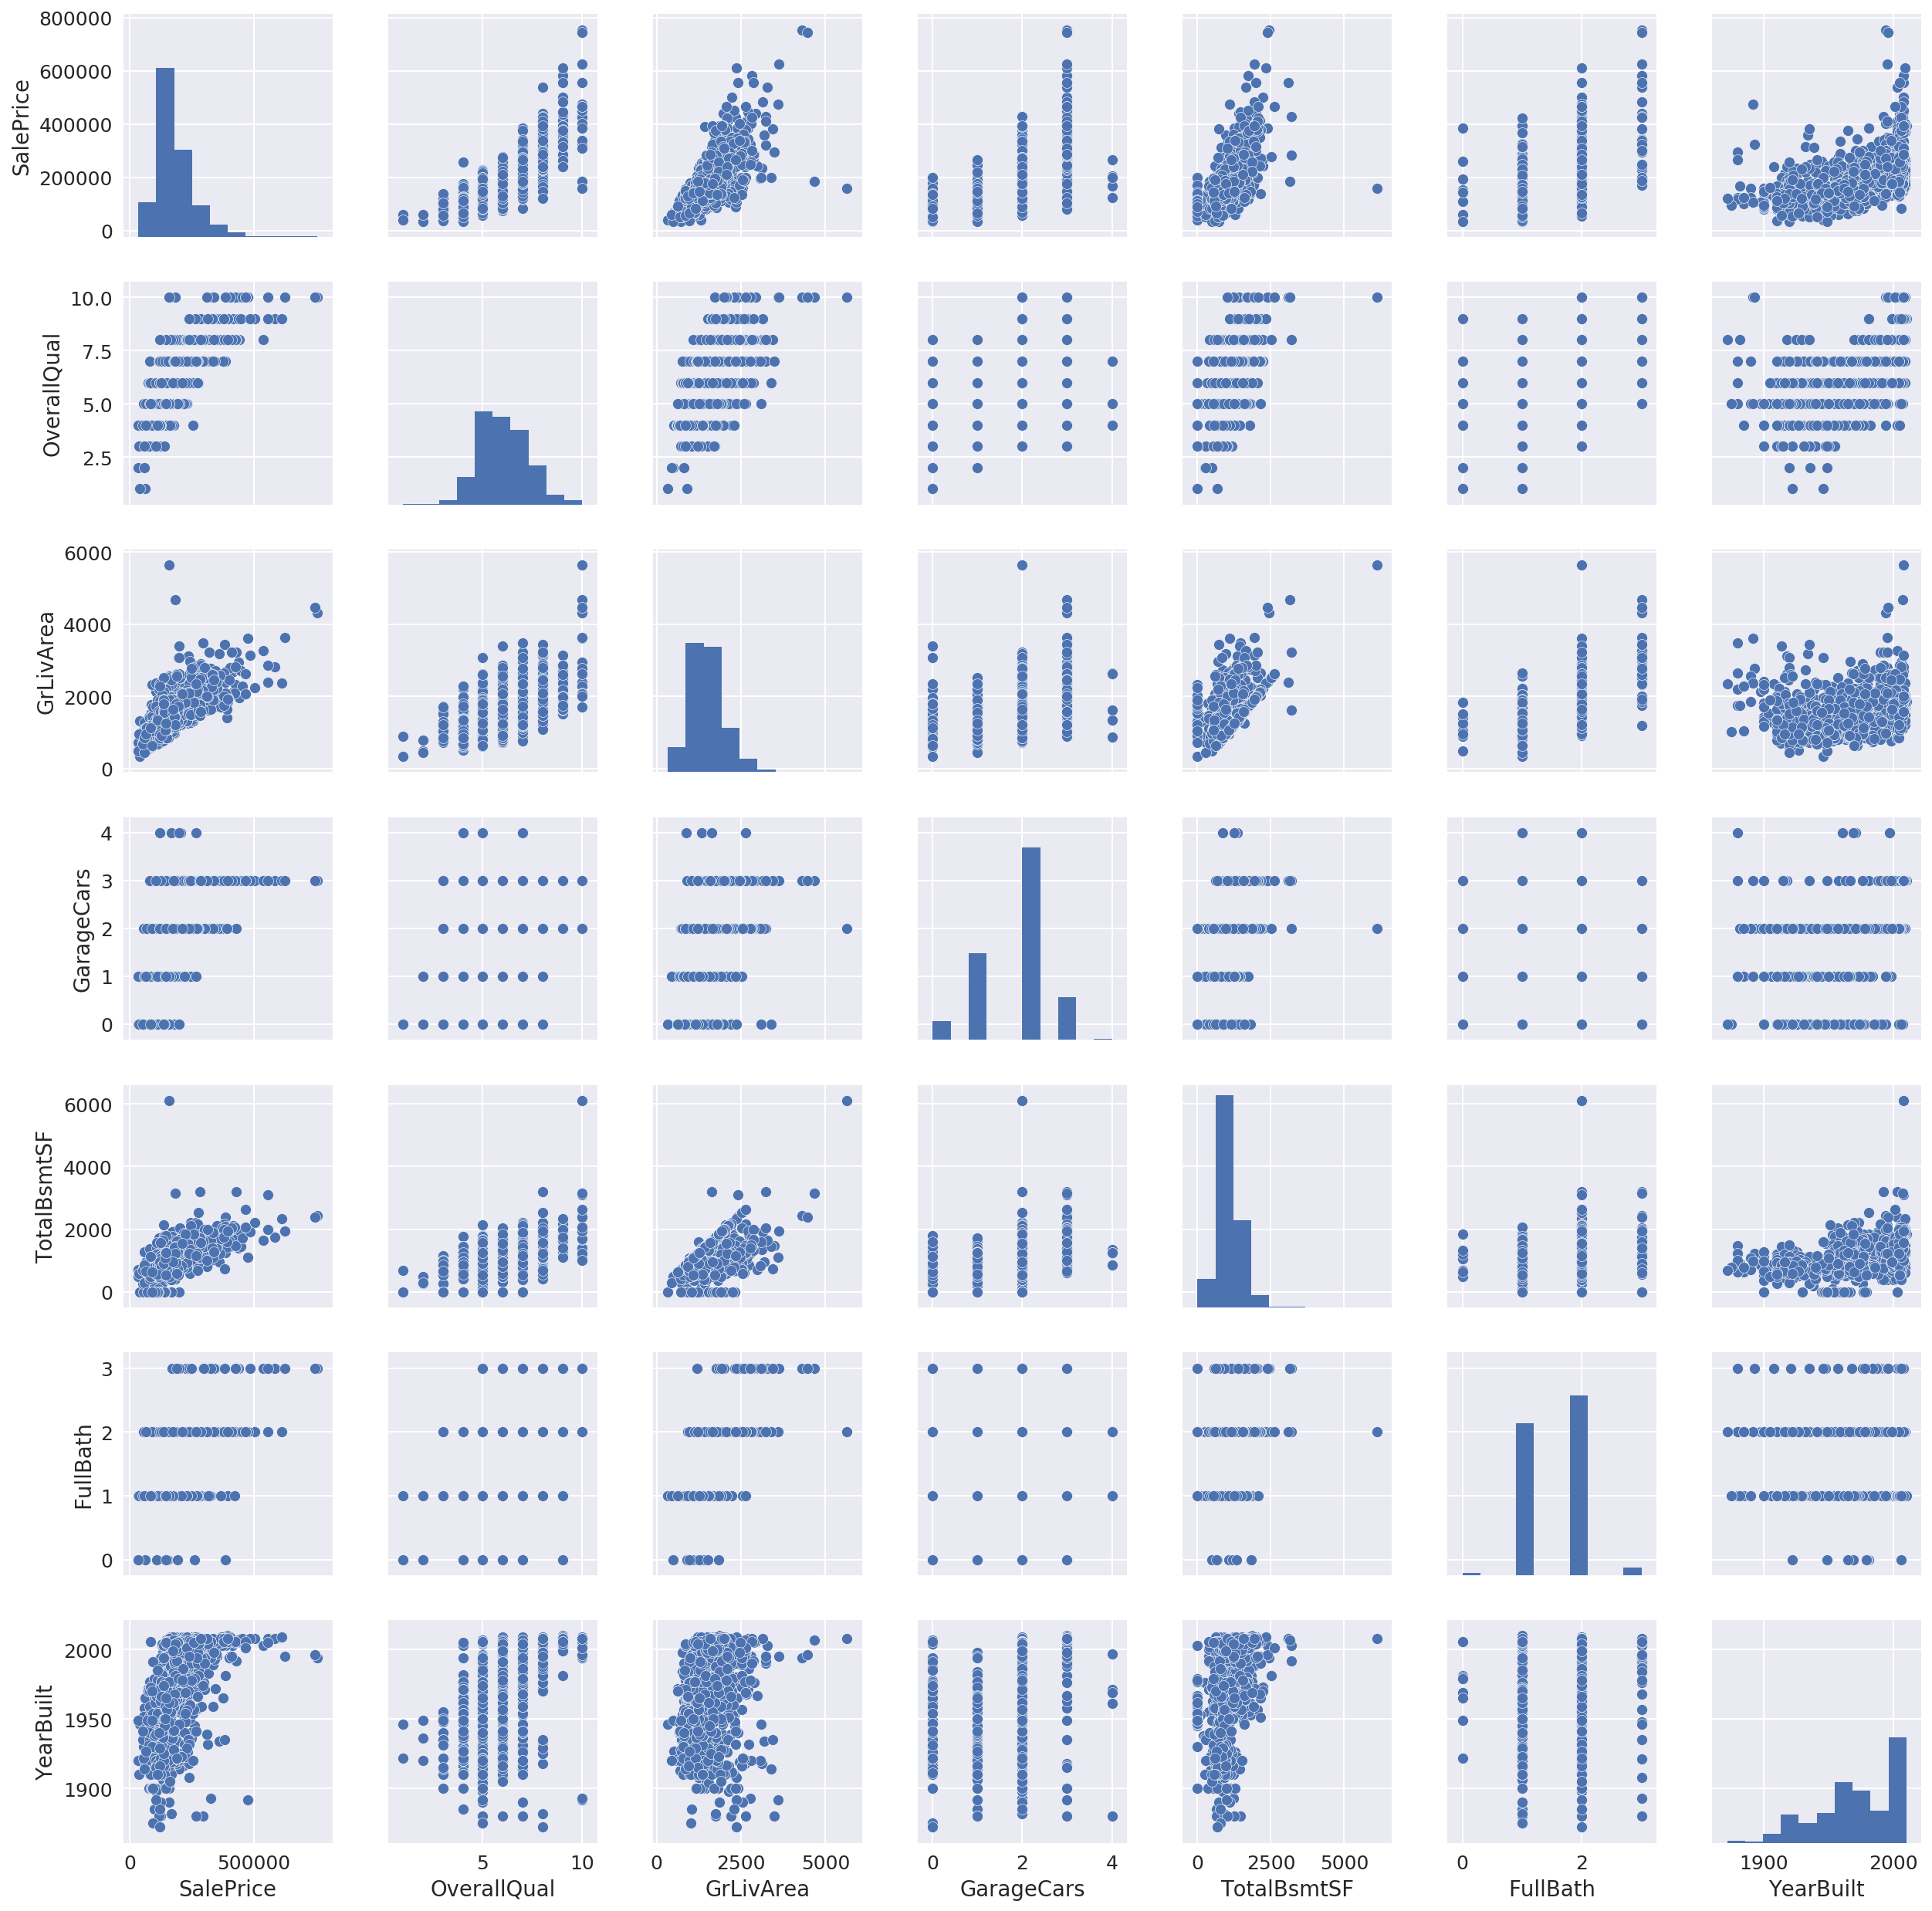

In [41]:
sns.pairplot(df[cols], size = 2.5)

#### Without outliers

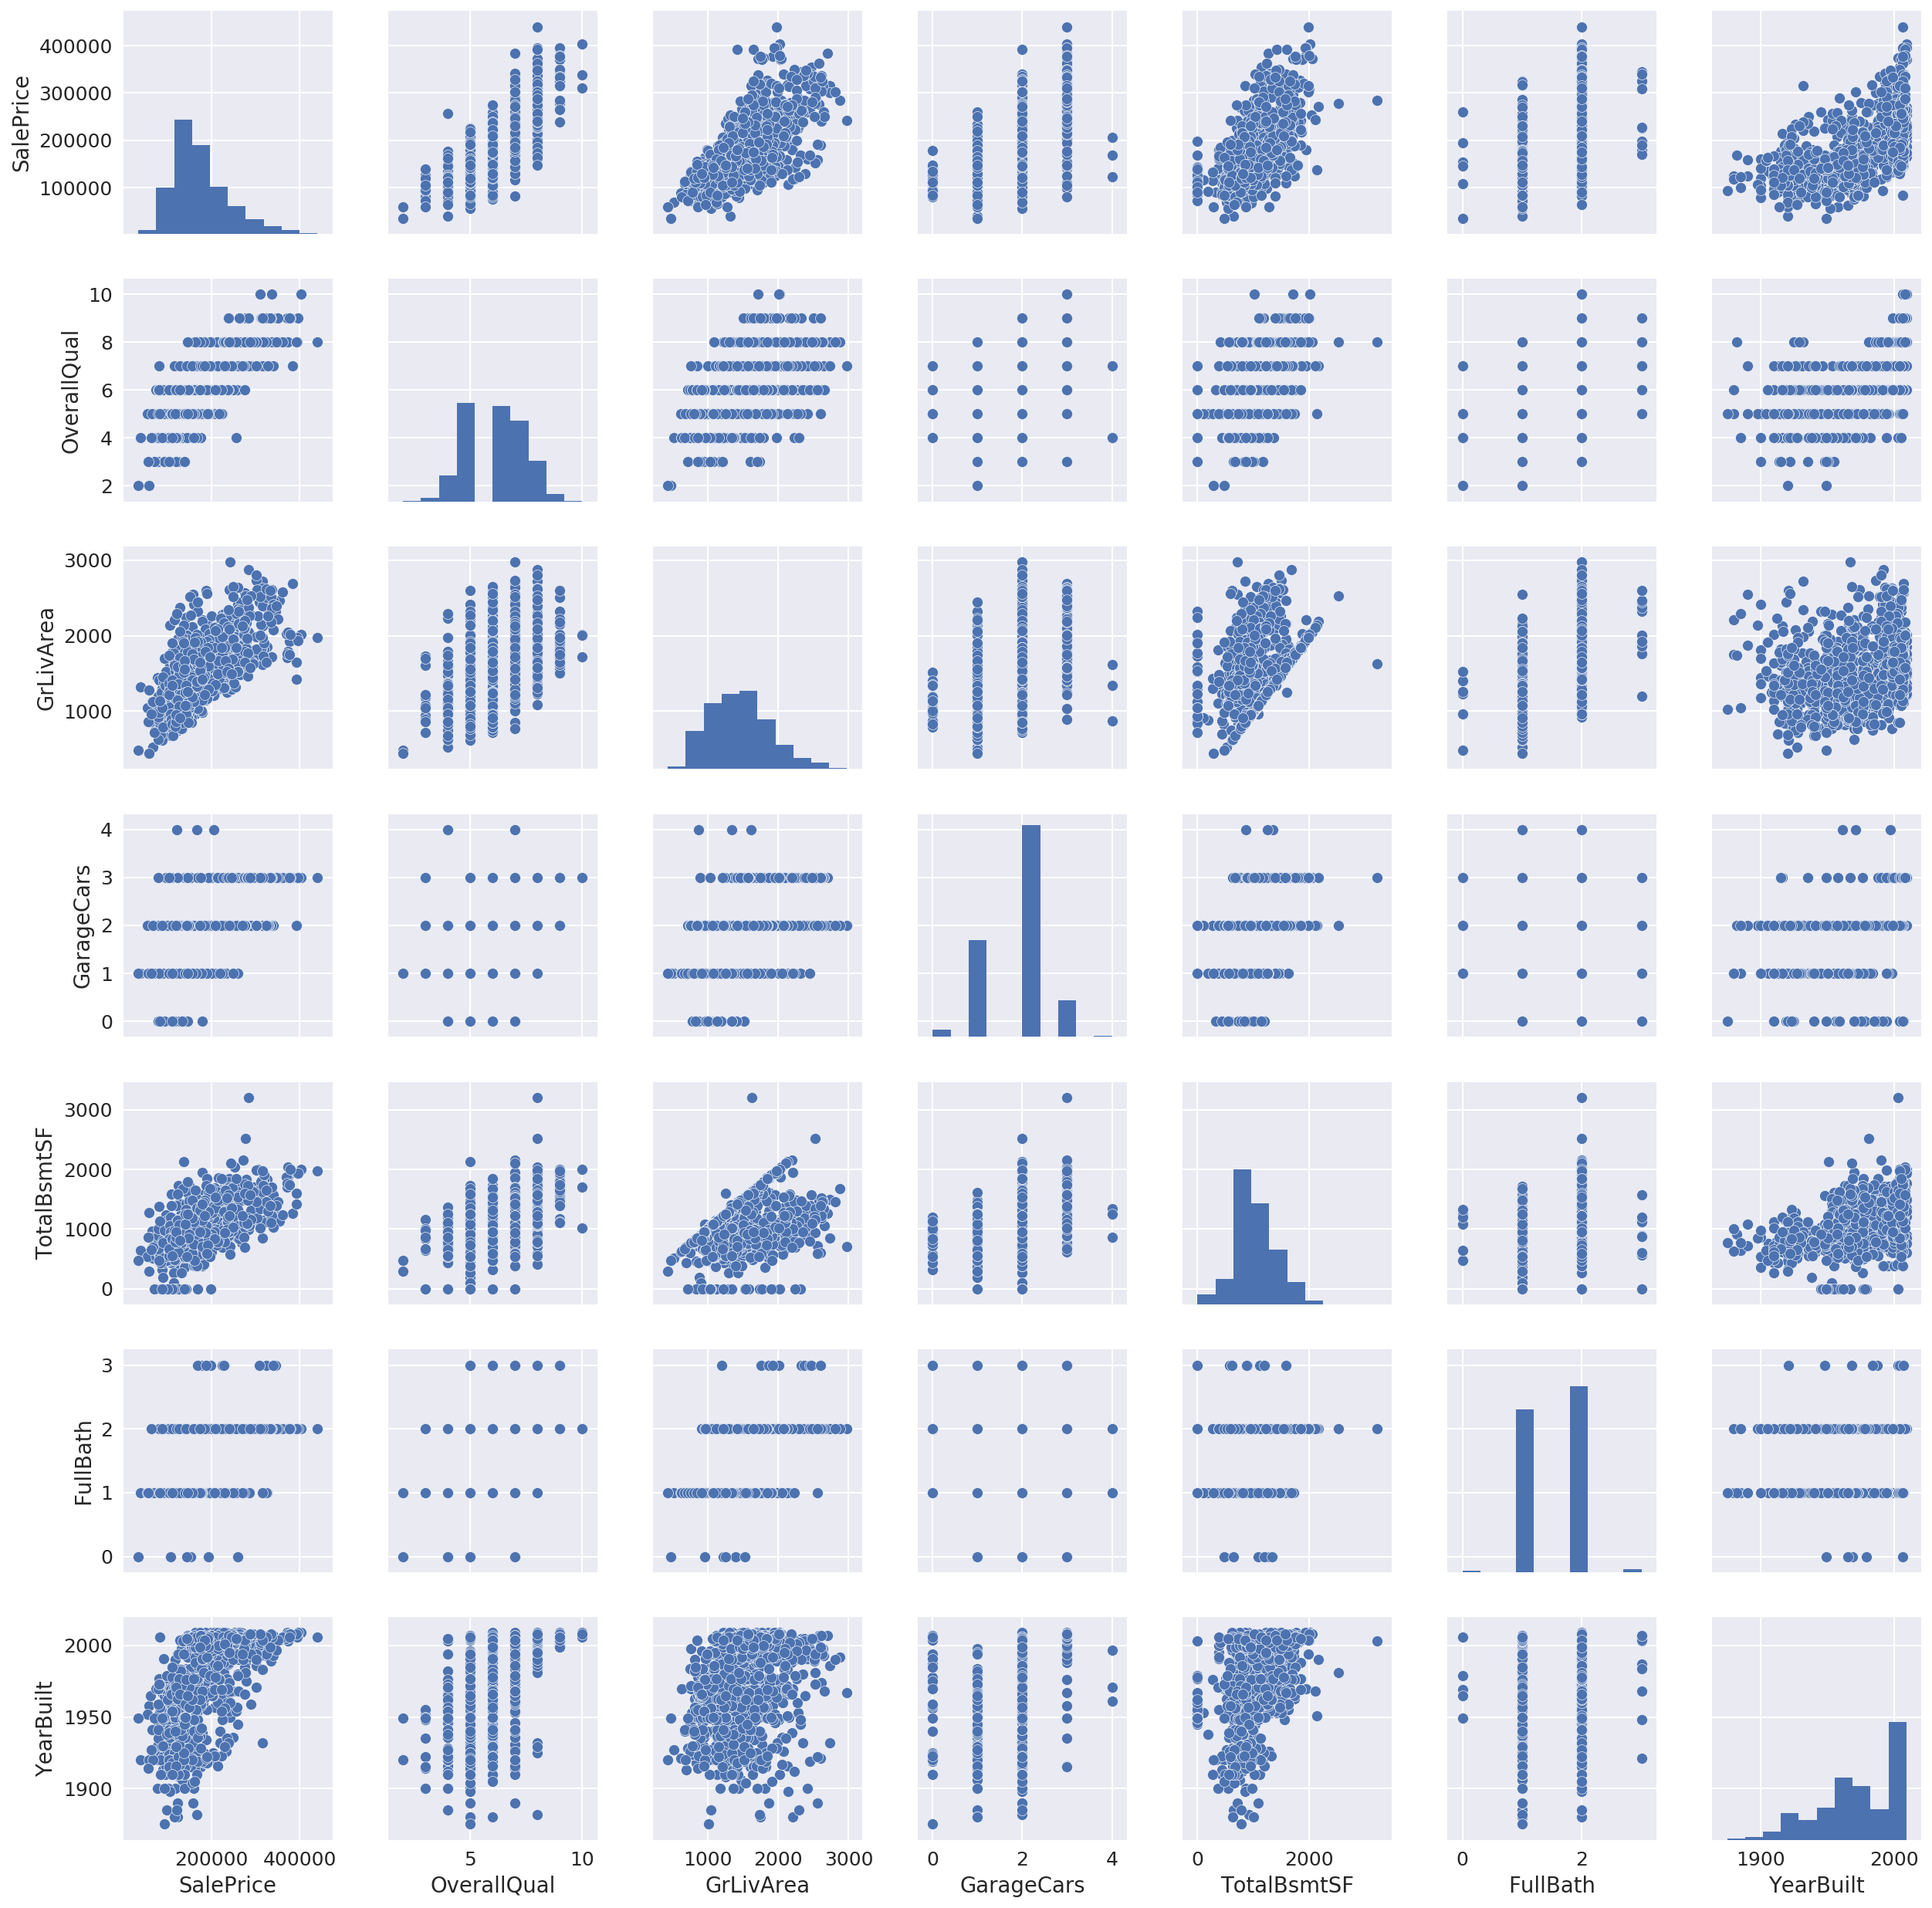

In [42]:
sns.pairplot(df.drop(df.loc[df['Outlier'] ==1].index)[cols],size=2.5)

In [43]:
df_o= df.drop(df.loc[df['Outlier'] ==1].index)

In [44]:
datasets = [df,df_o]

## Bivariate Analysis

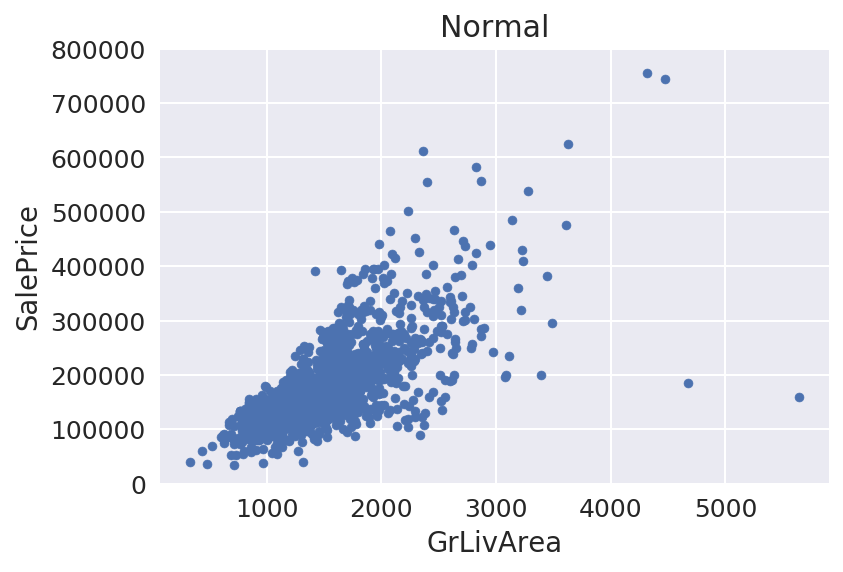

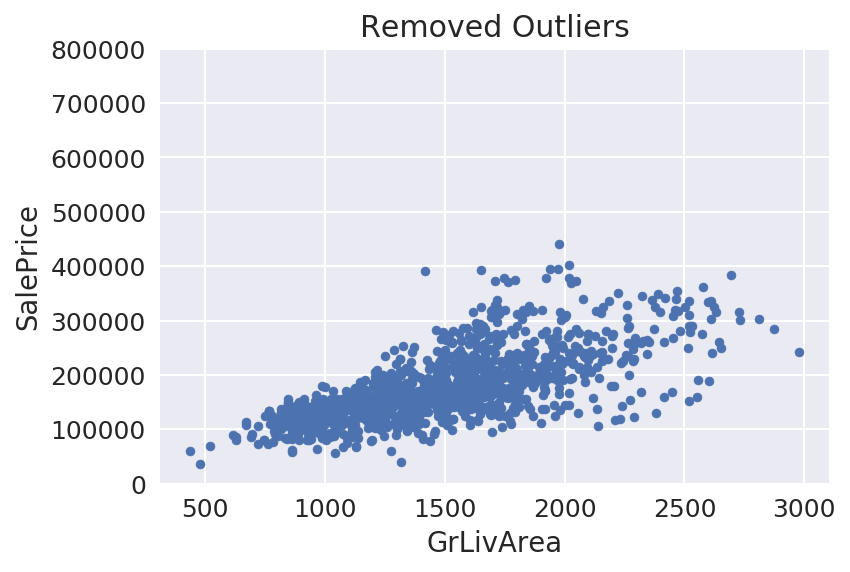

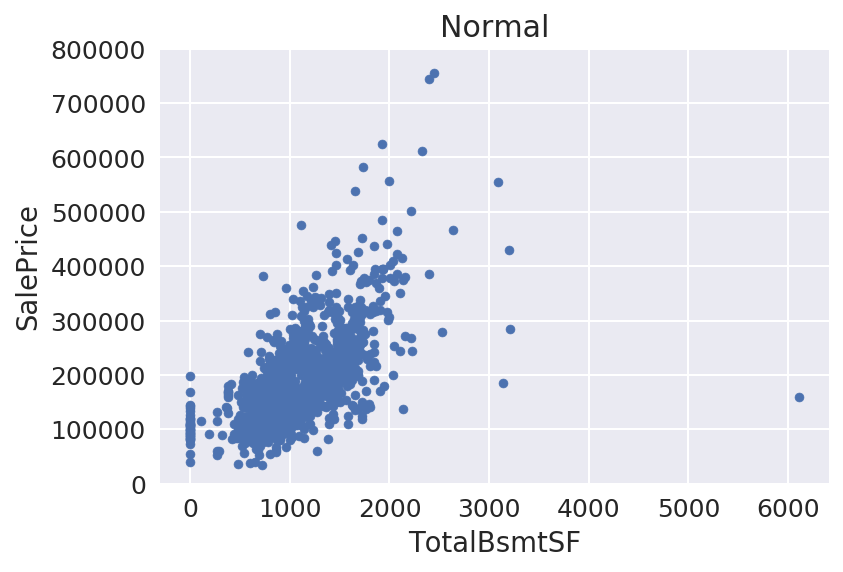

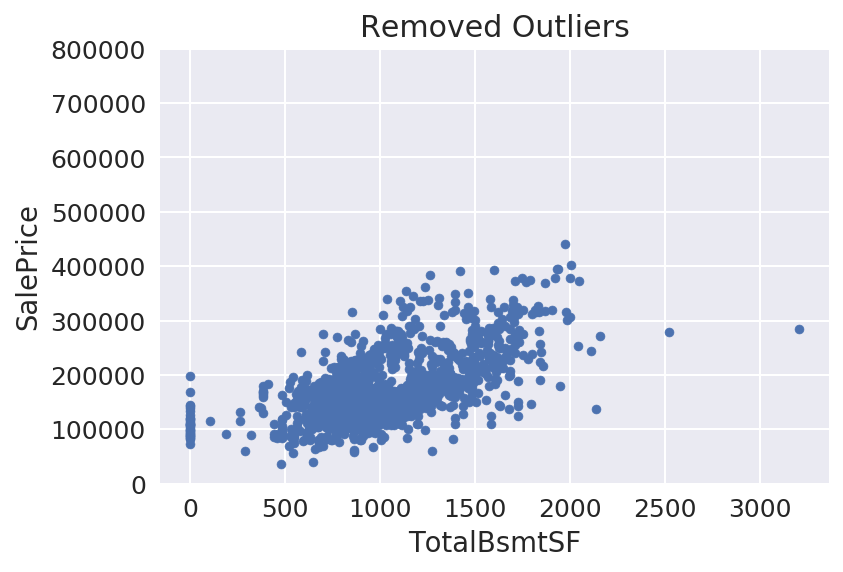

In [45]:

highcorr = ['GrLivArea','TotalBsmtSF']
for var in highcorr:
    for dataset ,title in zip(datasets,['Normal',"Removed Outliers"]):

        data = pd.concat([dataset['SalePrice'], dataset[var]], axis=1)
        data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
        plt.title(str(title))
        plt.show()
        

### Define NotCategorical

In [46]:
NotCategorical = [notcategorical for notcategorical in df.columns if notcategorical not in categorical]

NotCategorical.remove("Outlier")

In [47]:
df.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1         60       RL         65.0     8450   Pave  None      Reg   
1   2         20       RL         80.0     9600   Pave  None      Reg   
2   3         60       RL         68.0    11250   Pave  None      IR1   
3   4         70       RL         60.0     9550   Pave  None      IR1   
4   5         60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7    

## Fixing Skewness of Data

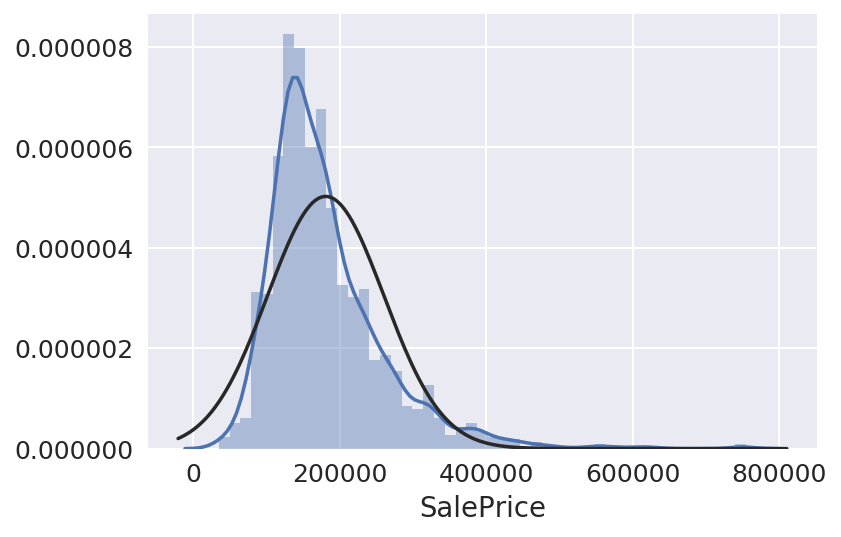

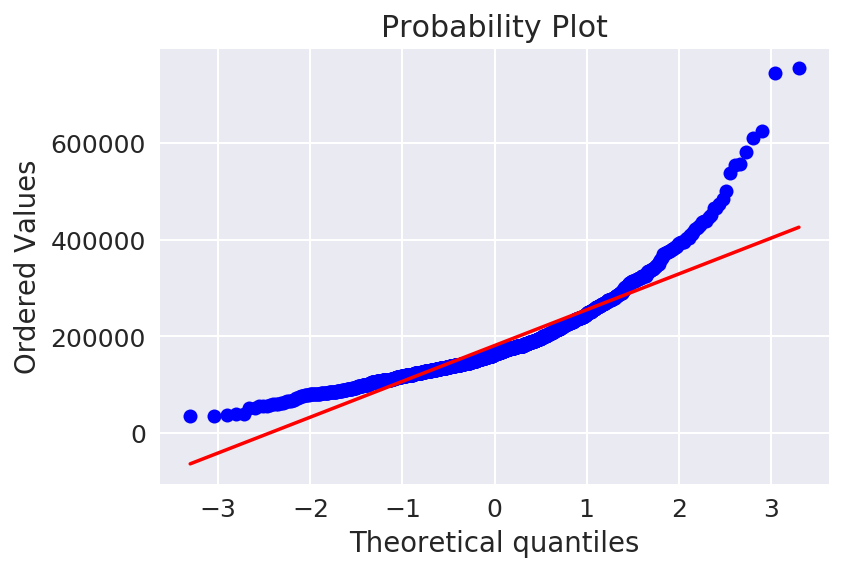

In [48]:
sns.distplot(df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

In [49]:
def fixskew(dataframe,column):
    dataframe[column]=np.log(dataframe[column])
    #defensive programming
    #Fix in case if it was turned from 0 to infinity(some columns have data which has a lot of 0)
    dataframe.loc[(dataframe[column] ==float("+inf") ) | (dataframe[column] ==float("-inf")),column] =0
    
    return dataframe

In [50]:
for dataframe in datasets:
    for nt in NotCategorical:
        dataframe = fixskew(dataframe,nt)

/home/nasdin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


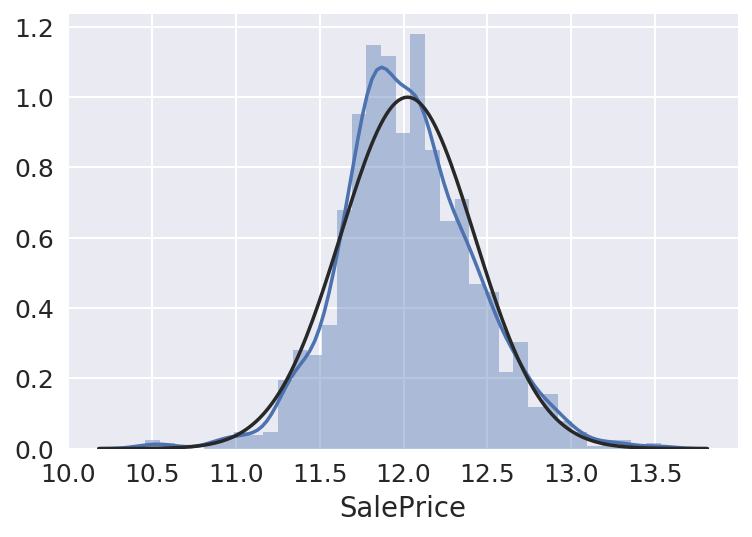

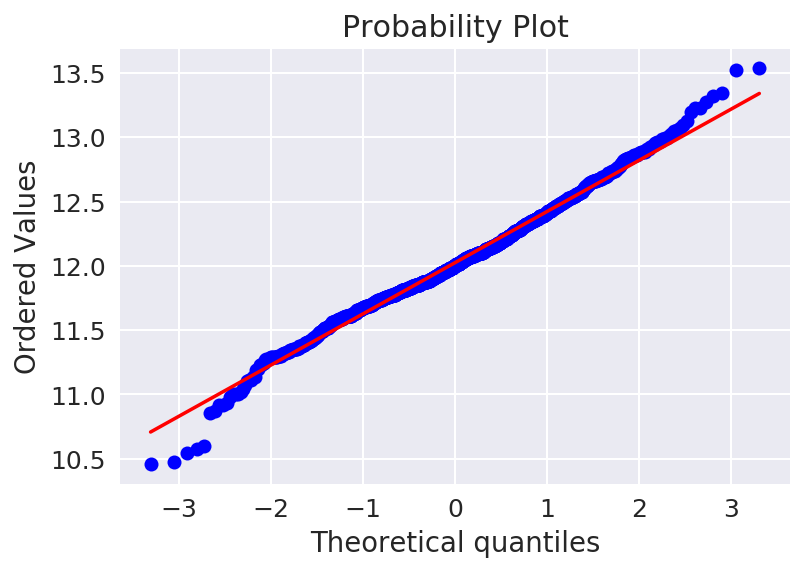

In [51]:
sns.distplot(df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

In [52]:
df_o.head()

Id MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0  0.000000         60       RL     4.174387  9.041922   Pave  None      Reg   
1  0.693147         20       RL     4.382027  9.169518   Pave  None      Reg   
2  1.098612         60       RL     4.219508  9.328123   Pave  None      IR1   
3  1.386294         70       RL     4.094345  9.164296   Pave  None      IR1   
4  1.609438         60       RL     4.430817  9.565214   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story     1.945910     1.609438   7.602401   
1       Norm     1Fam     1Story     1.791759     2.079442   7.588830   
2       Norm     1Fam     2Story     1.945910     1.609438   7.601402   
3       Norm     1Fam     2Story     1.945910     1.609438   7.557473   
4       Norm     1Fam     2Story     2.079442     1.609438   7.600902   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0      7.602401     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1      7.588830     Gable  CompShg     MetalSd     MetalSd       None   
2      7.601902     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3      7.585789     Gable  CompShg     Wd Sdng     Wd Shng       None   
4      7.600902     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0    5.278115        Gd        TA      PConc       Gd       TA           No   
1    0.000000        TA        TA     CBlock       Gd       TA           Gd   
2    5.087596        Gd        TA      PConc       Gd       TA           Mn   
3    0.000000        TA        TA     BrkTil       TA       Gd           No   
4    5.857933        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ    6.559615          Unf         0.0   5.010635     6.752270   
1          ALQ    6.885510          Unf         0.0   5.648974     7.140453   
2          GLQ    6.186209          Unf         0.0   6.073045     6.824374   
3          ALQ    5.375278          Unf         0.0   6.291569     6.628041   
4          GLQ    6.484635          Unf         0.0   6.194405     7.043160   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr  6.752270  6.749931           0.0   
1    GasA        Ex          Y      SBrkr  7.140453  0.000000           0.0   
2    GasA        Ex          Y      SBrkr  6.824374  6.763885           0.0   
3    GasA        Gd          Y      SBrkr  6.867974  6.628041           0.0   
4    GasA        Ex          Y      SBrkr  7.043160  6.959399           0.0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0   7.444249           0.0           0.0  0.693147       0.0      1.098612   
1   7.140453           0.0           0.0  0.693147       0.0      1.098612   
2   7.487734           0.0           0.0  0.693147       0.0      1.098612   
3   7.448334           0.0           0.0  0.000000       0.0      1.098612   
4   7.695303           0.0           0.0  0.693147       0.0      1.386294   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0           0.0          Gd      2.079442        Typ         0.0        None   
1           0.0          TA      1.791759        Typ         0.0          TA   
2           0.0          Gd      1.791759        Typ         0.0          TA   
3        

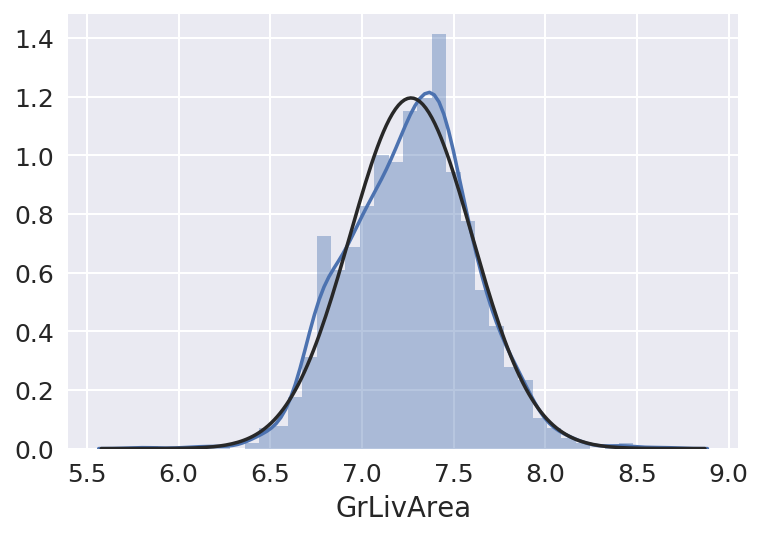

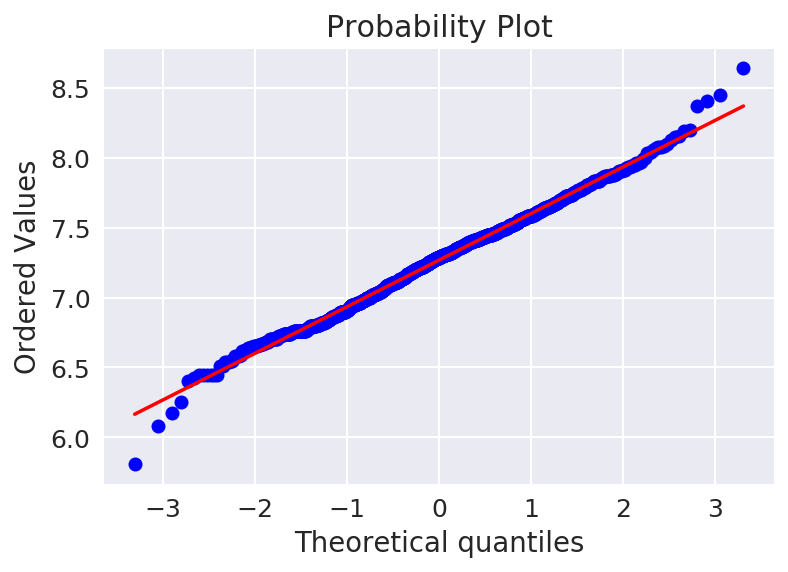

In [53]:
sns.distplot(df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['GrLivArea'], plot=plt)

## Scale
Use RobustScaler

In [54]:
RB = sk.preprocessing.RobustScaler(copy=True)

#Fit to the dataset that has outliers removed ( or tried to)
RB.fit(df_o[NotCategorical])

df[NotCategorical] = RB.transform(df[NotCategorical])
df_o[NotCategorical] = RB.transform(df_o[NotCategorical])


#### To get back SalesPrice
    Reverse the log and reverse the transform

In [55]:
def getsaleprice(data):
    output = data.copy() # So as not to overwrite our precious engineered df
    output[NotCategorical] = np.exp(RB.inverse_transform(data[NotCategorical]))
    return output


In [56]:
getsaleprice(df)

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1.0         60       RL         65.0   8450.0   Pave  None      Reg   
1        2.0         20       RL         80.0   9600.0   Pave  None      Reg   
2        3.0         60       RL         68.0  11250.0   Pave  None      IR1   
3        4.0         70       RL         60.0   9550.0   Pave  None      IR1   
4        5.0         60       RL         84.0  14260.0   Pave  None      IR1   
5        6.0         50       RL         85.0  14115.0   Pave  None      IR1   
6        7.0         20       RL         75.0  10084.0   Pave  None      Reg   
7        8.0         60       RL          1.0  10382.0   Pave  None      IR1   
8        9.0         50       RM         51.0   6120.0   Pave  None      Reg   
9       10.0        190       RL         50.0   7420.0   Pave  None      Reg   
10      11.0         20       RL         70.0  11200.0   Pave  None      Reg   
11      12.0         60       RL         85.0  11924.0   Pave  None      IR1   
12      13.0         20       RL          1.0  12968.0   Pave  None      IR2   
13      14.0         20       RL         91.0  10652.0   Pave  None      IR1   
14      15.0         20       RL          1.0  10920.0   Pave  None      IR1   
15      16.0         45       RM         51.0   6120.0   Pave  None      Reg   
16      17.0         20       RL          1.0  11241.0   Pave  None      IR1   
17      18.0         90       RL         72.0  10791.0   Pave  None      Reg   
18      19.0         20       RL         66.0  13695.0   Pave  None      Reg   
19      20.0         20       RL         70.0   7560.0   Pave  None      Reg   
20      21.0         60       RL        101.0  14215.0   Pave  None      IR1   
21      22.0         45       RM         57.0   7449.0   Pave  Grvl      Reg   
22      23.0         20       RL         75.0   9742.0   Pave  None      Reg   
23      24.0        120       RM         44.0   4224.0   Pave  None      Reg   
24      25.0         20       RL          1.0   8246.0   Pave  None      IR1   
25      26.0         20       RL        110.0  14230.0   Pave  None      Reg   
26      27.0         20       RL         60.0   7200.0   Pave  None      Reg   
27      28.0         20       RL         98.0  11478.0   Pave  None      Reg   
28      29.0         20       RL         47.0  16321.0   Pave  None      IR1   
29      30.0         30       RM         60.0   6324.0   Pave  None      IR1   
...      ...        ...      ...          ...      ...    ...   ...      ...   
1430  1431.0         60       RL         60.0  21930.0   Pave  None      IR3   
1431  1432.0        120       RL          1.0   4928.0   Pave  None      IR1   
1432  1433.0         30       RL         60.0  10800.0   Pave  Grvl      Reg   
1433  1434.0         60       RL         93.0  10261.0   Pave  None      IR1   
1434  1435.0         20       RL         80.0  17400.0   Pave  None      Reg   
1435  1436.0         20       RL         80.0   8400.0   Pave  None      Reg   
1436  1437.0         20       RL         60.0   9000.0   Pave  None      Reg   
1437  1438.0         20       RL         96.0  12444.0   Pave  None      Reg   
1438  1439.0         20       RM         90.0   7407.0   Pave  None      Reg   
1439  1440.0         60       RL         80.0  11584.0   Pave  None      Reg   
1440  1441.0         70       RL         79.0  11526.0   Pave  None      IR1   
1441  1442.0        120       RM          1.0   4426.0   Pave  None      Reg   
1442  1443.0         60       FV         85.0  11003.0   Pave  None      Reg   
1443  1444.0         30       RL          1.0   8854.0   Pave  None      Reg   
1444  1445.0         20       RL         63.0   8500.0   Pave  None      Reg   
1445  1446.0         85       RL         70.0   8400.0   Pave  None      Reg   
1446  1447.0         20       RL          1.0  26142.0   Pave  None      IR1   
1447  1448.0         60       RL         80.0  10000.0   Pave  None      Reg   
1448  1449

## Predicting only with Fixed Features
    Thereby establishing some sort of baseline of what the cost of the house should be, intrisically without extra stuff ( For just the lot value, location, etc)

In [57]:
dff =pd.concat([df[housedict['fixed']],df[['Outlier']],df[['SalePrice']]],axis=1)

## Feature Creation and Extraction

### Dummy variables for categories

In [58]:
def makedummy(df,category):
    output = pd.get_dummies(df[category])
    return output.drop(output.columns[0],axis=1) #We remove 1 so that if it's not 1, then it's the other.

In [59]:
for category in categorical:
    if category in dff.columns:
        dff = pd.concat([dff,makedummy(dff,category)],axis=1,join='outer', copy=False)
#Drop the old ones
dff.drop(categorical,axis=1,inplace=True,errors='ignore')

### Remake the outlier dataframe

In [60]:
dff_o=dff.loc[dff['Outlier'] ==0].copy()
dff_o.dropna(inplace=True,axis=0) #Because it would have missing values for the outliers, so we are dropping the outliers

In [61]:
print dff.shape
print dff_o.shape

(1460, 154)
(1314, 154)


### Splitting the data to pre-2010 and post 2010 to see whether my solution works

In [62]:

dff_x2010 = dff[getsaleprice(df)['YrSold']<2010].copy() #Train
dff_ox2010 = dff_o[getsaleprice(df)['YrSold']<2010].copy() #Train without outliers

dff_2010 = dff[getsaleprice(df)['YrSold']>=2010].copy() #Test #Ground Truth

/home/nasdin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

### Training

In [64]:
dff_x2010Target = dff_x2010['SalePrice']
dff_x2010.drop('SalePrice',axis=1,inplace=True)
dff_ox2010Target = dff_ox2010['SalePrice']
dff_ox2010.drop('SalePrice',axis=1,inplace=True)

### Separate the ground truth from the test set

In [65]:
groundtruth=dff_2010['SalePrice']
dff_2010.drop('SalePrice',axis=1,inplace=True)


In [66]:
groundtruth.head()

16   -0.180374
24   -0.109203
26   -0.396336
27    1.371380
33    0.046091
Name: SalePrice, dtype: float64

## Cross Validation Function

In [67]:

def rmsle_cv(model,data,target,n_folds=5):
    kf = KFold(int(n_folds), shuffle=True, random_state=42).get_n_splits(data.values)
    rmse= np.sqrt(-cross_val_score(model, data.values, target.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Create Models

### Lasso Regressor

In [68]:
lasso =  Lasso(alpha =0.0005, random_state=1)

### Kernel Ridge Regression

In [69]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

### Elastic Net

In [70]:

ENet = (ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))


### GBoost

In [71]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

### XGBoost

In [72]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                              nthread = -1)

### LightGBM

In [73]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Individual CV Scores with outliers
## Note that these scores and tests are using only the "Fixed" Features to predict SalePrice

In [74]:
score = rmsle_cv(lasso,dff_x2010,dff_x2010Target)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(ENet,dff_x2010,dff_x2010Target)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR,dff_x2010,dff_x2010Target)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost,dff_x2010,dff_x2010Target)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb,dff_x2010,dff_x2010Target)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb,dff_x2010,dff_x2010Target)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.3255 (0.0350)

ElasticNet score: 0.3261 (0.0350)

Kernel Ridge score: 0.3844 (0.0335)

Gradient Boosting score: 0.3229 (0.0227)

Xgboost score: 0.3226 (0.0218)

LGBM score: 0.3171 (0.0187)



### Individual CV Scores without outliers

In [75]:
score = rmsle_cv(lasso,dff_ox2010,dff_ox2010Target)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(ENet,dff_ox2010,dff_ox2010Target)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR,dff_ox2010,dff_ox2010Target)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost,dff_ox2010,dff_ox2010Target)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb,dff_ox2010,dff_ox2010Target)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb,dff_ox2010,dff_ox2010Target)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.2782 (0.0106)

ElasticNet score: 0.2780 (0.0115)

Kernel Ridge score: 0.2912 (0.0122)

Gradient Boosting score: 0.2904 (0.0083)

Xgboost score: 0.2928 (0.0031)

LGBM score: 0.2924 (0.0035)



## Without outliers Score significantly better
    We'll just work without the outliers from now on

## Stacking the models for higher score



In [76]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

### Steps

Split the total training set into two disjoint sets (here train and .holdout )

Train several base models on the first part (train)

Test these base models on the second part (holdout)

Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.


In [77]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [[] for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                
                instance.fit(X[train_index], y[train_index])
                self.base_models_[i].append(instance)
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

### We use Lasso as the MetaLearner

In [78]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

In [79]:
score = rmsle_cv(stacked_averaged_models,dff_ox2010,dff_ox2010Target)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.2711 (0.0093)


### We stack the Stack with xgb and lgb
lasso as the metamodel of this metamodel stack

In [80]:
StackOfStack = StackingAveragedModels(base_models= (stacked_averaged_models,model_xgb, model_lgb), meta_model = lasso)

In [81]:
score = rmsle_cv(StackOfStack,dff_ox2010,dff_ox2010Target)
print("Stacked of Stacked Model: {:.4f} ({:.4f})".format(score.mean(), score.std()))

/home/nasdin/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Stacked of Stacked Model: 0.2701 (0.0076)


## Ensembling
Fit the different models together and then take a weighted guess

In [82]:
stacked_averaged_models.fit(dff_ox2010.values,dff_ox2010Target.values) #Trained the Stacked models

StackingAveragedModels(base_models=(ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False), GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=No...nelRidge(alpha=0.6, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None)),
            meta_model=Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False),
            n_folds=5)

In [83]:
stacked_pred = (stacked_averaged_models.predict(dff_2010.values))

In [84]:
StackOfStack.fit(dff_ox2010.values,dff_ox2010Target.values) #Trained the Stacked of Stacked
StackOfStack_pred = (stacked_averaged_models.predict(dff_2010.values))

In [85]:
model_xgb.fit(dff_ox2010.values,dff_ox2010Target.values) #Trained the xgb
xgb_pred = (model_xgb.predict(dff_2010.values))

In [86]:
model_lgb.fit(dff_ox2010.values,dff_ox2010Target.values) #Trained the xgb
lgb_pred = (model_lgb.predict(dff_2010.values))

### And...Ensemble

In [87]:
ensemble = StackOfStack_pred*0.45+stacked_pred*0.35 + xgb_pred*0.10 + lgb_pred*0.10

## Predicting the Post2010 price
### Need a way to see how accurate we are
#### Define a function

In [88]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [89]:
sub = pd.DataFrame()
sub['SalePrice'] = ensemble #Predictions

### Now we check the score
### The rmsle of the predictions against the ground truth!!!

In [90]:
print rmsle(groundtruth.values,ensemble)

0.277128390406


In [91]:
Truth = dff_2010.copy()

Truth['Predicted']=ensemble
Truth['SalePrice']=groundtruth
Truth['Difference'] = Truth['Predicted'] / Truth['SalePrice']

Truth.head()

TotalSF  LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
16 -0.512290    -6.502989  0.447035  -0.108994     -0.649783    1.028995   
24 -0.367304    -6.502989 -0.307797  -0.152669      0.188047    0.000000   
26 -0.804396    -0.076580 -0.638261  -0.525709      0.161224    0.000000   
27  0.900756     0.693493  0.497865   0.691094      0.375438    1.049872   
33  0.646004     0.165372  0.292939  -0.349757     -0.950251    0.000000   

    BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  \
16    0.061264    0.000000  -0.075690     0.054396 -0.154750       0.0   
24   -0.110262    6.504288  -0.655258     0.173902 -0.026582       0.0   
26   -0.076835    6.186209  -0.753776    -0.186376 -0.412971       0.0   
27    0.175102    0.000000   0.028028     1.219113  1.094381       0.0   
33    0.147708    0.000000  -0.165632     0.783300  1.088831       0.0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
16  -0.839839           0.0           0.0      -1.0       0.0     -1.000000   
24  -0.711462           0.0           0.0      -1.0       0.0      0.000000   
26  -1.098480           0.0           0.0      -1.0       0.0      0.000000   
27   0.411325           0.0           0.0       0.0       0.0      0.000000   
33   0.405766           0.0           0.0      -1.0       0.0      0.709511   

    KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  \
16           0.0     -0.541862         0.0    -0.207965    0.000000   
24           0.0      0.000000         0.0    -0.257028   -1.000000   
26           0.0     -0.541862         0.0     0.642679    0.000000   
27           0.0      0.458138         0.0     0.714899    0.584963   
33           0.0      0.000000         0.0    -0.478434    0.000000   

    GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
16    0.008478    0.000000    -0.764160            0.0        0.0   
24   -1.159830    1.172208     0.317815            0.0        0.0   
26    0.378692    1.054394     0.069173            0.0        0.0   
27    0.973394    0.000000     0.176482            0.0        0.0   
33   -0.136153    0.000000     0.110494            0.0        0.0   

    ScreenPorch  PoolArea  MiscVal    MoSold    YrSold  Outlier  FV  RH  RL  \
16          0.0       0.0  6.55108 -1.474770  0.999502        0   0   0   1   
24          0.0       0.0  0.00000 -0.387915  0.999502        0   0   0   1   
26          0.0       0.0  0.00000 -0.387915  0.999502        0   0   0   1   
27          0.0       0.0  0.00000 -0.387915  0.999502        0   0   0   1   
33          0.0       0.0  0.00000 -0.862685  0.999502        0   0   0   1   

    RM  Pave  None  Pave  IR2  IR3  Reg  CulDSac  FR2  FR3  Inside  Mod  Sev  \
16   0     1     1     0    0    0    0        1    0    0       0    0    0   
24   0     1     1     0    0    0    0        0    0    0       1    0    0   
26   0     1     1     0    0    0    1        0    0    0       0    0    0   
27   0     1     1     0    0    0    1        0    0    0       1    0    0   
33   0     1     1     0    0    0    0        0    0    0       1    0    0   

    Blueste  BrDale  BrkSide  ClearCr  CollgCr  Crawfor  Edwards  Gilbert  \
16        0       0        0        0        0        0        0        0   
24        0       0        0        0        0        0        0        0   
26        0       0        0        0        0        0        0        0   
27        0       0        0        0        0        0        0        0   
33        0       0        0        0        0        0        0        0   

    IDOTRR  MeadowV  Mitchel  NAmes  NPkVill  NWAmes  NoRidge  NridgHt  \
16       0        0        0      1        0       0        0        0   
24       0        0        0      0        0       0        0        0   
26       0        0        0      1        0       0        0        0   
27       0        0        0      0        0       0        0        1 

In [92]:
Truth[['Predicted','SalePrice','Difference']].describe()

Predicted   SalePrice  Difference
count  175.000000  175.000000  175.000000
mean    -0.023740    0.012335        -inf
std      0.785576    0.877227         NaN
min     -1.692366   -2.329368        -inf
25%     -0.549771   -0.506267    0.701133
50%     -0.117371   -0.095246    0.973894
75%      0.559132    0.592697    1.262046
max      2.171752    2.864802   74.429635

## Determine any value of changeable property characteristics unexplained by the fixed ones.
1. Evaluate the effect in dollars of the renovate-able features. 
2. How would a company use this second model and its coefficients to determine whether they should buy a property or not? 
3. Explain how a company can use the two models you have built to determine if they can make money. 
4. Investigate how much of the variance in price remaining is explained by these features.
5. Reliability of the model? Should it be used to evaluate which properties to buy and fix up?

## Create model but now using renovatable and fixed properties

In [93]:
dfnew=df.copy()
dfnew.drop('Id',axis=1,inplace=True)

## Feature Creation and Extraction

### Dummy variables for categories

In [94]:
for a in categorical:
    if a in dfnew.columns:
        dfnew = pd.concat([dfnew,makedummy(dfnew,a)],axis=1,join='outer')
#Drop the old ones
dfnew.drop(categorical,axis=1,inplace=True)

### Remake the outlier dataframe. only use without outliers this time

In [95]:
df_o=dfnew.loc[dfnew['Outlier'] ==0].copy()
df_o.dropna(inplace=True,axis=0) #Because it would have missing values for the outliers, so we are dropping the outliers

### Splitting the data to pre-2010 and post 2010 to see whether my solution works

In [96]:
train = df_o[getsaleprice(df)['YrSold']<2010].copy() #Train without outliers
test = dfnew[getsaleprice(df)['YrSold']>=2010].copy() #Test #Ground Truth

/home/nasdin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


### Training

In [97]:
trainTarget = train['SalePrice']
train.drop('SalePrice',axis=1,inplace=True)

### Separate the ground truth from the test set

In [98]:
testanswer=test['SalePrice']
test.drop('SalePrice',axis=1,inplace=True)


### Individual CV Scores test

In [99]:
score = rmsle_cv(lasso,train,trainTarget)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(ENet,train,trainTarget)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR,train,trainTarget)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost,train,trainTarget)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb,train,trainTarget)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb,train,trainTarget)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.2409 (0.0160)

ElasticNet score: 0.2415 (0.0160)

Kernel Ridge score: 0.2496 (0.0097)

Gradient Boosting score: 0.2483 (0.0092)

Xgboost score: 0.2514 (0.0080)

LGBM score: 0.2487 (0.0082)



## Prediction is much better

### We use Lasso as the MetaLearner

In [100]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

### We stack the Stack with xgb and lgb
lasso as the metamodel of this metamodel stack

In [101]:
StackOfStack = StackingAveragedModels(base_models= (stacked_averaged_models,model_xgb, model_lgb), meta_model = lasso)

## Ensembling
Fit the different models together and then take a weighted guess

In [102]:
stacked_averaged_models.fit(train.values,trainTarget.values) #Trained the Stacked models

StackingAveragedModels(base_models=(ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False), GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=No...nelRidge(alpha=0.6, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None)),
            meta_model=Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False),
            n_folds=5)

In [103]:
stacked_pred = (stacked_averaged_models.predict(test.values))

In [104]:
StackOfStack.fit(train.values,trainTarget.values) #Trained the Stacked of Stacked

StackingAveragedModels(base_models=(StackingAveragedModels(base_models=(ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False), GradientBoostingRegressor(alpha=0....=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=50000, subsample_freq=1)),
            meta_model=Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False),
            n_folds=5)

In [105]:
StackOfStack_pred = (stacked_averaged_models.predict(test.values))

In [106]:
model_xgb.fit(train.values,trainTarget.values) #Trained the xgb
xgb_pred = (model_xgb.predict(test.values))

In [107]:
model_lgb.fit(train.values,trainTarget.values) #Trained the xgb
lgb_pred = (model_lgb.predict(test.values))

### And...Ensemble

In [108]:
ensemble = StackOfStack_pred*0.4+stacked_pred*0.3 + xgb_pred*0.15 + lgb_pred*0.15

## Predicting the Post2010 price

### Now we check the score
### The rmsle of the predictions against the ground truth!!!

In [109]:
print rmsle(testanswer.values,ensemble)

0.256463372324


In [110]:
Truth['NewPrediction']=ensemble
Truth['RenovatablePriceFactor'] = Truth['NewPrediction'] - Truth['Predicted']
Truth['AveragePrediction'] = (Truth['NewPrediction'] + Truth['Predicted'])/2

Truth.head()

TotalSF  LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
16 -0.512290    -6.502989  0.447035  -0.108994     -0.649783    1.028995   
24 -0.367304    -6.502989 -0.307797  -0.152669      0.188047    0.000000   
26 -0.804396    -0.076580 -0.638261  -0.525709      0.161224    0.000000   
27  0.900756     0.693493  0.497865   0.691094      0.375438    1.049872   
33  0.646004     0.165372  0.292939  -0.349757     -0.950251    0.000000   

    BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  \
16    0.061264    0.000000  -0.075690     0.054396 -0.154750       0.0   
24   -0.110262    6.504288  -0.655258     0.173902 -0.026582       0.0   
26   -0.076835    6.186209  -0.753776    -0.186376 -0.412971       0.0   
27    0.175102    0.000000   0.028028     1.219113  1.094381       0.0   
33    0.147708    0.000000  -0.165632     0.783300  1.088831       0.0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
16  -0.839839           0.0           0.0      -1.0       0.0     -1.000000   
24  -0.711462           0.0           0.0      -1.0       0.0      0.000000   
26  -1.098480           0.0           0.0      -1.0       0.0      0.000000   
27   0.411325           0.0           0.0       0.0       0.0      0.000000   
33   0.405766           0.0           0.0      -1.0       0.0      0.709511   

    KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  \
16           0.0     -0.541862         0.0    -0.207965    0.000000   
24           0.0      0.000000         0.0    -0.257028   -1.000000   
26           0.0     -0.541862         0.0     0.642679    0.000000   
27           0.0      0.458138         0.0     0.714899    0.584963   
33           0.0      0.000000         0.0    -0.478434    0.000000   

    GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
16    0.008478    0.000000    -0.764160            0.0        0.0   
24   -1.159830    1.172208     0.317815            0.0        0.0   
26    0.378692    1.054394     0.069173            0.0        0.0   
27    0.973394    0.000000     0.176482            0.0        0.0   
33   -0.136153    0.000000     0.110494            0.0        0.0   

    ScreenPorch  PoolArea  MiscVal    MoSold    YrSold  Outlier  FV  RH  RL  \
16          0.0       0.0  6.55108 -1.474770  0.999502        0   0   0   1   
24          0.0       0.0  0.00000 -0.387915  0.999502        0   0   0   1   
26          0.0       0.0  0.00000 -0.387915  0.999502        0   0   0   1   
27          0.0       0.0  0.00000 -0.387915  0.999502        0   0   0   1   
33          0.0       0.0  0.00000 -0.862685  0.999502        0   0   0   1   

    RM  Pave  None  Pave  IR2  IR3  Reg  CulDSac  FR2  FR3  Inside  Mod  Sev  \
16   0     1     1     0    0    0    0        1    0    0       0    0    0   
24   0     1     1     0    0    0    0        0    0    0       1    0    0   
26   0     1     1     0    0    0    1        0    0    0       0    0    0   
27   0     1     1     0    0    0    1        0    0    0       1    0    0   
33   0     1     1     0    0    0    0        0    0    0       1    0    0   

    Blueste  BrDale  BrkSide  ClearCr  CollgCr  Crawfor  Edwards  Gilbert  \
16        0       0        0        0        0        0        0        0   
24        0       0        0        0        0        0        0        0   
26        0       0        0        0        0        0        0        0   
27        0       0        0        0        0        0        0        0   
33        0       0        0        0        0        0        0        0   

    IDOTRR  MeadowV  Mitchel  NAmes  NPkVill  NWAmes  NoRidge  NridgHt  \
16       0        0        0      1        0       0        0        0   
24       0        0        0      0        0       0        0        0   
26       0        0        0      1        0       0        0        0   
27       0        0        0      0        0       0        0        1 

In [111]:
print rmsle(testanswer.values,Truth['AveragePrediction'])

0.257271561093


### Evaluating the effect in dollars of the renovate-able features

#### We use the Renovatable Price Factor, derived from the difference in the valuation made with the renovatable features vs fixed features
    The prediction using the renovatable features has to be more accurate than the one using only the fixed features
    We want to compare, by how much does price increase or decrease when we account for renovatable features
    
    The prediction given only by the fixed feature tells us the possible cost of the "core" value of the area
    The additional information of the renovatable features into the prediction. Take the Price Factor, this tells us how much the effects of the renovatable features have on the property. Take this amount and multiply it with the
    Dollar cost of the property
                  

### Commercializing this model
    Since it is assumed that the company makes money off buying cheap properties, developing them and then selling them at a higher price:
    We have the following information:
    1. True market value of property
    2. Predicted price of property considering only fixed features
    3. Predicted Price of property considering all features including renovatable features
    4. The effect of the current renovatable features on the price of the property
    
#### Buy Strategy.
    A purchase should be made if:
    (1)  < (2) and (3)
    (3) < (2) (For when you need to buy and renovate the property)
    (4) in the top 20th Percentile or bottom 20th Percentile (This means the property price is sensitive to renovations)

### Examining Differences in price caused by renovatable features

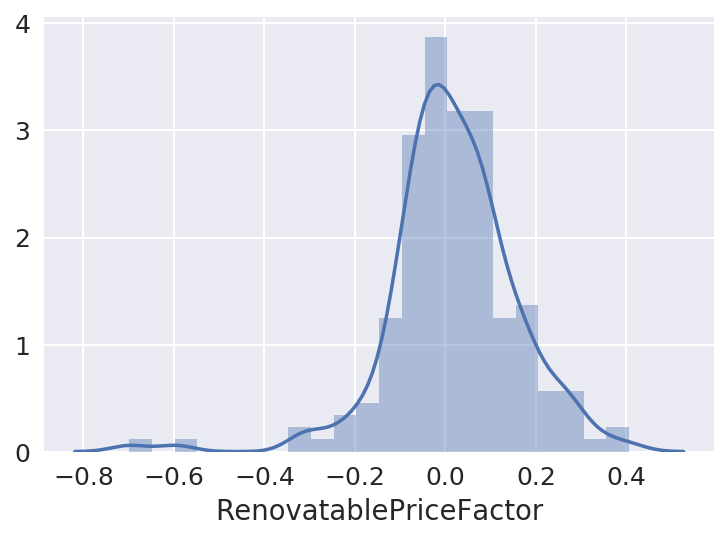

In [112]:
sns.distplot(Truth['RenovatablePriceFactor'])

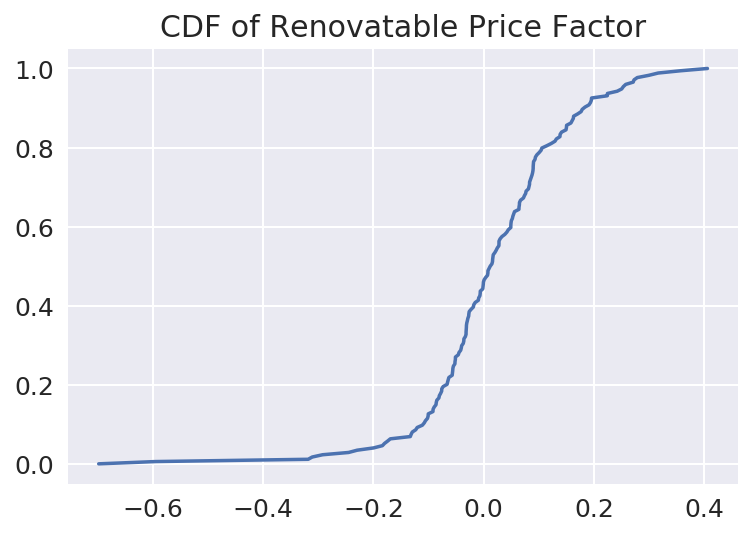

In [113]:
data = Truth['RenovatablePriceFactor']

sorted_data = np.sort(data)

yvals=np.arange(len(sorted_data))/float(len(sorted_data)-1)

plt.plot(sorted_data,yvals)
plt.title("CDF of Renovatable Price Factor")

plt.show()

### 50%, it's 0, it cancels out the differences between the price by the fixed features vs renovatable
    So the company has to work with only working with the extreme values

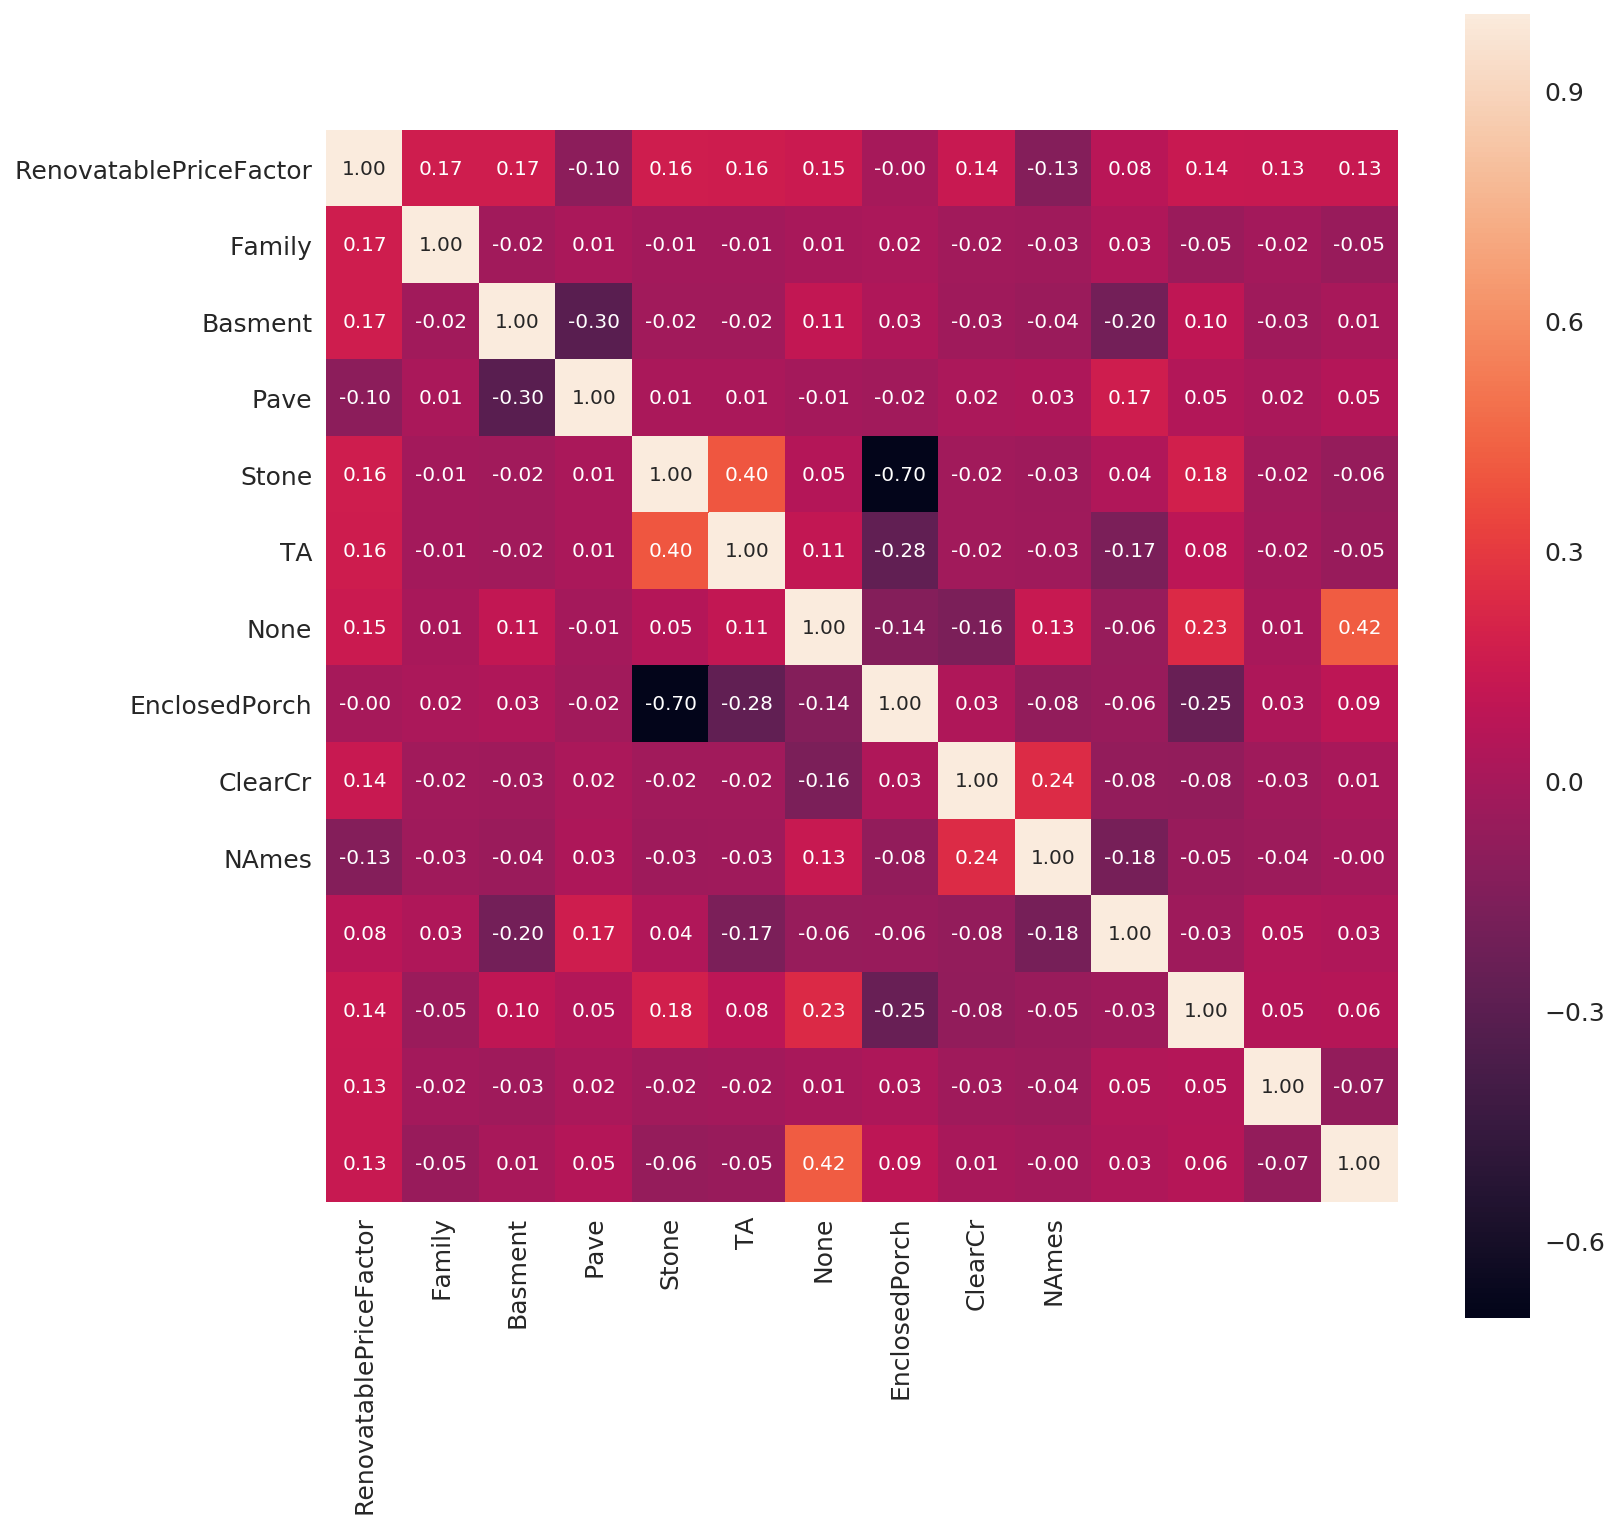

In [114]:
k = 10 #number of variables for heatmap
cols = Truth.corr().nlargest(k, 'RenovatablePriceFactor')['RenovatablePriceFactor'].index # Basically just show the K-largest correlations
cm = np.corrcoef(Truth[cols].values.T)
sns.set(font_scale=1.25)
plt.subplots(figsize=[12,12])
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


# Predicting abnormal sales
## Finding out what features lead to abnormal sales

In [115]:
df['SaleCondition'].shape

(1460,)

### Binarizer
Hotdog, not hotdog

In [116]:
dfnew['Abnormal'] = 0

In [117]:
dfnew.loc[df['SaleCondition'] !='Abnorml','Abnormal'] = 0
dfnew.loc[df['SaleCondition'] =='Abnorml','Abnormal'] =1
abnormals = dfnew.loc[df['SaleCondition'] =='Abnorml']
normal = dfnew.loc[df['SaleCondition'] !='Abnorml']

abnormalanswers = dfnew['Abnormal'].copy()


In [118]:
dfnew.drop('Abnormal',axis=1,inplace=True)

In [119]:
!conda install -c glemaitre imbalanced-learn --yes

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /home/nasdin/anaconda2:
#
imbalanced-learn          0.3.0            py27hb8af1d3_0    glemaitre


In [120]:
X =dfnew
y= abnormalanswers

In [121]:
X.drop(untouched['SaleCondition'].unique(),inplace=True,axis=1)

In [126]:
from collections import Counter

from sklearn.model_selection import train_test_split

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.svm import LinearSVC

In [127]:

print(__doc__)

RANDOM_STATE = 42


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE)

print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

# Create a pipeline
pipeline = make_pipeline(NearMiss(version=2, random_state=RANDOM_STATE),
                         LinearSVC(random_state=RANDOM_STATE))
pipeline.fit(X_train, y_train)

# Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

Automatically created module for IPython interactive environment
Training target statistics: Counter({0: 1024, 1: 71})
Testing target statistics: Counter({0: 335, 1: 30})
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.17      0.83      0.29      0.28      0.08       335
          1       0.08      0.83      0.17      0.15      0.28      0.07        30

avg / total       0.85      0.23      0.78      0.28      0.28      0.08       365



In [128]:
sampleweight = ((y.value_counts()[1]) /1.) / ( (y.value_counts()[1])+ (y.value_counts()[0]) )#WK feels happier when you do it like this
print sampleweight

0.0691780821918


## Recursive feature elimination with cross-validation

Optimal number of features : 2


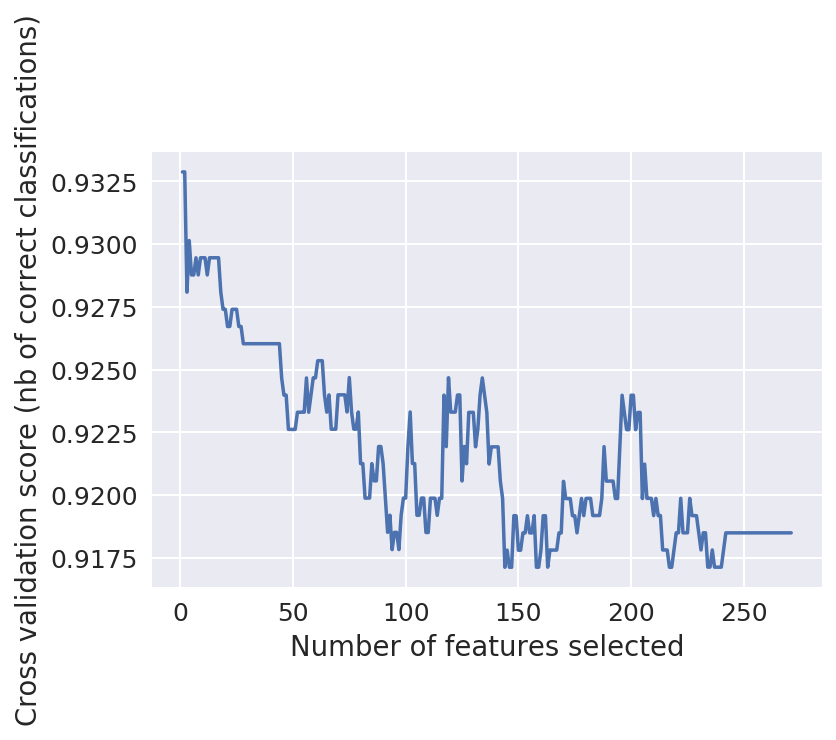

In [129]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification



# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


## Feature importances with forests of trees

In [130]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

Feature ranking:
('1. feature 256 (0.041291)', 'LotFrontage')
('2. feature 35 (0.021741)', 'LotArea')
('3. feature 33 (0.020188)', 'OverallQual')
('4. feature 34 (0.016978)', 'OverallCond')
('5. feature 5 (0.016022)', 'YearBuilt')
('6. feature 9 (0.015484)', 'YearRemodAdd')
('7. feature 14 (0.015231)', 'MasVnrArea')
('8. feature 1 (0.015174)', 'BsmtFinSF1')
('9. feature 36 (0.015144)', 'BsmtFinSF2')
('10. feature 11 (0.014999)', 'BsmtUnfSF')
('11. feature 4 (0.014757)', 'TotalBsmtSF')
('12. feature 23 (0.014067)', '1stFlrSF')
('13. feature 25 (0.013572)', '2ndFlrSF')
('14. feature 21 (0.013510)', 'LowQualFinSF')
('15. feature 27 (0.013006)', 'GrLivArea')
('16. feature 10 (0.012818)', 'BsmtFullBath')
('17. feature 7 (0.012787)', 'BsmtHalfBath')
('18. feature 2 (0.012765)', 'FullBath')
('19. feature 0 (0.012335)', 'HalfBath')
('20. feature 3 (0.011971)', 'BedroomAbvGr')
('21. feature 26 (0.010875)', 'KitchenAbvGr')
('22. feature 19 (0.010522)', 'TotRmsAbvGrd')
('23. feature 255 (0.010226

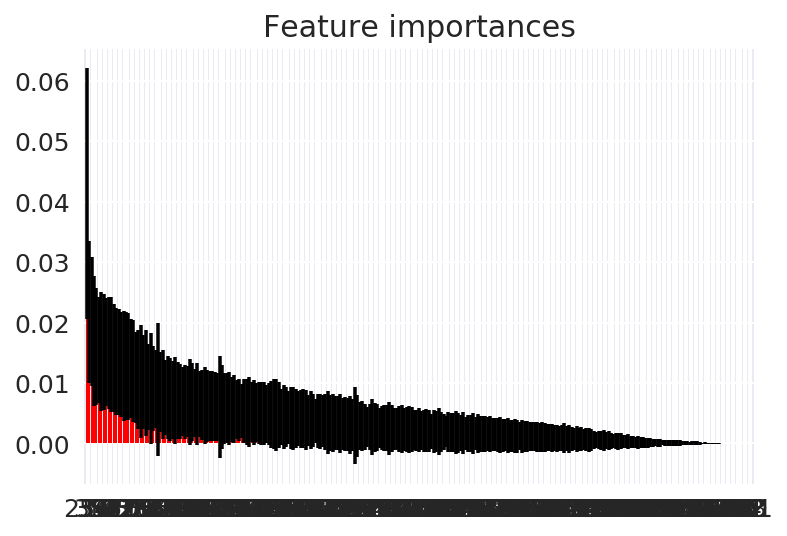

In [131]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
GoodFeatures = []
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),X.columns[f])
    if f<= 10: GoodFeatures.append(X.columns[f]) #Extract the Good columns

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [132]:
GoodFeatures

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF']

### Fixing the imbalanced problem with bootstrapping
    abnormals : DF which contains all the abnormals
    normals: DF which contains all the normals
    We take the bootstrap of 1000 samples each, them combine into a single dataframe

In [ ]:
dbootstrap = pd.concat([abnormals.sample(replace=True,n=1000),abnormals.sample(replace=True,n=1000)])

In [173]:
dbootstrap.head()

index  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0     91     0.470116 -0.233888    -0.541862    -2.801784  -0.305882   
1   1024    -6.502989  1.229405     0.854995     1.000000   0.021766   
2   1152     0.559831  1.001686     0.000000     1.845488  -0.415655   
3   1279    -0.076580 -0.538811    -1.205048    -1.223901  -1.214403   
4   1152     0.559831  1.001686     0.000000     1.845488  -0.415655   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0     -0.895495    1.052823    0.066969    0.000000   0.238515     0.510340   
1     -0.486598    0.000000    0.168307    5.991465  -4.841229     1.031757   
2      0.268438    0.000000   -0.040939    6.304449  -0.560836     0.200741   
3     -1.197345    0.000000   -0.909980    0.000000   0.312972    -0.746018   
4      0.268438    0.000000   -0.040939    6.304449  -0.560836     0.200741   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0  0.334239  0.000000           0.0  -0.350054           0.0           0.0   
1  2.348367  0.000000           0.0   1.667351           0.0           0.0   
2  1.238190  0.000000           0.0   0.555368           0.0           0.0   
3 -1.013173  0.924063           0.0  -0.564400           0.0           0.0   
4  1.238190  0.000000           0.0   0.555368           0.0           0.0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0      -1.0       0.0          -1.0           0.0      0.000000         0.0   
1       0.0       0.0          -1.0           0.0      1.518181         0.0   
2      -1.0       0.0          -1.0           0.0      0.000000         0.0   
3      -1.0       0.0          -1.0           0.0      0.000000         0.0   
4      -1.0       0.0          -1.0           0.0      0.000000         0.0   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0    -0.429145         0.0    0.008478    0.000000     -0.76416   
1    -0.061072         0.0    0.670441    0.000000      0.26416   
2    -0.552461         0.0   -0.034272    0.000000     -0.76416   
3     0.036609         0.0    0.202011    0.663782     -0.76416   
4    -0.552461         0.0   -0.034272    0.000000     -0.76416   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal    MoSold  \
0       0.000000        0.0          0.0       0.0      0.0  1.474770   
1       5.159055        0.0          0.0       0.0      0.0 -0.387915   
2       5.634790        0.0          0.0       0.0      0.0  0.327978   
3       5.099866        0.0          0.0       0.0      0.0 -0.862685   
4       5.634790        0.0          0.0       0.0      0.0  0.327978   

     YrSold  SalePrice   TotalSF  Outlier  FV  RH  RL  RM  Pave  None  Pave  \
0 -1.000498  -1.070655  0.040866        0   0   0   1   0     1     1     0   
1  0.000000   1.233156  1.621177        1   0   0   1   0     1     1     0   
2 -1.000498   0.755745  0.454801        0   0   0   1   0     1     1     0   
3  0.999502  -1.859210 -0.766088        0   0   0   0   0     1     1     0   
4 -1.000498   0.755745  0.454801        0   0   0   1   0     1     1     0   

   IR2  IR3  Reg  HLS  Low  Lvl  NoSeWa  CulDSac  FR2  FR3  Inside  Mod  Sev  \
0    0    0    1    0    0    1       0        0    0    0       1    0    0   
1    0    0    0    0    0    1       0        0    0    0       0    0    0   
2    0    0    0    0    0    1       0        0    0    0       1    0    0   
3    0    0    1    0    0    1       0        0    0    0       1    0    0   
4    0    0    0    0    0    1       0        0    0    0       1    0    0   

   Blueste  BrDale  BrkSide  ClearCr  CollgCr  Crawfor  Edwards  Gilbert  \
0        0       0        0        0        0        0        0        0   
1        0       0        0        0        0        0        0        0   
2        0       0        0        0        0        1        0        0   
3        0       0        0        0        0    

In [134]:
dbootstrap.reset_index(inplace=True)

dbootstrap.shape

(2000, 278)

### Use only the best features
### Now no longer imbalanced

In [135]:
abnormaldf = dbootstrap[GoodFeatures].copy()

In [136]:
abnormaldf.shape

(2000, 11)

In [137]:
abnormaldf.drop('Abnormal',axis=1,inplace=True,errors='ignore')

In [138]:
bootstrapanswers = dbootstrap['Abnormal']

### Using RandomForests

In [139]:
from sklearn.ensemble import RandomForestClassifier

In [140]:
RFC = RandomForestClassifier(n_estimators=100, max_depth=11)

In [141]:
RFC.fit(abnormaldf,bootstrapanswers)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [142]:
RFC.predict(abnormaldf)
rmsle(bootstrapanswers,RFC.predict(abnormaldf))

0.0

### A bit too good to be true. Let's try Cross Validation

In [143]:
from sklearn.model_selection import train_test_split

### Hold Out method

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
...     abnormaldf, bootstrapanswers, test_size=0.4, random_state=0) 
RFC.fit(X_train,y_train)
RFC.score(X_test, y_test)  

1.0

In [145]:
scores = np.mean(cross_val_score(RFC, abnormaldf, bootstrapanswers, cv=10))
scores

1.0

#### Okay...

In [146]:
X_train, X_test, y_train, y_test = train_test_split(
...     abnormaldf, bootstrapanswers, test_size=0.6, random_state=0) 

In [147]:
from sklearn.model_selection import cross_val_predict

In [148]:
RFC.fit(X_train,y_train) # Only fit on the train set, has not seen the test set
predicted = cross_val_predict(RFC, X_test, y_test, cv=10)
sk.metrics.accuracy_score(y_test, predicted) 

1.0

# 100% prediction accuracy

### Fit on bootstrap, test on real dataset (without bootstrap)

In [152]:
abnormalanswers.shape

(1460,)

In [153]:
RFC.fit(abnormaldf,bootstrapanswers)

rmsle(abnormalanswers,RFC.predict(dfnew[GoodFeatures]))

0.96479112651818022

### What if I didn't do the bootstrap
#### Bootstrap was necessary to predict well!

In [157]:
RFC.fit(dfnew[GoodFeatures],abnormalanswers)

rmsle(abnormalanswers,RFC.predict(dfnew[GoodFeatures]))

0.19758819775080433

## Using LGBoost

In [165]:
model_lgb.fit(abnormaldf,bootstrapanswers)
rmsle(abnormalanswers,model_lgb.predict(dfnew[GoodFeatures]))

0.26301726595754282